
# Comparação entre o algoritmo de PageRank Sequencial e sua versão paralelizada.

# Introdução
O presente relatório tem por objetivo apresentar o efetivo progresso realizado pelos estudantes João Vitor Spolavore e Thiago Gonçalves da análise comparativa entre o algoritmo PageRank Sequencial e sua versão Paralela. Ainda, explicaremos como o projeto foi realizado, as decisões tomadas, as escolhas de parâmetros, os resultados até o momento e, por fim, citar as dificuldades enfrentadas ao longo do projeto.


---
# Ambiente de teste

## Máquina utilizada
Todos os experimentos realizados foram executados no Parque de Computação de Alto Desempenho (PCAD) da Universidade Federal do Rio Grande do Sul (UFRGS). Mais especificamente utilizamos o nó computacional denominado *blaise* - por questões de comodidade utilizaremos nó computacional e máquina indistintamente. As características e especificações dessa máquina estão descritas abaixo:

| Nome   | Partição | CPU                                                             | RAM         | Acelerador | Disco                  | Placa-mãe         |
|--------|----------|-----------------------------------------------------------------|-------------|------------|------------------------|-------------------|
| blaise | blaise   | 2 x Intel(R) Xeon(R) E5-2699 v4, 2.20 GHz, 88 threads, 44 cores | 256 GB DDR4 | -          | 1.8 TB SSD, 1.8 TB HDD | Supermicro X10DGQ |
|        |          |                                                                 |             |            |                        |                   |
|        |          |                                                                 |             |            |                        |                   |

*Gerador da tabela acima utilizado: https://www.tablesgenerator.com/markdown_tables*

Perceba que ela possui **dois** processadores Intel, essa informação é de grande interesse do grupo e foi fundamental para a escolha dessa máquina, uma vez que isso possibilita uma gama de experimentos que modificam, por exemplo, como as threads criadas pelo programa serão distruídas entre esses processadores.

---

# Parâmetros considerados

Antes de comentar sobre os parâmetros considerados, cabe destacar que fixamos a frequência da CPU para o máximo possível a fim de garantir que todos os testes tivessem igualdade na frêquencia utilizada. Isso foi realizado modificando o governor através do comando `cpufreq-set -g performance`.

Observando toda a gama de variáveis que podemos manipular, nós consideramos essas opções pra analisarmos em nossa pesquisa:
- **Número de Threads**
  - Objetivo do nosso estudo, é o que planejamos utilizar pra averiguar a escalabilidade do nosso programa. Escolhemos variar entre {1, 4, 12, 22, 28, 36, 44, 66, 88}. Essa sequência foi escolhida fundamentalmente para abrangir os números 22, 44 e 88, uma vez que eles representam a quantidade de threads físicas em um processador, a quantidade de threads totais (lógicas + físicas) em um processador e a quantidade total de threads da máquina ( considerando os dois processadores presentes) respectivamente.
- **Tipo de análise feita pelo Profiler**
  - Com diferentes tipos de análise, vamos poder obter mais informações sobre:
    - Onde o programa gasta mais tempo executando.
    - Eficácia da paralelização.
    - Diferença do uso e atribuição de threads dependendo da política de escolha de threads.
  - Escolhemos 3 tipos de análise: {hpc-performance, hotspots, performance-snapshot}, como já mencionamos na etapa 1.
- **Estado do Hyperthreading (ON/OFF)**
  - O Hyperthreading (ou Simultaneous MultiThreading) possibilita um processador agir como dois "cores" lógicos, executando múltiplas threads mais eficientemente.
  - Queremos saber o quanto isso pode impactar no desempenho de uma aplicação como a nossa.
  - Cabe destacar que não conseguimos efetivamente desligar o hyperthreading do nó computacional, uma vez que isso necessitaria acesso a BIOS do sistema - a qual o grupo não possui acesso. Na prática, forçamos que apenas uma thread fosse rodada por core através da modificação da variável de ambiente do *OpenMP* `OMP_PLACES`. Ademais, identificamos de maneira automática as threads físicas e lógicas da máquina e, dependendo do paramêtro passado, reduzimos a visibilidade de threads lógicas do sistema operacional através da variável de ambiente `GOMP_CPU_AFFINITY`.
- **Política de "Binding" de Threads**
  - Como citado anteriormente, a máquina escolhida possui dois processadores. Com essa informação, decidimos analisar o impacto de como a distruibuição das threads entres esses processadores impacta o resultado final. Dessa forma, através da modificação da variável de ambiente `OMP_PROC_BIND` experimentamos com as duas configurações descritas abaixo.
    - close: Vincula as threads do time a lugares próximos à thread pai. Isso é útil para quando as threads compartilham dados localmente, aproveitando a localidade de cache.
    - spread: As threads de trabalho são distribuídas em partições de processadores mais distantes da thread primária, útil para reduzir a contenção em recursos compartilhados, como caches de memória.

## Algoritmo utilizado
Por questões de facilidade e segurança, decidimos utilizar uma implementação do algoritmo PageRank já consolidada no âmbito acadêmico, que faz parte do repositório GAPBS (https://github.com/sbeamer/gapbs).

### Repositório/Escolha de Entrada
Escolhemos utilizar o Stanford Large Network Dataset Collection (SNAP), já consagrado academicamente, para nossa pesquisa.(https://snap.stanford.edu/data/index.html)

Como entrada pra nossa aplicação do PageRank precisamos de uma rede de grafos **direcionados**.

Mais especificamente, escolhemos esses grafos:
  - Friendster - 65,608,366 vértices e 1,806,067,135 arestas
  - LiveJournal - 3,997,962 vértices e 34,681,189 arestas
  - Orkut - 3,072,441 vértices e 117,185,083 arestas
  - BerkStan - 685,230 vértices e 7,600,595 arestas
  - Google - 875,713 vértices e 5,105,039 arestas
  - NotreDame - 325,729 vértices e 1,497,134 arestas
  - Stanford - 281,903 vértices e 2,312,497 arestas

Além disso, todos os resultados e códigos podem ser acessados em: https://github.com/thgdsg/perf-analysis.


In [38]:
%pip install pandas matplotlib seaborn scipy scikit-learn statsmodels jinja2 --quiet
%cd ../stage2/


Note: you may need to restart the kernel to use updated packages.
/home/thiago/Documents/perf-analysis/stage2


## Experimentos
A fim de centralizar todos as instâncias dos experimentos desejados e automatizar o processo de execução através de scripts, criamos um *csv* contendo a definição de todos os nossos experimentos.

Além disso, executamos cada configuração 5 vezes pra garantir a robustez dos nossos resultados e também evitar o impacto de possíveis *outliers* na nossa pesquisa.

Abaixo está um exemplo da estrutura desse arquivo.

In [2]:
import pandas as pd
df = pd.read_csv("experiments.csv", sep=",")

print(f'Quantidade de instâncias (linhas do csv): {df.shape[0]}')
print(f'Quantidade de parâmetros (colunas do csv): {df.shape[1]}')

print("Exemplo de 5 instâncias desse csv:")
df.sample(n=5)


Quantidade de instâncias (linhas do csv): 756
Quantidade de parâmetros (colunas do csv): 9
Exemplo de 5 instâncias desse csv:


GRAPH_NAME                                          GRAPH_URL  \
499    web-NotreDame  https://snap.stanford.edu/data/web-NotreDame.t...   
414       web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
748  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   
382       web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
360  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   

     THREADS  MAX_ITERS  TOLERANCE         ANALYSIS_TYPE  \
499       12        500   0.000001  performance-snapshot   
414       44        500   0.000001  performance-snapshot   
748       66        500   0.000001       hpc-performance   
382        1        500   0.000001       hpc-performance   
360       44        500   0.000001  performance-snapshot   

     DISABLE_HYPERTHREADING THREAD_BIND_POLICY  LOGS_GAPBS  
499                   False              close        True  
414                    True              close        True  
748                    True              close        True  
382                    True              close        True  
360                    True             spread        True

### Scripts e automações
Descrevemos abaixo de maneira sucinta todos os scripts utilizados para automatizar tanto o processo de execução dos testes quanto o processo de análise e manipulação de arquivos gerados. Ainda, vale lembrar que o código fonte de todas as automações citadas estão disponível no repositório do github:  [https://github.com/thgdsg/perf-analysis](https://github.com/thgdsg/perf-analysis)

- **perf_analysis_pr.sh** (orquestração local)
  - Prepara o ambiente (clona/compila GAPBS se necessário).
  - Carrega Intel VTune e coloca CPUs em modo performance.
  - Gera comandos com src/build_commad.py e executa todos via src/commands.sh.
  - Limpa results/ antes de rodar.
- **run.slurm** (execução em cluster SLURM)
  - Clona o repositório em SCRATCH e configura governors para todos os cores.
  - Chama ./perf_analysis_pr.sh.
  - Copia results/ de volta para HOME e roda src/unify_all_results.py ao final.
- **src/build_commad.py** (geração da matriz de execuções)
  - Lê experiments.csv e monta chamadas a ./src/executa_bench.sh.
  - Replica cada configuração em múltiplos runs.
  - Escreve a sequência em src/commands.sh (encadeado com &&).
- **src/commands.sh** (execução das variações)
  - Script gerado automaticamente com todas as combinações (grafos, threads, análise, HT, afinidade).
  - Consumido por perf_analysis_pr.sh.
- **src/unify_all_results.py** (pós-processamento)
  - Copia experiments.csv para unified_results.csv e adiciona colunas.
  - Varre results/**/report.csv, extrai Elapsed Time e calcula média por configuração.
  - Define tempo sequencial (1 thread) e calcula SPEEDUP e PARALLEL_EFFICIENCY.

Fluxo resumido
1) Preparação do ambiente → 2) Geração de comandos a partir de experiments.csv →
3) Execução sistemática → 4) Coleta em results/ → 5) Unificação em unified_results.csv.

- Entrada: experiments.csv.
- Saídas: diretório results/ e unified_results.csv consolidado.
- Boas práticas embutidas
  - Reprodutibilidade via CSV;
  - limpeza de results/;
  - desempenho da CPU consistente utilizando governor DVFS performance;
  - múltiplos runs por configuração.

## Resultados Parciais

O Intel VTune Profiler fornece uma grande quantidade de informações para análise de desempenho. Entretanto, para esta etapa de demonstração de progresso, optamos por focar em um indicador fundamental: o speedup da aplicação.

Quando paralelizamos um programa, esperamos que seu desempenho aumente de forma proporcional ao número de threads utilizadas. Na prática, porém, isso raramente ocorre.

Diversos fatores podem limitar esse ganho de desempenho ao aumentar o número de threads. Esses fatores ainda serão analisados em maior profundidade na etapa final do trabalho, onde investigaremos as principais causas que afetam a escalabilidade e a eficiência da aplicação.

### Juntando os dados

Assim, com nosso arquivo csv de experimentos que foram rodados, iremos juntar os experimentos com os resultados obtidos colocando pra executar na máquina blaise.

Mas primeiro, vamos declarar algumas funções pra fazer essa junção e cálculo de tempo/speedup.

In [3]:
import pandas as pd

def setSequencialTime(df, dic_key):
    csv_values = dic_key.split("_")
    grafo = csv_values[0]
    analise = csv_values[1]
    ht = csv_values[3] == 'True'
    bind = csv_values[4]

    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise) & (df["DISABLE_HYPERTHREADING"] == ht) & (df["THREAD_BIND_POLICY"] == bind)
    df_sequencial = df[filtro & (df["THREADS"] == 1)]

    # O tempo sequencial é o ELAPSED_TIME da configuração com 1 thread
    tempo_sequencial = df_sequencial["ELAPSED_TIME"].values[0]

    # Atualiza SEQUENTIAL_TIME pra todas as configurações da combinação (grafo, analise, ht, bind)
    df.loc[filtro, "SEQUENTIAL_TIME"] = tempo_sequencial

In [4]:
import pandas as pd

def add_tempo_resultados(df, dic_key, tempo, contador_runs):
    csv_values = dic_key.split("_")
    grafo = csv_values[0]
    analise = csv_values[1]
    threads = int(csv_values[2])
    ht = csv_values[3] == 'True'
    bind = csv_values[4]

    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise)  & (df["THREADS"] == threads) & (df["THREAD_BIND_POLICY"] == bind) & (df["DISABLE_HYPERTHREADING"] == ht)

    tempo_atual = df.loc[filtro, "ELAPSED_TIME"].values[0]
    if tempo_atual == 0.0:
        df.loc[filtro, "ELAPSED_TIME"] = float(tempo)
    else:
        # Calcula média: (soma_anterior + novo_valor) / total_runs
        soma_anterior = tempo_atual * (contador_runs - 1)
        nova_soma = soma_anterior + float(tempo)
        nova_media = nova_soma / contador_runs
        df.loc[filtro, "ELAPSED_TIME"] = nova_media

In [5]:
import pandas as pd

def calcular_speedup_parallel_efficiency(df, dic_key):
    csv_values = dic_key.split("_")
    threads = int(csv_values[2])
    grafo = csv_values[0]
    analise = csv_values[1]
    ht = csv_values[3] == 'True'
    bind = csv_values[4]
    filtro = (df["GRAPH_NAME"] == grafo) & (df["ANALYSIS_TYPE"] == analise)  & (df["THREADS"] == threads) & (df["THREAD_BIND_POLICY"] == bind) & (df["DISABLE_HYPERTHREADING"] == ht)

    sequential_time = df.loc[filtro, "SEQUENTIAL_TIME"].values[0]
    elapsed_time = df.loc[filtro, "ELAPSED_TIME"].values[0]
    speed_up = sequential_time / elapsed_time
    parallel_efficiency = sequential_time / (threads * elapsed_time)

    df.loc[filtro, "SPEEDUP"] = speed_up
    df.loc[filtro, "PARALLEL_EFFICIENCY"] = parallel_efficiency

Agora juntamos os experimentos com seus resultados, pegando o nosso objeto de estudo no results.csv de cada execução

In [6]:
import subprocess
import time
import pandas as pd

t0 = time.time()
# Copia o arquivo experiments.csv para unified_results.csv
subprocess.run(["cp", "experiments.csv", "unified_results.csv"])
df_unified = pd.read_csv("unified_results.csv", sep=",")
# Adiciona as colunas que conterão nossos resultados
df_unified["ELAPSED_TIME"] = float(0.0)
df_unified["SPEEDUP"] = float(0.0)
df_unified["PARALLEL_EFFICIENCY"] = float(0.0)
df_unified["SEQUENTIAL_TIME"] = float(0.0)

# Pega todos os arquivos report.csv
all_csv = subprocess.run([
    "find",
    ".",
    "-regex",
    ".*/results/.*/run-.*/report.csv"
], capture_output=True, text=True, check=True)

lista_arquivos = all_csv.stdout.strip().split('\n')

# 3780
print(f'Quantidade de arquivos de resultados: {len(lista_arquivos)}')

# Contar runs por configuração
contador_runs = {}

for arquivo in lista_arquivos:
    arquivo = arquivo[2::]
    arquivo_dir = arquivo.split("/")[1::]
    grafo = arquivo_dir[0]
    analise = arquivo_dir[1]
    threads = int(arquivo_dir[2].split("-")[1])
    ht_str = arquivo_dir[3].split("-")[1]
    ht = ht_str == 'true'
    bind = arquivo_dir[4].split("-")[1]
    dic_key = f'{grafo}_{analise}_{threads}_{ht}_{bind}'

    # Contar este run
    if dic_key not in contador_runs:
        contador_runs[dic_key] = 0
    contador_runs[dic_key] += 1

    df = pd.read_csv(arquivo, sep='\t', engine='python', header=0, on_bad_lines="skip")

    if(analise == 'hpc-performance'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]
    elif(analise == 'hotspots'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]
    elif(analise == 'performance-snapshot'):
        tempo = df[df["Metric Name"] == "Elapsed Time"]["Metric Value"].values[0]

    add_tempo_resultados(df_unified, dic_key, tempo, contador_runs[dic_key])

# Calcular sequential time após processar todos os elapsed times
for dic_key in contador_runs:
    csv_values = dic_key.split("_")
    threads = int(csv_values[2])
    if threads == 1:
        setSequencialTime(df_unified, dic_key)

# Calcular speedup e parallel efficiency
for dic_key in contador_runs:
    calcular_speedup_parallel_efficiency(df_unified, dic_key)

# Salvar o DataFrame atualizado para o arquivo CSV
display(df_unified)
df_unified.to_csv("unified_results.csv", sep=",", index=False)

t1 = time.time()
print(f"Tempo de execução: {t1 - t0} segundos")

Quantidade de arquivos de resultados: 3780


GRAPH_NAME                                          GRAPH_URL  \
0         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
1         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
2         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
3         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
4         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz   
..               ...                                                ...   
751  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   
752  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   
753  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   
754  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   
755  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...   

     THREADS  MAX_ITERS  TOLERANCE         ANALYSIS_TYPE  \
0          1        500   0.000001  performance-snapshot   
1          1        500   0.000001  performance-snapshot   
2          1        500   0.000001              hotspots   
3          1        500   0.000001              hotspots   
4          1        500   0.000001       hpc-performance   
..       ...        ...        ...                   ...   
751       88        500   0.000001  performance-snapshot   
752       88        500   0.000001              hotspots   
753       88        500   0.000001              hotspots   
754       88        500   0.000001       hpc-performance   
755       88        500   0.000001       hpc-performance   

     DISABLE_HYPERTHREADING THREAD_BIND_POLICY  LOGS_GAPBS  ELAPSED_TIME  \
0                      True             spread        True      8.265775   
1                     False             spread        True      8.213849   
2                      True             spread        True      8.904849   
3                     False             spread        True      8.274749   
4                      True             spread        True      8.396483   
..                      ...                ...         ...           ...   
751                   False              close        True      0.351706   
752                    True              close        True      0.554019   
753                   False              close        True      0.483792   
754                    True              close        True      0.794411   
755                   False              close        True      0.838288   

      SPEEDUP  PARALLEL_EFFICIENCY  SEQUENTIAL_TIME  
0    1.000000             1.000000         8.265775  
1    1.000000             1.000000         8.213849  
2    1.000000             1.000000         8.904849  
3    1.000000             1.000000         8.274749  
4    1.000000             1.000000         8.396483  
..        ...                  ...              ...  
751  2.992049             0.034001         1.052322  
752  2.002124             0.022751         1.109214  
753  2.410805             0.027396         1.166327  
754  1.241343             0.014106         0.986137  
755  1.292774             0.014691         1.083716  

[756 rows x 13 columns]

Tempo de execução: 4.002599239349365 segundos


Printando as colunas dos resultados, pra mostrar melhor os objetos de interesse da nossa pesquisa.

Também mostrando 5 linhas aleatórias do nosso DataFrame com os resultados e experimentos.

In [7]:
import pandas as pd

print("Colunas do DataFrame unified_results:")
print(df_unified.columns)

print("\nAmostra de 5 linhas do DataFrame unified_results:")
display(df_unified.sample(n=5))


Colunas do DataFrame unified_results:
Index(['GRAPH_NAME', 'GRAPH_URL', 'THREADS', 'MAX_ITERS', 'TOLERANCE',
       'ANALYSIS_TYPE', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY',
       'LOGS_GAPBS', 'ELAPSED_TIME', 'SPEEDUP', 'PARALLEL_EFFICIENCY',
       'SEQUENTIAL_TIME'],
      dtype='object')

Amostra de 5 linhas do DataFrame unified_results:


GRAPH_NAME                                          GRAPH_URL  \
593   web-Stanford  https://snap.stanford.edu/data/web-Stanford.tx...   
645      com-Orkut  https://snap.stanford.edu/data/bigdata/communi...   
111  web-NotreDame  https://snap.stanford.edu/data/web-NotreDame.t...   
161  web-NotreDame  https://snap.stanford.edu/data/web-NotreDame.t...   
253      com-Orkut  https://snap.stanford.edu/data/bigdata/communi...   

     THREADS  MAX_ITERS  TOLERANCE         ANALYSIS_TYPE  \
593       88        500   0.000001       hpc-performance   
645       88        500   0.000001              hotspots   
111        1        500   0.000001              hotspots   
161       88        500   0.000001       hpc-performance   
253       44        500   0.000001  performance-snapshot   

     DISABLE_HYPERTHREADING THREAD_BIND_POLICY  LOGS_GAPBS  ELAPSED_TIME  \
593                   False              close        True      1.371745   
645                   False              close        True      2.812524   
111                   False             spread        True      1.411646   
161                   False             spread        True      0.956835   
253                   False             spread        True      2.664555   

      SPEEDUP  PARALLEL_EFFICIENCY  SEQUENTIAL_TIME  
593  2.526924             0.028715         3.466296  
645  2.564436             0.029141         7.212537  
111  1.000000             1.000000         1.411646  
161  1.414019             0.016068         1.352982  
253  2.105130             0.047844         5.609234

Dando uma olhada nos tempos médios de execução pra cada grafo, separados por número de threads.

Olhando preliminarmente, parece que a eficiência melhora conforme aumenta o número de threads, exceto de 66 pra 88 threads.

In [8]:
import pandas as pd

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Calcula o tempo médio de execução por grafo, tipo de análise e número de threads
average_time_by_graph_analysis_threads = df_unified.groupby(["GRAPH_NAME", "ANALYSIS_TYPE", "THREADS"])["ELAPSED_TIME"].mean().reset_index()

# Pivota a tabela para ter uma coluna para cada quantidade de threads
pivot_table = average_time_by_graph_analysis_threads.pivot_table(
    index=["GRAPH_NAME", "ANALYSIS_TYPE"],
    columns="THREADS",
    values="ELAPSED_TIME"
)

# Exibe a tabela
print("Tempo Médio de Execução por Grafo, Tipo de Análise e Número de Threads:")
display(pivot_table)

Tempo Médio de Execução por Grafo, Tipo de Análise e Número de Threads:


THREADS                                      1          4         12  \
GRAPH_NAME      ANALYSIS_TYPE                                          
com-Friendster  hotspots              31.572248  14.409384  7.420061   
                hpc-performance       30.597228  14.158959  7.566079   
                performance-snapshot  29.882770  14.371425  7.391768   
com-LiveJournal hotspots               1.145601   0.873250  0.568871   
                hpc-performance        1.065902   0.761413  0.506477   
                performance-snapshot   1.019866   0.773590  0.459835   
com-Orkut       hotspots               6.227418   4.719341  3.532510   
                hpc-performance        6.184094   4.634889  3.385469   
                performance-snapshot   6.134138   4.623114  3.384429   
web-BerkStan    hotspots               6.496600   2.858123  2.009930   
                hpc-performance        6.504278   2.777164  1.970251   
                performance-snapshot   6.417137   2.719893  1.878581   
web-Google      hotspots               8.574722   3.635511  1.992873   
                hpc-performance        8.534743   3.615123  1.955658   
                performance-snapshot   8.352678   3.551624  1.876933   
web-NotreDame   hotspots               1.425846   0.734581  0.611220   
                hpc-performance        1.354404   0.671312  0.570364   
                performance-snapshot   1.339620   0.643589  0.504171   
web-Stanford    hotspots               3.508838   1.681844  1.049184   
                hpc-performance        3.443769   1.588889  1.002274   
                performance-snapshot   3.393861   1.564340  0.948776   

THREADS                                     22        28        36        44  \
GRAPH_NAME      ANALYSIS_TYPE                                                  
com-Friendster  hotspots              6.403855  7.015749  7.787302  7.612774   
                hpc-performance       6.321088  6.948686  7.707334  8.013490   
                performance-snapshot  6.299217  6.988925  7.514694  7.483792   
com-LiveJournal hotspots              0.519191  0.506860  0.477419  0.478405   
                hpc-performance       0.511834  0.516261  0.546047  0.589614   
                performance-snapshot  0.405350  0.378825  0.361804  0.355137   
com-Orkut       hotspots              3.083030  2.993562  2.902121  2.844003   
                hpc-performance       3.031974  3.018918  2.927874  2.930483   
                performance-snapshot  2.918719  2.844050  2.750334  2.696680   
web-BerkStan    hotspots              1.824812  1.804970  1.703735  1.694472   
                hpc-performance       1.860855  1.858420  1.785006  1.824912   
                performance-snapshot  1.715524  1.695343  1.569064  1.579129   
web-Google      hotspots              1.603539  1.467148  1.447616  1.458352   
                hpc-performance       1.610598  1.519782  1.519248  1.560159   
                performance-snapshot  1.495703  1.371425  1.335087  1.329902   
web-NotreDame   hotspots              0.557873  0.564672  0.590112  0.579064   
                hpc-performance       0.577838  0.605225  0.647647  0.687972   
                performance-snapshot  0.460593  0.461122  0.464586  0.467689   
web-Stanford    hotspots              0.839590  0.857734  0.858841  0.873750   
                hpc-performance       0.842436  0.875945  0.913057  0.954027   
                performance-snapshot  0.728759  0.740561  0.737091  0.738581   

THREADS                                     66        88  
GRAPH_NAME      ANALYSIS_TYPE                             
com-Friendster  hotspots              7.876231  8.291894  
                hpc-performance       8.495687  8.908639  
                performance-snapshot  7.741725  8.074210  
com-LiveJournal hotspots              0.504745  0.542597  
                hpc-performance       0.711114  0.834391  
                performance-snapshot  0.369524  0.379666  
com-Orkut       hotspots      

## Gráficos dos resultados

### Comentários Gerais
- Como esperado, o hyperthreading teve uma diferença significativa, em alguns casos, no desempenho do algoritmo.
- A política de *binding* também teve impacto em alguns casos, até maior do que o grupo imaginava.
- Como o tipo de análise *performance-snapshot* é o com menor overhead (podemos ver isso nos tempos de execução acima), seria o mais relevante de ser analizado em termos de similaridade ao desempenho da aplicação.
- Em alguns grafos o Hyperthreading ligado com a política de binding "close" se manteve com desempenho pior que os outros, mas ao executar com 66 e 88 threads o desempenho melhorou.

### Casos Mais Relevantes
- Stanford, performance-snapshot, HT_OFF_CLOSE com 22 threads.
- Orkut, todos, HT_ON_CLOSE, todas combinações de threads.



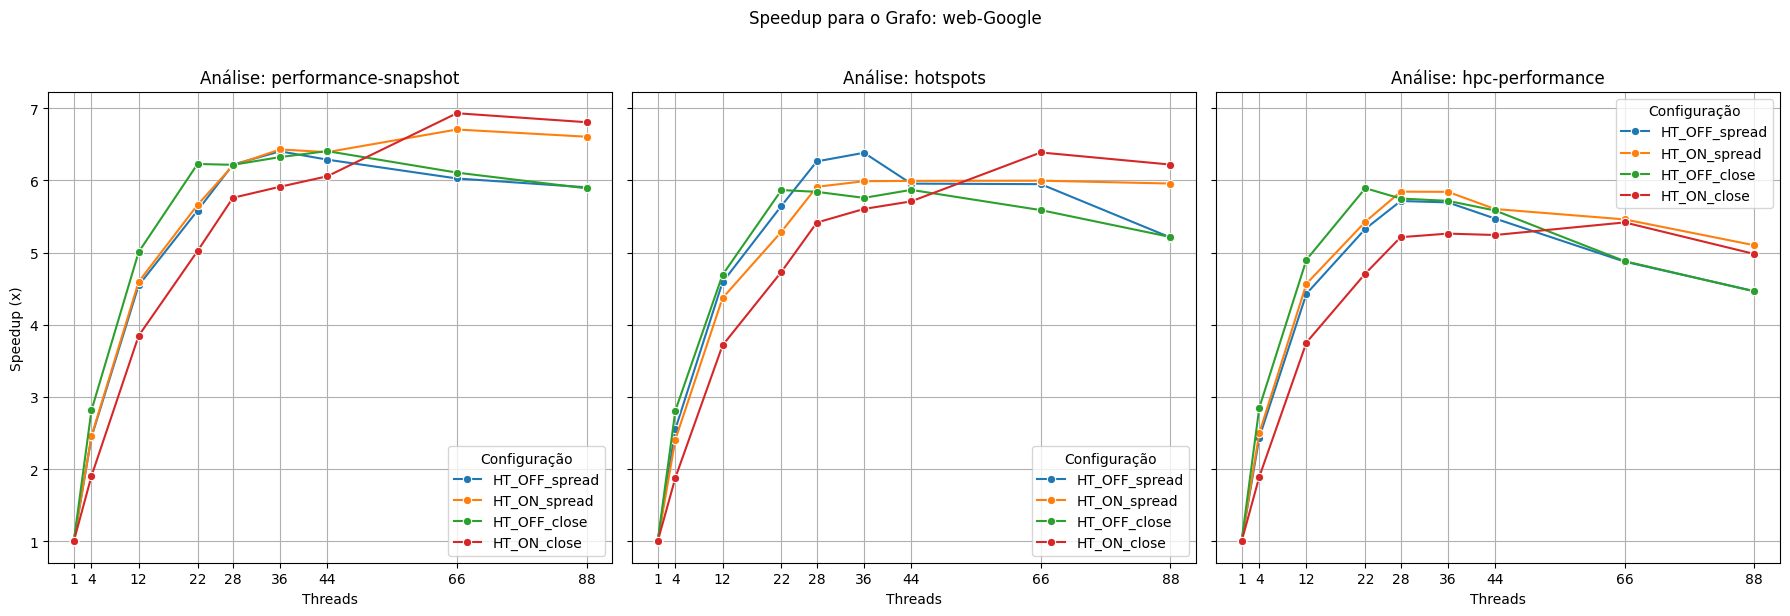

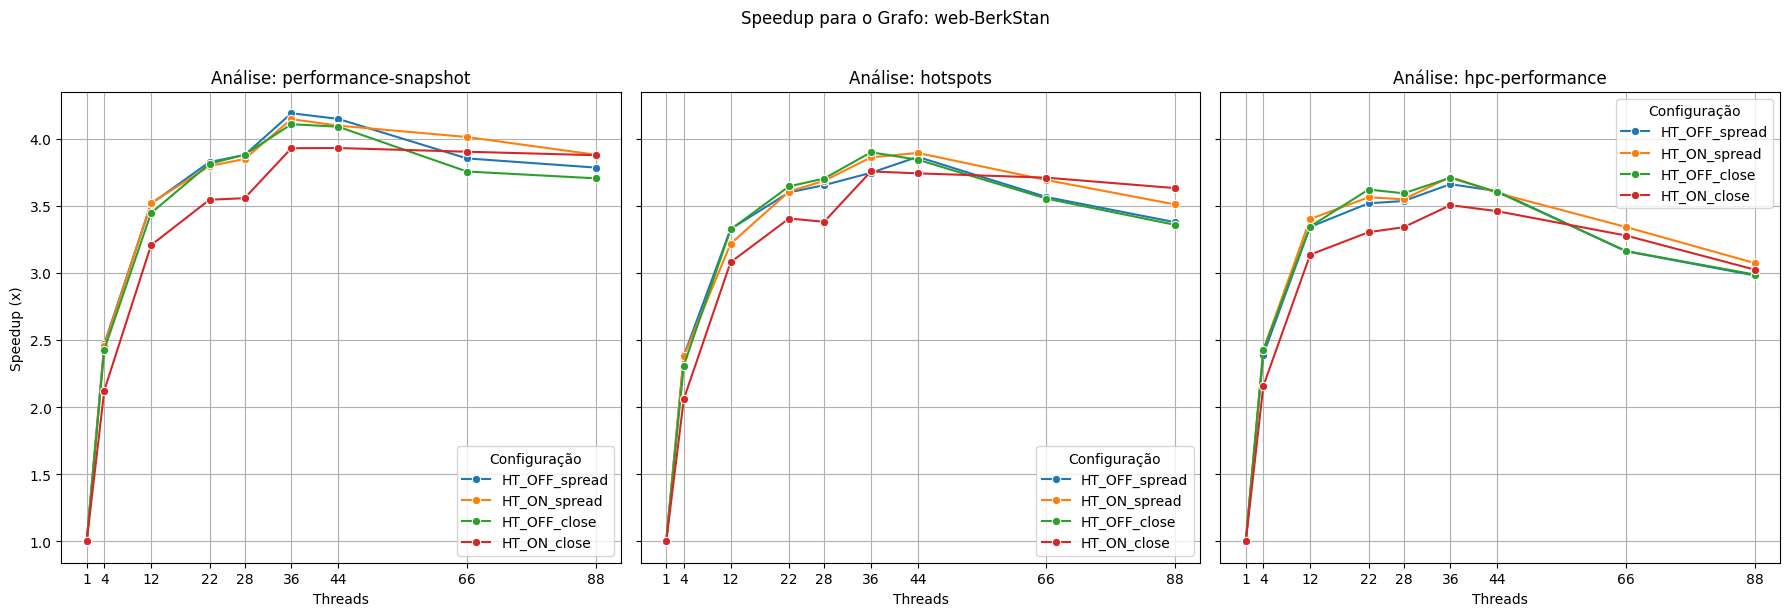

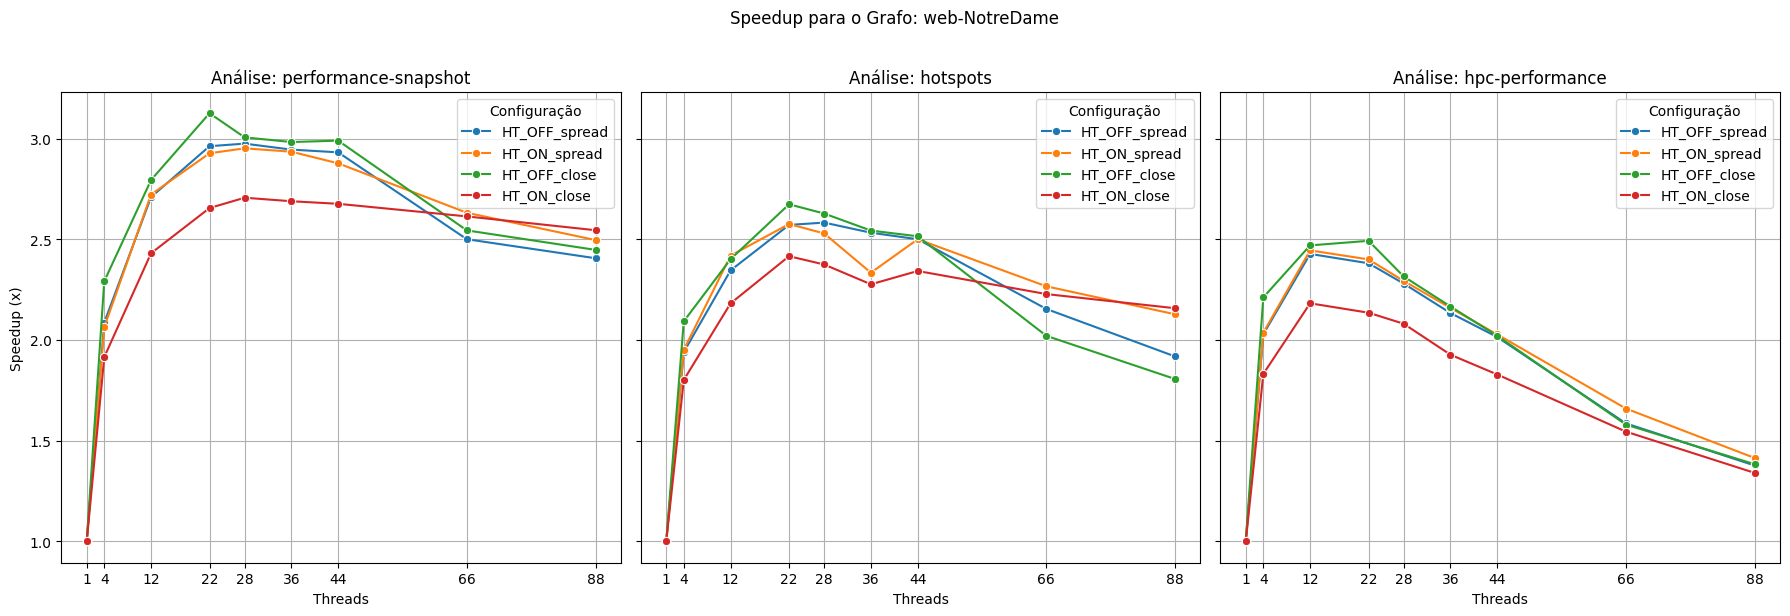

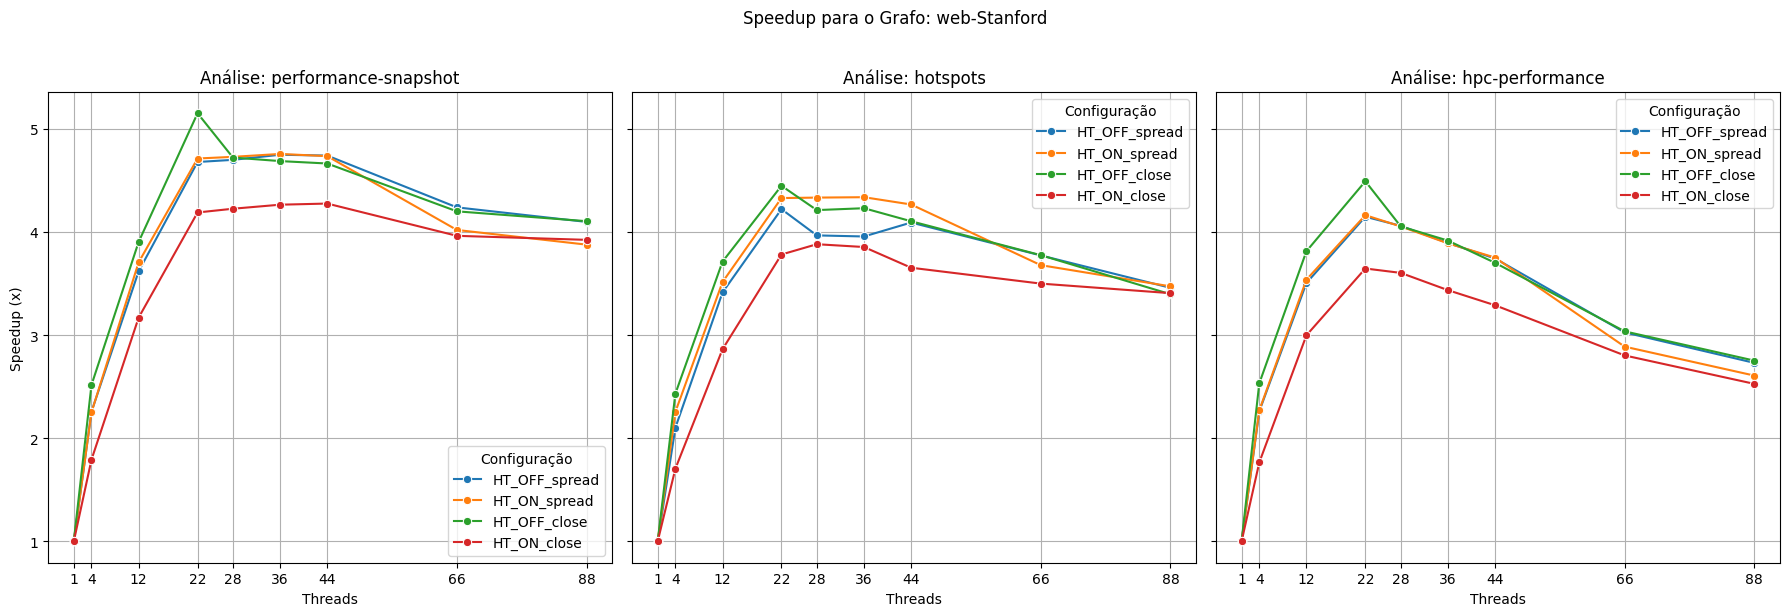

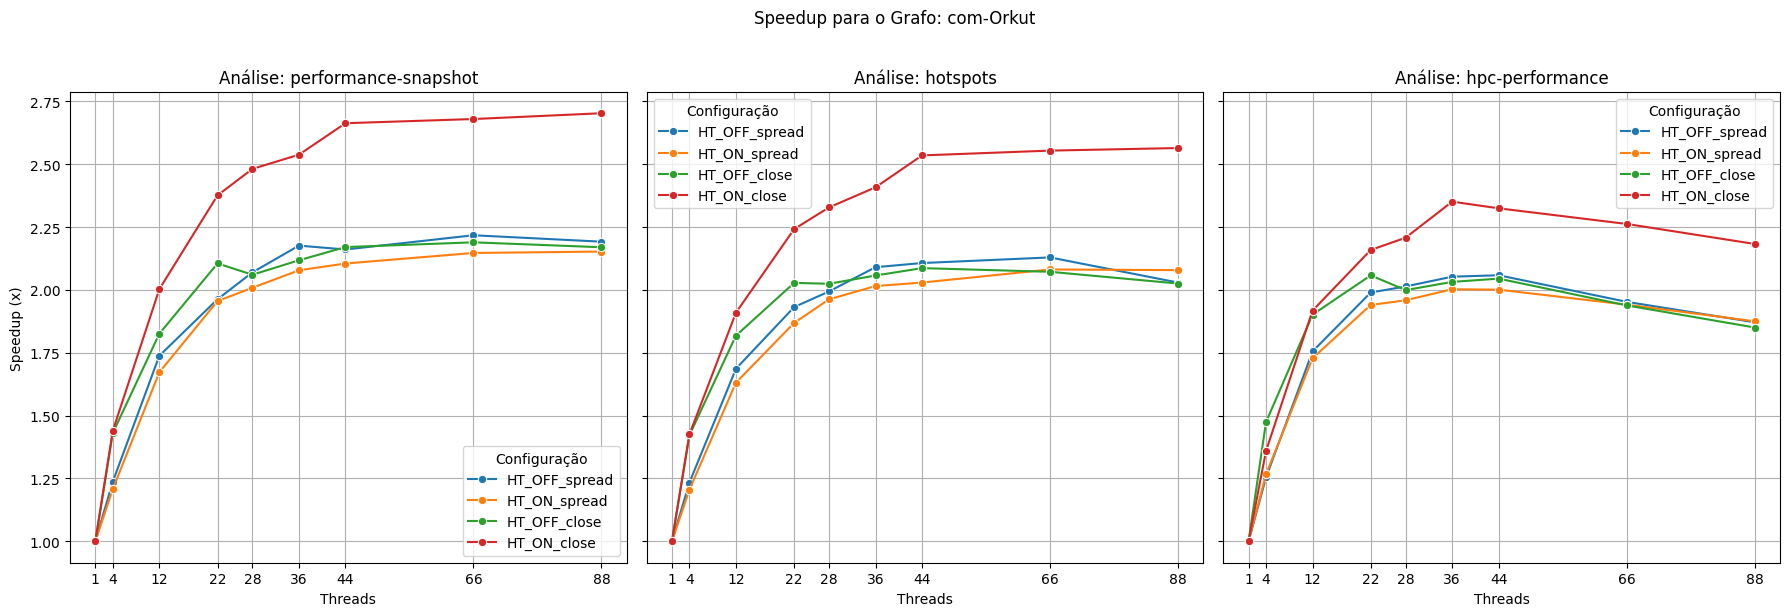

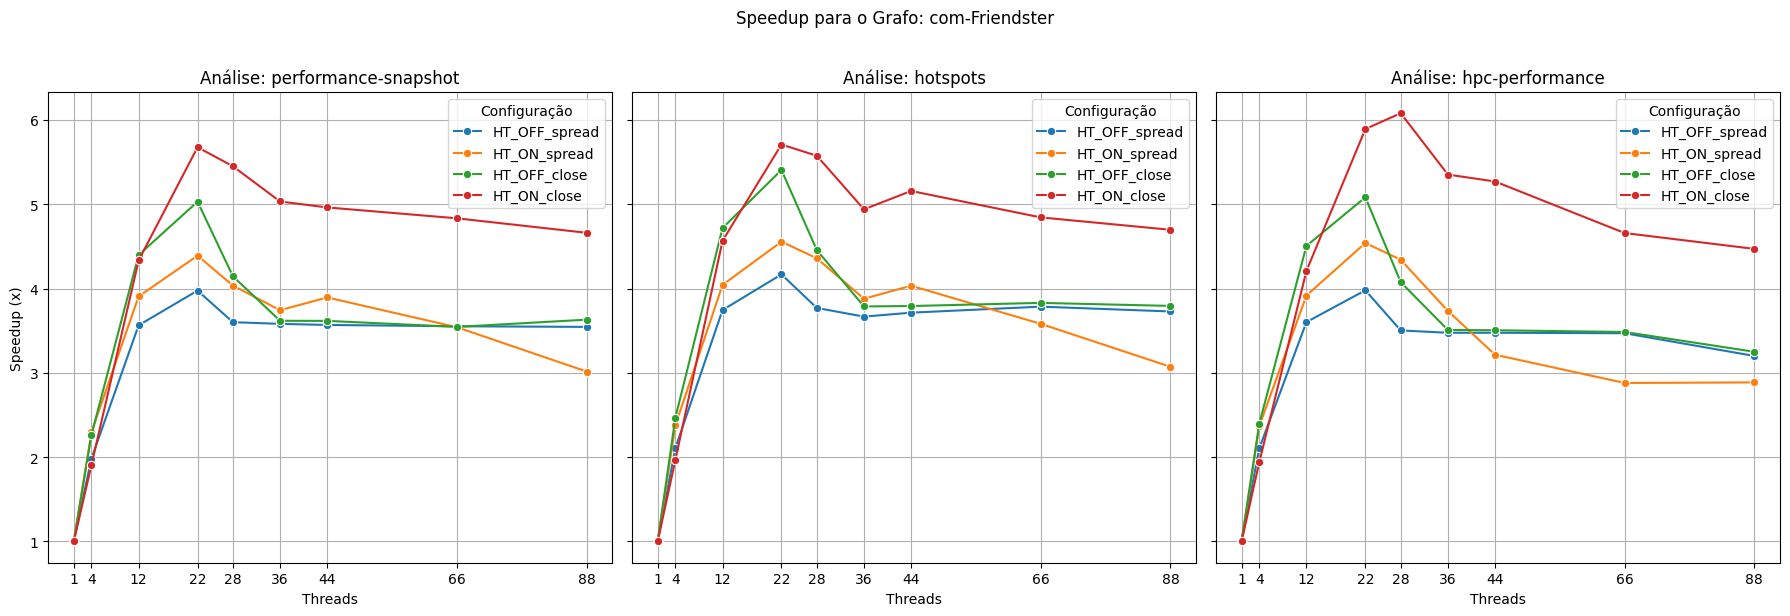

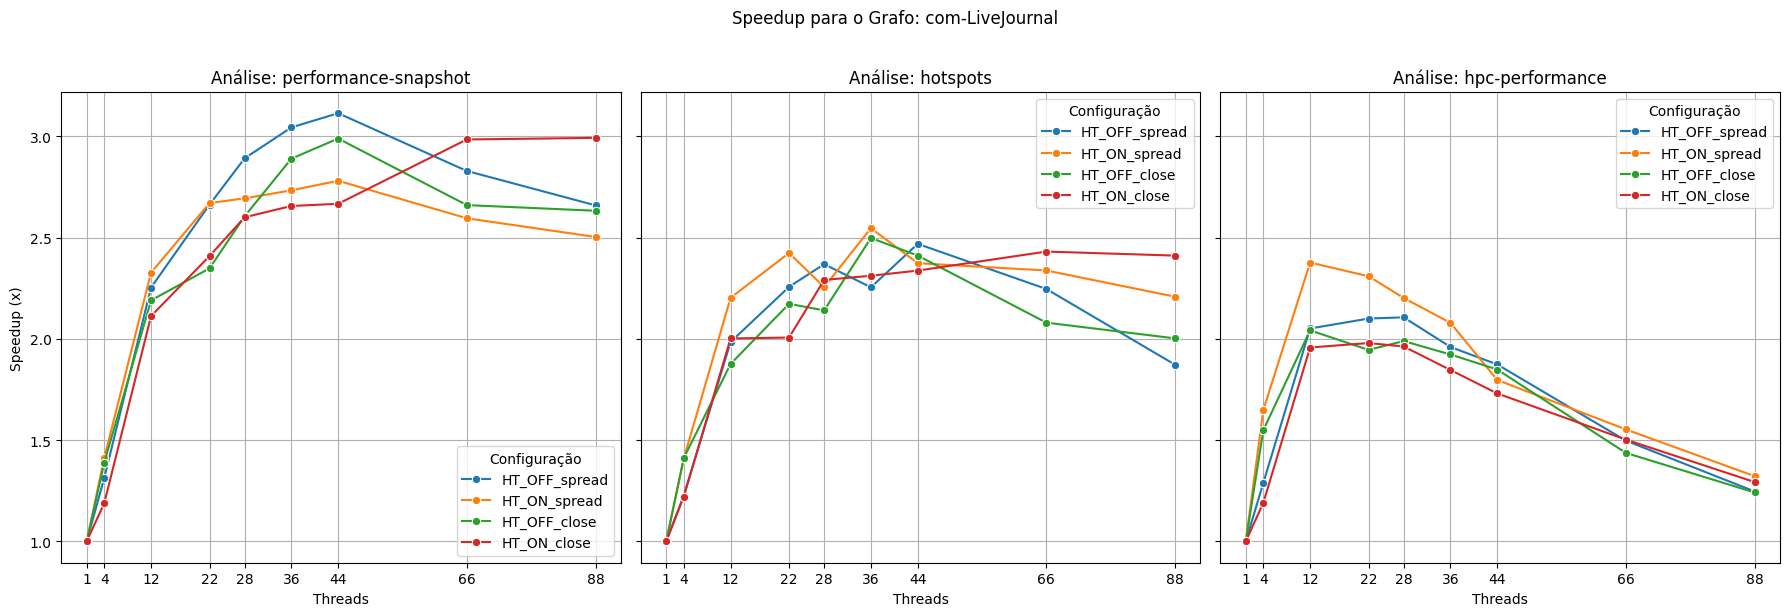

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Obtém listas únicas de grafos e tipos de análise
grafos = df_unified["GRAPH_NAME"].unique()
tipos_analise = df_unified["ANALYSIS_TYPE"].unique()

# Determina o número de colunas para cada subplot
n_cols = len(tipos_analise)

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada grafo para gerar os gráficos agrupados por tipo de análise e salvar como PDF
for grafo in grafos:
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)
    fig.suptitle(f"Speedup para o Grafo: {grafo}", y=1.02) # Add a main title for the graph

    if n_cols == 1:
        axes = [axes]

    for i, analise in enumerate(tipos_analise):
        # Filtra os dados para o grafo e tipo de análise atuais
        df_filtered = df_unified[(df_unified["GRAPH_NAME"] == grafo) & (df_unified["ANALYSIS_TYPE"] == analise)].copy()

        # Cria uma coluna combinada para hyperthreading e thread binding policy para utilizar na legenda
        df_filtered["CONFIG"] = df_filtered["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if not x else "HT_OFF") + "_" + df_filtered["THREAD_BIND_POLICY"]

        # Cria o gráfico de speedup X número de threads no subplot atual
        sns.lineplot(data=df_filtered, x="THREADS", y="SPEEDUP", hue="CONFIG", marker="o", ax=axes[i])
        axes[i].set_title(f"Análise: {analise}")
        axes[i].set_xlabel("Threads")
        axes[i].set_ylabel("Speedup (x)")
        axes[i].grid(True)
        axes[i].set_xticks(df_filtered["THREADS"].unique())
        axes[i].legend(title="Configuração")

    plt.tight_layout()
    # Salva a figura como um arquivo PDF na pasta "gráficos"
    plt.savefig(os.path.join(output_dir, f"speedup_{grafo}.pdf"))
    # Mostra a figura no notebook
    plt.show()

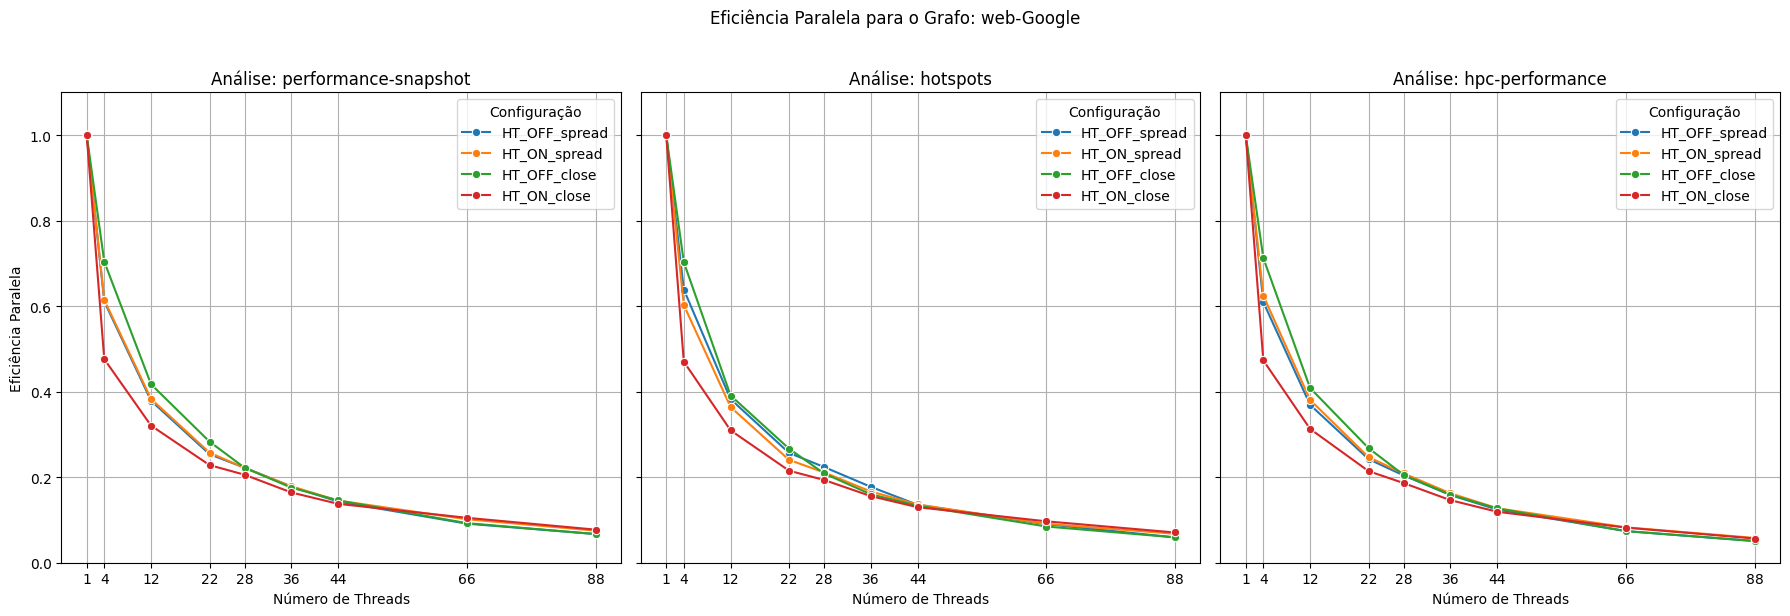

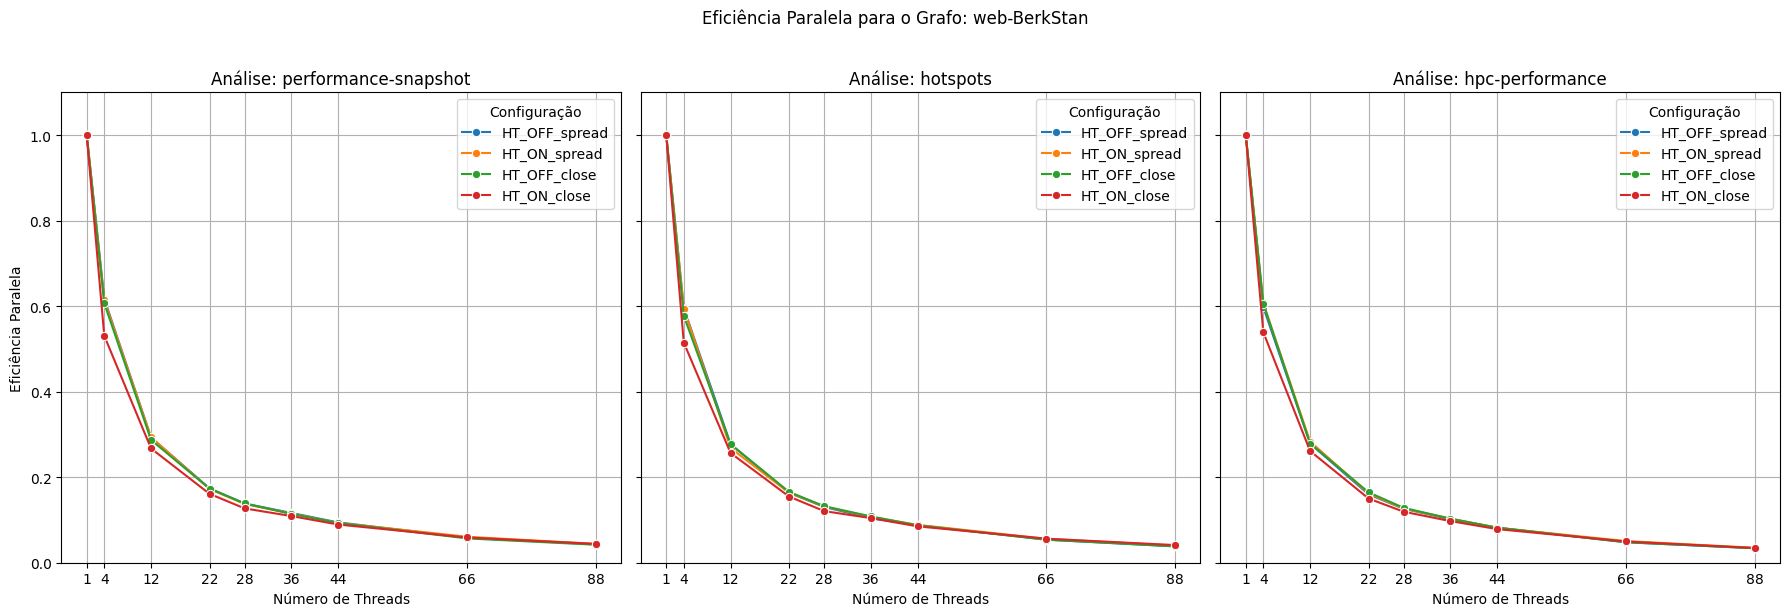

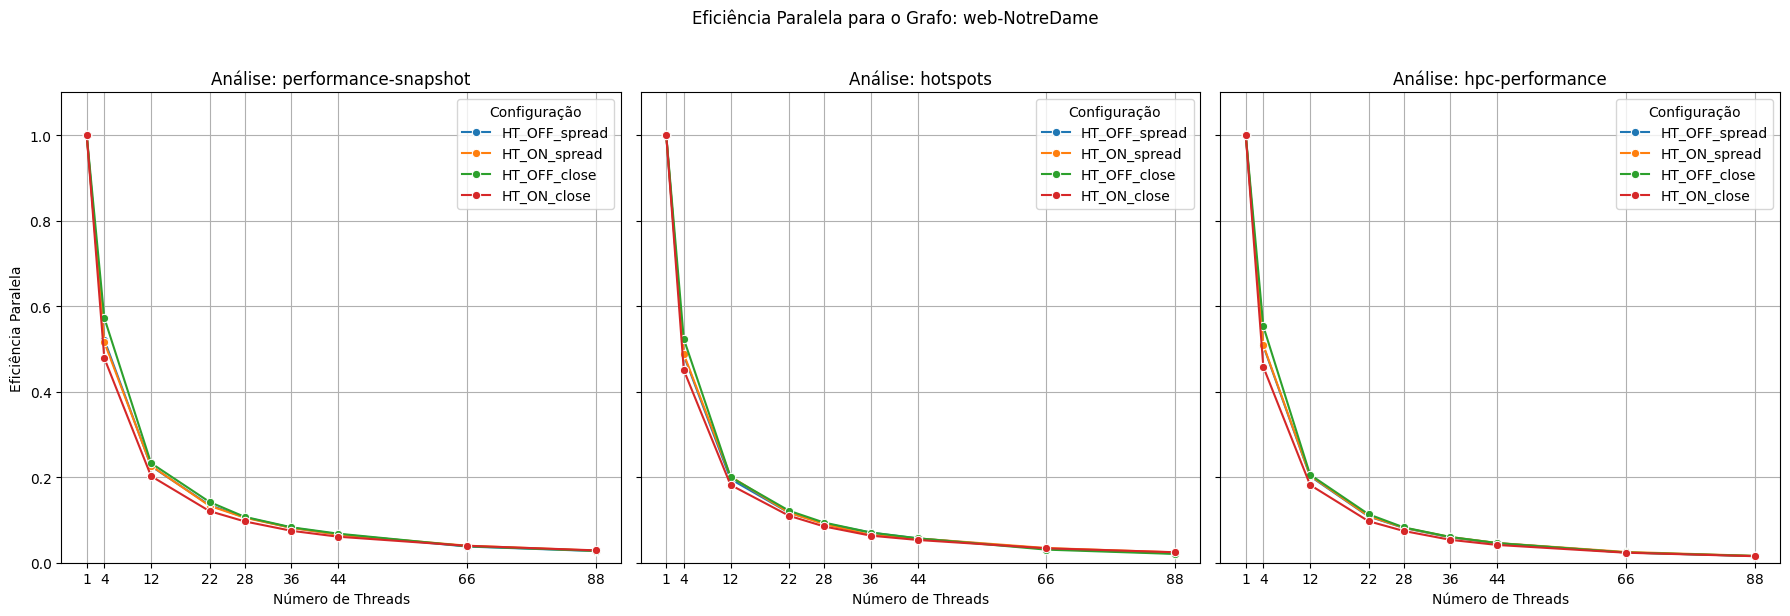

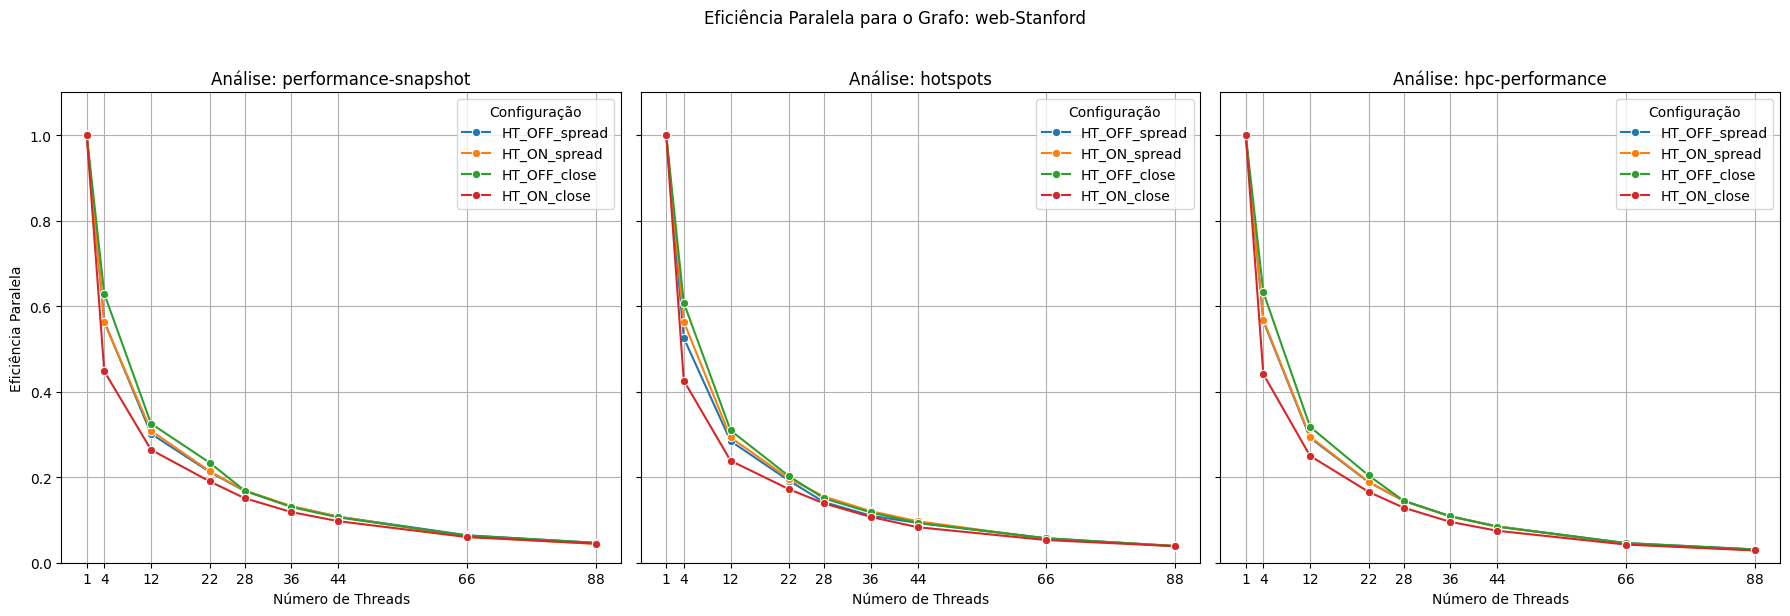

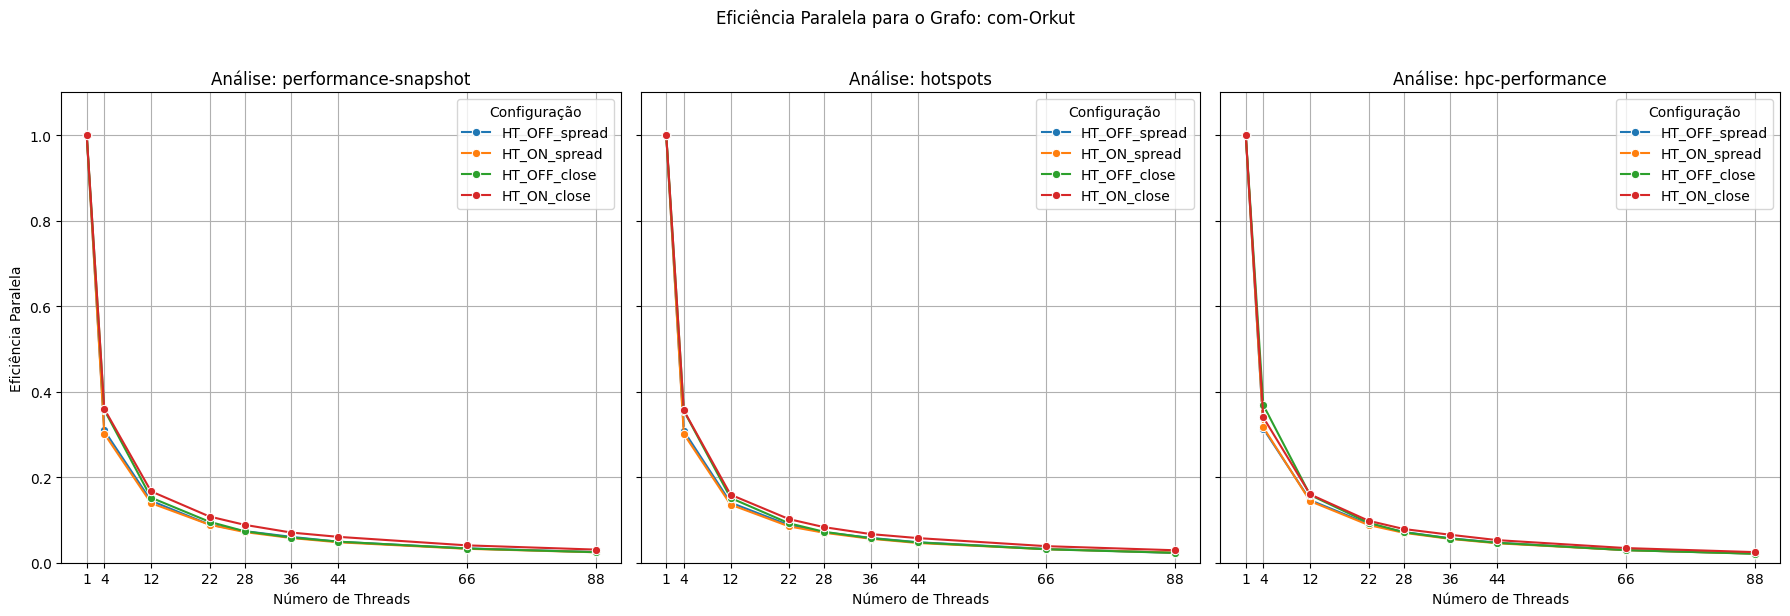

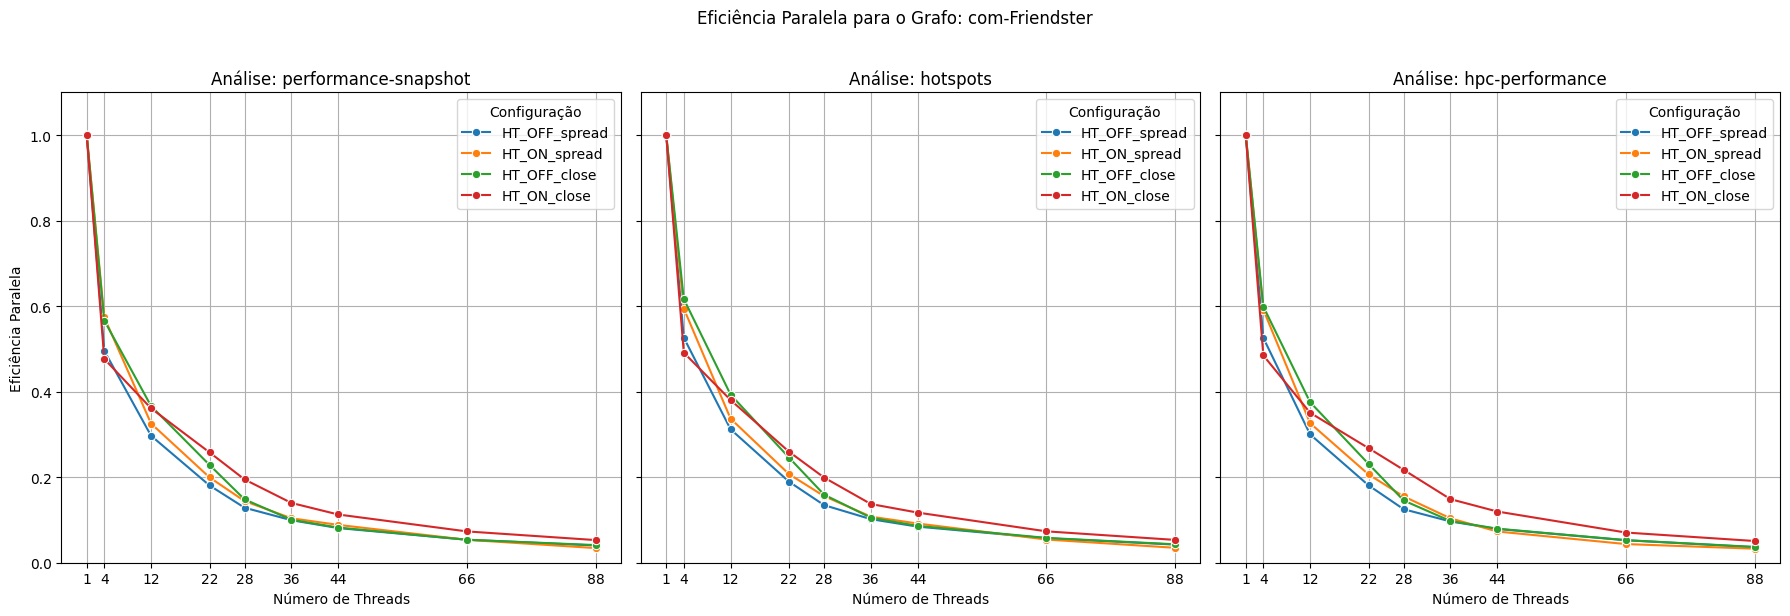

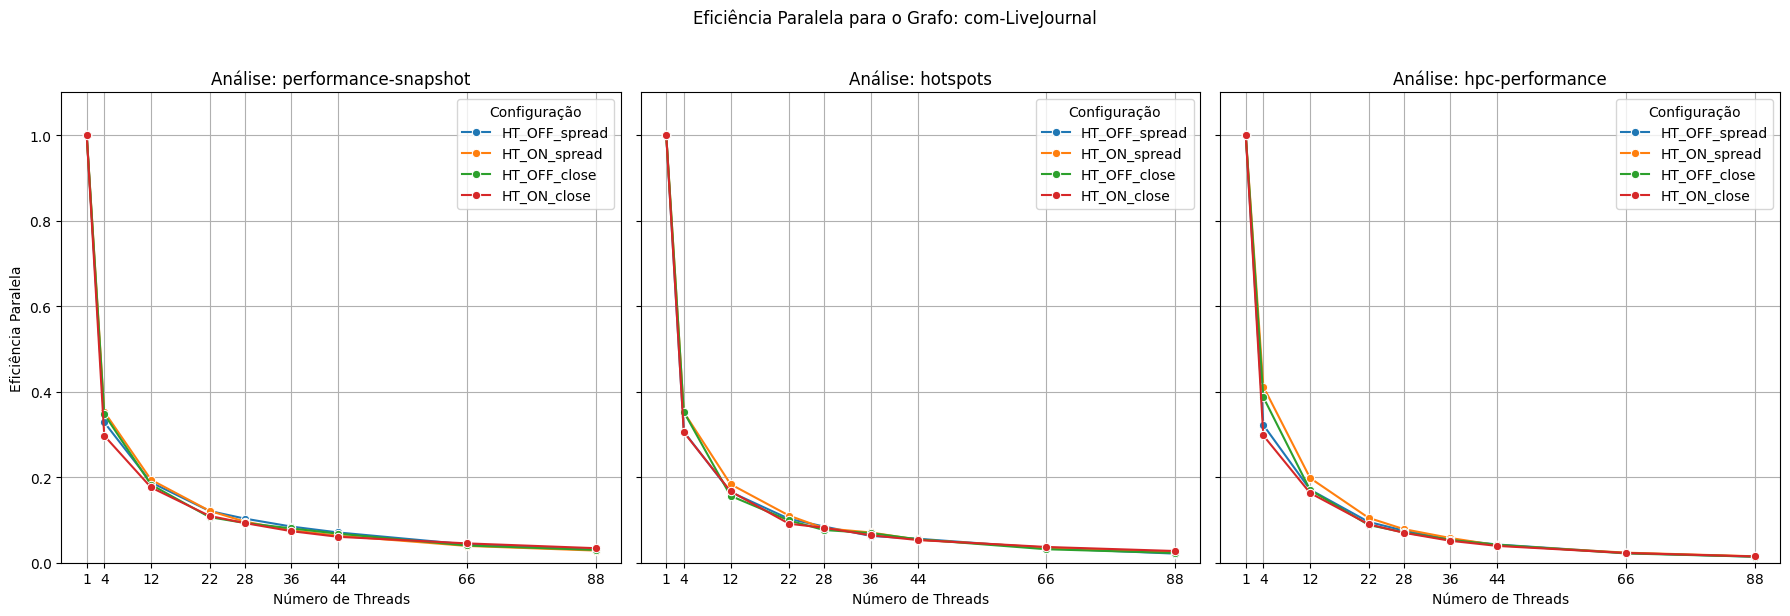

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega os resultados unificados
df_unified = pd.read_csv("unified_results.csv", sep=",")

# Obtém listas únicas de grafos e tipos de análise
grafos = df_unified["GRAPH_NAME"].unique()
tipos_analise = df_unified["ANALYSIS_TYPE"].unique()

# Determina o número de colunas pra cada subplot
n_cols = len(tipos_analise)

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada grafo pra gerar os gráficos agrupados por tipo de análise
for grafo in grafos:
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6), sharey=True)
    fig.suptitle(f"Eficiência Paralela para o Grafo: {grafo}", y=1.02) # Add a main title for the graph

    if n_cols == 1:
        axes = [axes]

    for i, analise in enumerate(tipos_analise):
        # Filtra os dados pro grafo e tipo de análise atuais
        df_filtered = df_unified[(df_unified["GRAPH_NAME"] == grafo) & (df_unified["ANALYSIS_TYPE"] == analise)].copy()

        # Cria uma coluna combinada pra hyperthreading e thread binding policy pra usar na legenda
        df_filtered["CONFIG"] = df_filtered["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if not x else "HT_OFF") + "_" + df_filtered["THREAD_BIND_POLICY"]

        # Cria o gráfico de parallel efficiency X número de threads no subplot atual
        sns.lineplot(data=df_filtered, x="THREADS", y="PARALLEL_EFFICIENCY", hue="CONFIG", marker="o", ax=axes[i])
        axes[i].set_title(f"Análise: {analise}")
        axes[i].set_xlabel("Número de Threads")
        axes[i].set_ylabel("Eficiência Paralela")
        axes[i].grid(True)
        axes[i].set_xticks(df_filtered["THREADS"].unique())
        axes[i].legend(title="Configuração")
        axes[i].set_ylim(0, 1.1)

    plt.tight_layout()
    # Salva a figura como um arquivo PDF na pasta "gráficos"
    plt.savefig(os.path.join(output_dir, f"parallel_efficiency_{grafo}.pdf"))
    # Mostra a figura no notebook
    plt.show()

In [11]:
# Encontra as melhores configurações por grafo e tipo de análise com base no maior speedup

best_configs = df_unified.loc[df_unified.groupby(['GRAPH_NAME', 'ANALYSIS_TYPE'])['SPEEDUP'].idxmax()]

# Seleciona apenas as colunas relevantes
best_configs_table = best_configs[['GRAPH_NAME', 'ANALYSIS_TYPE', 'THREADS', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY', 'SPEEDUP']]

# Mostra a tabela
print("Melhores Configurações por Grafo e Tipo de Análise (baseado no maior Speedup):")
display(best_configs_table)

Melhores Configurações por Grafo e Tipo de Análise (baseado no maior Speedup):


GRAPH_NAME         ANALYSIS_TYPE  THREADS  DISABLE_HYPERTHREADING  \
669   com-Friendster              hotspots       22                   False   
677   com-Friendster       hpc-performance       28                   False   
667   com-Friendster  performance-snapshot       22                   False   
357  com-LiveJournal              hotspots       36                   False   
341  com-LiveJournal       hpc-performance       12                   False   
360  com-LiveJournal  performance-snapshot       44                    True   
645        com-Orkut              hotspots       88                   False   
629        com-Orkut       hpc-performance       36                   False   
643        com-Orkut  performance-snapshot       88                   False   
464     web-BerkStan              hotspots       36                    True   
89      web-BerkStan       hpc-performance       36                   False   
84      web-BerkStan  performance-snapshot       36                    True   
423       web-Google              hotspots       66                   False   
400       web-Google       hpc-performance       22                    True   
421       web-Google  performance-snapshot       66                   False   
506    web-NotreDame              hotspots       22                    True   
508    web-NotreDame       hpc-performance       22                    True   
504    web-NotreDame  performance-snapshot       22                    True   
560     web-Stanford              hotspots       22                    True   
562     web-Stanford       hpc-performance       22                    True   
558     web-Stanford  performance-snapshot       22                    True   

    THREAD_BIND_POLICY   SPEEDUP  
669              close  5.708463  
677              close  6.079737  
667              close  5.676505  
357             spread  2.546151  
341             spread  2.376275  
360             spread  3.113705  
645              close  2.564436  
629              close  2.351212  
643              close  2.702868  
464              close  3.897933  
89              spread  3.715025  
84              spread  4.188802  
423              close  6.388289  
400              close  5.893040  
421              close  6.931864  
506              close  2.673734  
508              close  2.492291  
504              close  3.125940  
560              close  4.447860  
562              close  4.491840  
558              close  5.151496

# Análise Detalhada do Hardware com VTune

Com base nos dados coletados pelo Intel VTune Profiler, especificamente utilizando o tipo de análise `hpc-performance`, realizaremos uma investigação aprofundada sobre o uso da memória e a frequência da CPU. Essa análise é crucial para compreender como o algoritmo PageRank interage com os recursos de hardware da máquina *blaise*.

### Uso da Memória

Examinaremos métricas como o consumo de memória em diferentes fases da execução, a ocorrência de *cache misses* e o impacto da localidade de dados. Isso nos permitirá identificar gargalos relacionados ao acesso à memória, como a sobrecarga da largura de banda ou a ineficiência no uso do cache, que podem limitar a escalabilidade do algoritmo paralelizado. A análise de como as políticas de *thread binding* (`close` e `spread`) afetam o acesso à memória e a eficiência do cache será um ponto chave, especialmente na presença de múltiplos processadores.

### Frequência da CPU

Analisaremos a frequência de operação da CPU durante os experimentos. Embora a frequência tenha sido fixada para o máximo (`cpufreq-set -g performance`), variações na carga de trabalho e no gerenciamento de energia podem influenciar a frequência efetiva. Observaremos se há *throttling* ou se a CPU mantém uma frequência constante, garantindo que o desempenho não esteja sendo artificialmente limitado por fatores de energia ou térmicos. Além disso, correlacionaremos a frequência com o número de threads e o estado do *Hyperthreading* para entender como esses fatores impactam o desempenho do processador.

In [12]:
%cd ../stage3/

/home/thiago/Documents/perf-analysis/stage3


In [13]:
import re
import csv
import pandas as pd
from pathlib import Path
from IPython.display import display
from typing import List, Optional, Tuple

# Diretório base no Colab
BASE_DIR = Path("../stage3")
RESULTS_ROOT = BASE_DIR / "results"
OUTPUT_CSV = BASE_DIR / "hpc_hw_metrics.csv"


def extrair_infos_caminho(rel_path_parts: List[str]) -> Optional[Tuple[str, int, bool, str, int]]:
    """
    Recebe as partes do caminho relativo a 'results' e extrai:
      GRAPH_NAME, THREADS, DISABLE_HYPERTHREADING, THREAD_BIND_POLICY, RUN.

    Espera algo do tipo:
      [GRAPH_NAME, ANALYSIS_TYPE, 'threads-X',
       'ht-true|ht-false', 'bind-<policy>', 'run-N']

    ANALYSIS_TYPE é usado apenas para filtrar 'hpc-performance'.

    Nota: ht-true significa que o HT foi DESATIVADO (disable_ht=True)
          ht-false significa que o HT está ATIVADO (disable_ht=False)
    """
    if len(rel_path_parts) < 6:
        return None

    graph_name = rel_path_parts[0]
    analysis_type = rel_path_parts[1]

    if analysis_type != "hpc-performance":
        return None

    threads_dir = rel_path_parts[2]
    ht_dir = rel_path_parts[3]
    bind_dir = rel_path_parts[4]
    run_dir = rel_path_parts[5]

    # threads-X
    try:
        _, threads_str = threads_dir.split("-", 1)
        threads = int(threads_str)
    except Exception:
        return None

    # ht-true|ht-false (ou disable-ht-true|disable-ht-false para compatibilidade)
    try:
        if ht_dir.startswith("ht-"):
            # Formato: "ht-true" ou "ht-false"
            ht_value = ht_dir.split("-")[1]
            # ht-true significa que o HT foi DESATIVADO, então disable_ht = True
            # ht-false significa que o HT está ATIVADO, então disable_ht = False
            disable_ht = ht_value == "true"
        elif ht_dir.startswith("disable-ht-"):
            # Formato antigo: "disable-ht-false" -> ["disable", "ht", "false"]
            # Converte string "true"/"false" para boolean
            disable_ht_str = ht_dir.split("-")[2]
            disable_ht = disable_ht_str == "true"
        else:
            return None
    except Exception:
        return None

    # bind-<policy>
    try:
        _, thread_bind_policy = bind_dir.split("-", 1)
    except Exception:
        return None

    # run-N
    try:
        _, run_str = run_dir.split("-", 1)
        run_id = int(run_str)
    except Exception:
        return None

    return graph_name, threads, disable_ht, thread_bind_policy, run_id


def extrair_metricas_hpc(report_path: str) -> Optional[Tuple[float, float, float, float, float]]:
    """
    Lê um report.csv de hpc-performance e retorna:
      (Average CPU Frequency, Memory Bound, Cache Bound, DRAM Bound, CPI Rate)
    ou None se não conseguir extrair.
    """
    try:
        df = pd.read_csv(
            report_path,
            sep="\t",
            engine="python",
            header=0,
            on_bad_lines="skip",
        )
    except Exception as e:
        print(f"[AVISO] Falha ao ler {report_path}: {e}")
        return None

    def get_metric(nome: str) -> Optional[float]:
        if "Metric Name" not in df.columns or "Metric Value" not in df.columns:
            return None
        serie = df.loc[df["Metric Name"] == nome, "Metric Value"]
        if serie.empty:
            return None
        try:
            return float(serie.values[0])
        except (TypeError, ValueError):
            return None

    avg_cpu_freq = get_metric("Average CPU Frequency")
    mem_bound = get_metric("Memory Bound")
    cache_bound = get_metric("Cache Bound")
    dram_bound = get_metric("DRAM Bound")
    cpi_rate = get_metric("CPI Rate") # Adicionado coleta de CPI Rate

    # Atualizado para incluir cpi_rate na verificação
    if any(v is None for v in (avg_cpu_freq, mem_bound, cache_bound, dram_bound, cpi_rate)):
        # Se alguma métrica não foi encontrada, ignora este report
        return None

    return avg_cpu_freq, mem_bound, cache_bound, dram_bound, cpi_rate


# ===== Execução principal no Colab =====

if __name__ == "__main__":
    print("=" * 60)
    print("Extração de Métricas HPC do VTune")
    print("=" * 60)
    print(f"\nDiretório base: {BASE_DIR}")
    print(f"Diretório de resultados: {RESULTS_ROOT}")
    print(f"Arquivo de saída: {OUTPUT_CSV}\n")

    # Verifica se o diretório existe
    if not RESULTS_ROOT.is_dir():
        raise FileNotFoundError(
            f"Pasta de resultados não encontrada: {RESULTS_ROOT}\n"
            f"Certifique-se de que os dados estão em: {RESULTS_ROOT}"
        )

    # Conta quantos arquivos report.csv existem
    report_files = list(RESULTS_ROOT.rglob("report.csv"))
    print(f"Encontrados {len(report_files)} arquivos report.csv\n")

    # Coletar métricas por run
    linhas: List[List[object]] = []
    processados = 0
    ignorados = 0

    for report_path in report_files:
        rel_dir = report_path.parent.relative_to(RESULTS_ROOT)
        parts = list(rel_dir.parts)

        info = extrair_infos_caminho(parts)
        if info is None:
            ignorados += 1
            continue

        graph_name, threads, disable_ht, thread_bind_policy, run_id = info

        # Atualizado para incluir cpi_rate
        metricas = extrair_metricas_hpc(str(report_path))
        if metricas is None:
            ignorados += 1
            continue

        avg_cpu_freq, mem_bound, cache_bound, dram_bound, cpi_rate = metricas # Desempacota CPI Rate
        processados += 1

        # Atualizado para incluir cpi_rate na lista de linhas
        linhas.append(
            [
                graph_name,
                threads,
                disable_ht,
                thread_bind_policy,
                run_id,
                avg_cpu_freq,
                mem_bound,
                cache_bound,
                dram_bound,
                cpi_rate, # Adiciona CPI Rate
            ]
        )

    print(f"Processados: {processados} arquivos")
    print(f"Ignorados: {ignorados} arquivos\n")

    if not linhas:
        print("[INFO] Nenhuma execução hpc-performance encontrada.")
    else:
        # Converte para DataFrame e agrega por configuração (média das runs)
        # Atualizado para incluir CPI_RATE no header
        header = [
            "GRAPH_NAME",
            "THREADS",
            "DISABLE_HYPERTHREADING",
            "THREAD_BIND_POLICY",
            "RUN",
            "AVERAGE_CPU_FREQUENCY",
            "MEMORY_BOUND",
            "CACHE_BOUND",
            "DRAM_BOUND",
            "CPI_RATE", # Adiciona CPI Rate
        ]
        df = pd.DataFrame(linhas, columns=header)

        group_cols = [
            "GRAPH_NAME",
            "THREADS",
            "DISABLE_HYPERTHREADING",
            "THREAD_BIND_POLICY",
        ]
        # Atualizado para incluir CPI_RATE nas metric_cols
        metric_cols = [
            "AVERAGE_CPU_FREQUENCY",
            "MEMORY_BOUND",
            "CACHE_BOUND",
            "DRAM_BOUND",
            "CPI_RATE", # Adiciona CPI Rate
        ]

        df_group = df.groupby(group_cols, as_index=False)[metric_cols].mean()

        # Calcula o desvio padrão e adiciona ao DataFrame
        df_std = df.groupby(group_cols, as_index=False)[metric_cols].std()
        for col in metric_cols:
            df_group[f"{col}_STD"] = df_std[col]

        df_group = df_group.sort_values(
            by=["GRAPH_NAME", "THREADS", "DISABLE_HYPERTHREADING", "THREAD_BIND_POLICY"]
        )

        # Salva o CSV
        df_group.to_csv(str(OUTPUT_CSV), sep=",", index=False)

        print("=" * 60)
        print("RESULTADOS")
        print("=" * 60)
        print(f"Total de configurações hpc-performance agregadas: {len(df_group)}")
        print(f"CSV gerado em: {OUTPUT_CSV}\n")
        print("Amostra dos dados (primeiras 10 linhas):")
        print("-" * 60)

        # Usa display() no Colab para melhor visualização
        try:
            from IPython.display import display
            display(df_group.head(10))
        except ImportError:
            # Se não estiver no Colab, usa print normal
            print(df_group.head(10))

        print("\n" + "=" * 60)
        print("Estatísticas por configuração de Hyperthreading:")
        print("-" * 60)
        ht_stats = df_group.groupby("DISABLE_HYPERTHREADING").size()
        print(f"HT Desativado (True): {ht_stats.get(True, 0)} configurações")
        print(f"HT Ativado (False): {ht_stats.get(False, 0)} configurações")
        print("=" * 60)

Extração de Métricas HPC do VTune

Diretório base: ../stage3
Diretório de resultados: ../stage3/results
Arquivo de saída: ../stage3/hpc_hw_metrics.csv

Encontrados 3780 arquivos report.csv

Processados: 1260 arquivos
Ignorados: 2520 arquivos

RESULTADOS
Total de configurações hpc-performance agregadas: 252
CSV gerado em: ../stage3/hpc_hw_metrics.csv

Amostra dos dados (primeiras 10 linhas):
------------------------------------------------------------


GRAPH_NAME  THREADS  DISABLE_HYPERTHREADING THREAD_BIND_POLICY  \
0  com-Friendster        1                   False              close   
1  com-Friendster        1                   False             spread   
2  com-Friendster        1                    True              close   
3  com-Friendster        1                    True             spread   
4  com-Friendster        4                   False              close   
5  com-Friendster        4                   False             spread   
6  com-Friendster        4                    True              close   
7  com-Friendster        4                    True             spread   
8  com-Friendster       12                   False              close   
9  com-Friendster       12                   False             spread   

   AVERAGE_CPU_FREQUENCY  MEMORY_BOUND  CACHE_BOUND  DRAM_BOUND  CPI_RATE  \
0           3.596728e+09         33.50        13.64       17.04  0.791778   
1           3.596660e+09         28.34        10.44       11.96  0.612082   
2           3.596636e+09         29.20        11.88       14.00  0.662769   
3           3.596516e+09         29.26        11.50       14.14  0.667187   
4           3.575788e+09         21.56        19.56       14.96  1.148109   
5           3.572556e+09         37.18        15.28       20.26  0.729948   
6           3.298577e+09         33.08        13.90       19.06  0.696706   
7           3.577451e+09         40.62        15.96       25.08  0.849835   
8           3.101544e+09         19.72        22.06       12.38  1.202118   
9           3.089140e+09         53.38        27.28       26.12  1.100821   

   AVERAGE_CPU_FREQUENCY_STD  MEMORY_BOUND_STD  CACHE_BOUND_STD  \
0               5.752268e+05          0.273861         0.320936   
1               7.571398e+05          0.288097         0.364692   
2               4.906910e+05          0.158114         0.303315   
3               3.004476e+05          0.421900         0.533854   
4               4.347691e+05          0.598331         0.151658   
5               2.055448e+06          0.521536         0.454973   
6               6.484411e+05          0.327109         0.393700   
7               3.349430e+05          0.356371         0.472229   
8               8.977345e+05          0.834865         0.536656   
9               1.994770e+06          0.719027         0.383406   

   DRAM_BOUND_STD  CPI_RATE_STD  
0        0.194936      0.005581  
1        0.114018      0.005358  
2        0.353553      0.003058  
3        0.439318      0.004293  
4        0.288097      0.020445  
5        0.364692      0.006194  
6        0.439318      0.005316  
7        0.584808      0.004217  
8        0.521536      0.038865  
9        0.828855      0.003621


Estatísticas por configuração de Hyperthreading:
------------------------------------------------------------
HT Desativado (True): 126 configurações
HT Ativado (False): 126 configurações


In [14]:

df_hpc_performance_only = df_unified[df_unified['ANALYSIS_TYPE'] == 'hpc-performance']
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')
df_hpc_metrics

GRAPH_NAME  THREADS  DISABLE_HYPERTHREADING THREAD_BIND_POLICY  \
0    com-Friendster        1                   False              close   
1    com-Friendster        1                   False             spread   
2    com-Friendster        1                    True              close   
3    com-Friendster        1                    True             spread   
4    com-Friendster        4                   False              close   
..              ...      ...                     ...                ...   
247    web-Stanford       66                    True             spread   
248    web-Stanford       88                   False              close   
249    web-Stanford       88                   False             spread   
250    web-Stanford       88                    True              close   
251    web-Stanford       88                    True             spread   

     AVERAGE_CPU_FREQUENCY  MEMORY_BOUND  CACHE_BOUND  DRAM_BOUND  CPI_RATE  \
0             3.596728e+09         33.50        13.64       17.04  0.791778   
1             3.596660e+09         28.34        10.44       11.96  0.612082   
2             3.596636e+09         29.20        11.88       14.00  0.662769   
3             3.596516e+09         29.26        11.50       14.14  0.667187   
4             3.575788e+09         21.56        19.56       14.96  1.148109   
..                     ...           ...          ...         ...       ...   
247           2.892288e+09         40.86        93.96        0.20  1.221717   
248           2.816718e+09         16.84        28.00        0.00  2.391600   
249           2.816593e+09         15.64        25.80        0.00  2.419292   
250           2.898704e+09         41.08        99.02        0.00  1.262484   
251           2.900939e+09         40.48       100.00        0.14  1.267456   

     AVERAGE_CPU_FREQUENCY_STD  MEMORY_BOUND_STD  CACHE_BOUND_STD  \
0                 5.752268e+05          0.273861         0.320936   
1                 7.571398e+05          0.288097         0.364692   
2                 4.906910e+05          0.158114         0.303315   
3                 3.004476e+05          0.421900         0.533854   
4                 4.347691e+05          0.598331         0.151658   
..                         ...               ...              ...   
247               3.708071e+06          3.342604         4.844894   
248               2.457919e+06          1.582087         1.542725   
249               3.251139e+06          1.613382         2.573908   
250               3.205063e+06          5.953738         2.191347   
251               8.595466e+06          4.225754         0.000000   

     DRAM_BOUND_STD  CPI_RATE_STD  
0          0.194936      0.005581  
1          0.114018      0.005358  
2          0.353553      0.003058  
3          0.439318      0.004293  
4          0.288097      0.020445  
..              ...           ...  
247        0.447214      0.009346  
248        0.000000      0.005708  
249        0.000000      0.005928  
250        0.000000      0.004014  
251        0.313050      0.004342  

[252 rows x 14 columns]

### Análise do Memory Bound por Número de Threads

Esta seção apresenta a análise do *Memory Bound* obtida a partir dos dados coletados pelo Intel VTune (`hpc_hw_metrics.csv`). O *Memory Bound* indica a porcentagem de tempo que a CPU passa esperando por dados da memória. Um alto valor de *Memory Bound* sugere que a performance da aplicação está sendo limitada pelo acesso à memória.

Os gráficos abaixo mostram como o *Memory Bound* varia com o número de threads, considerando as configurações de *Hyperthreading* e *Thread Bind Policy*. Esta análise é crucial para identificar gargalos de memória e entender o impacto dessas configurações na eficiência do acesso aos dados.

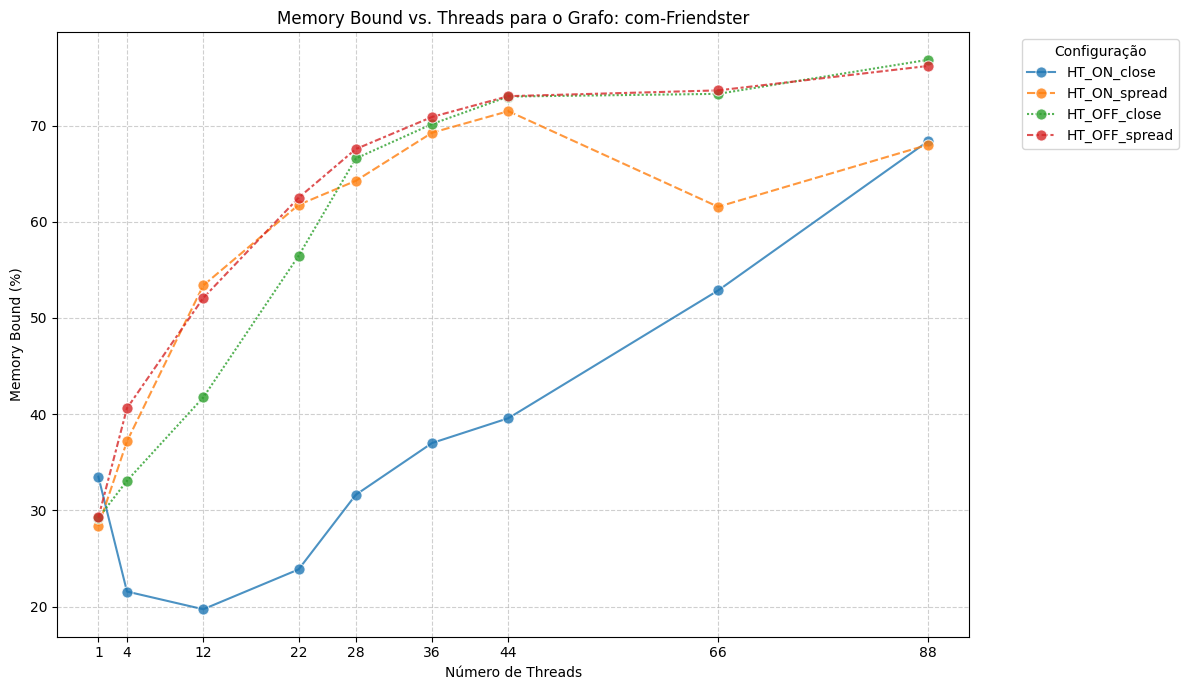

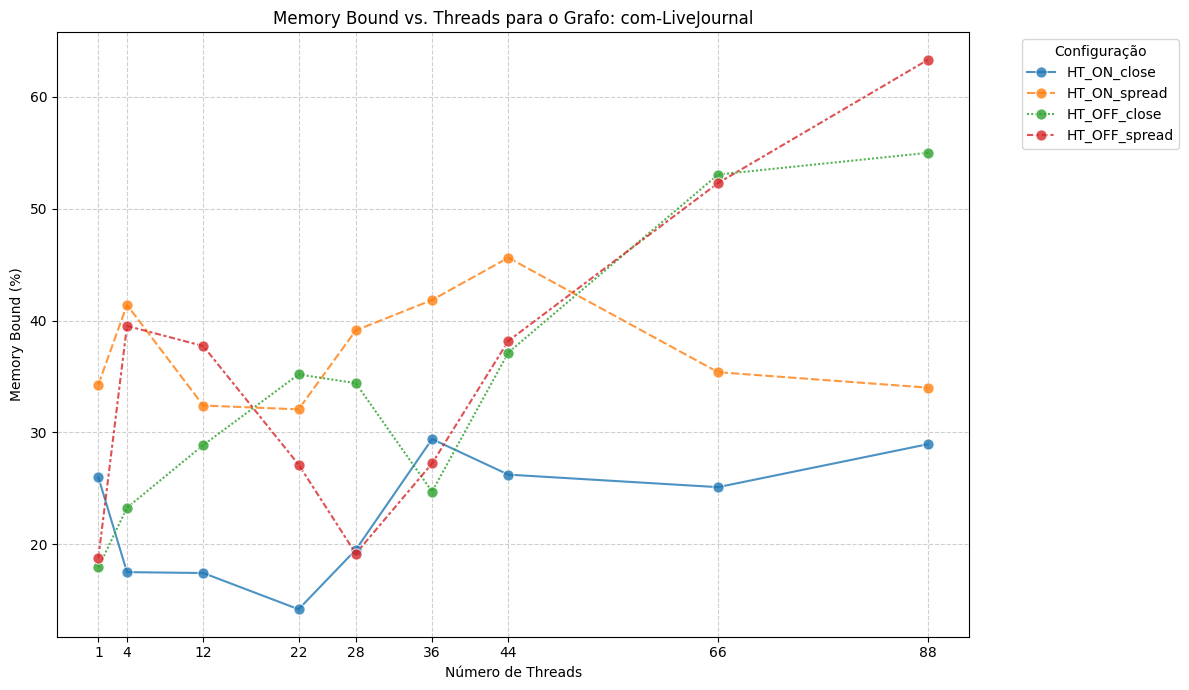

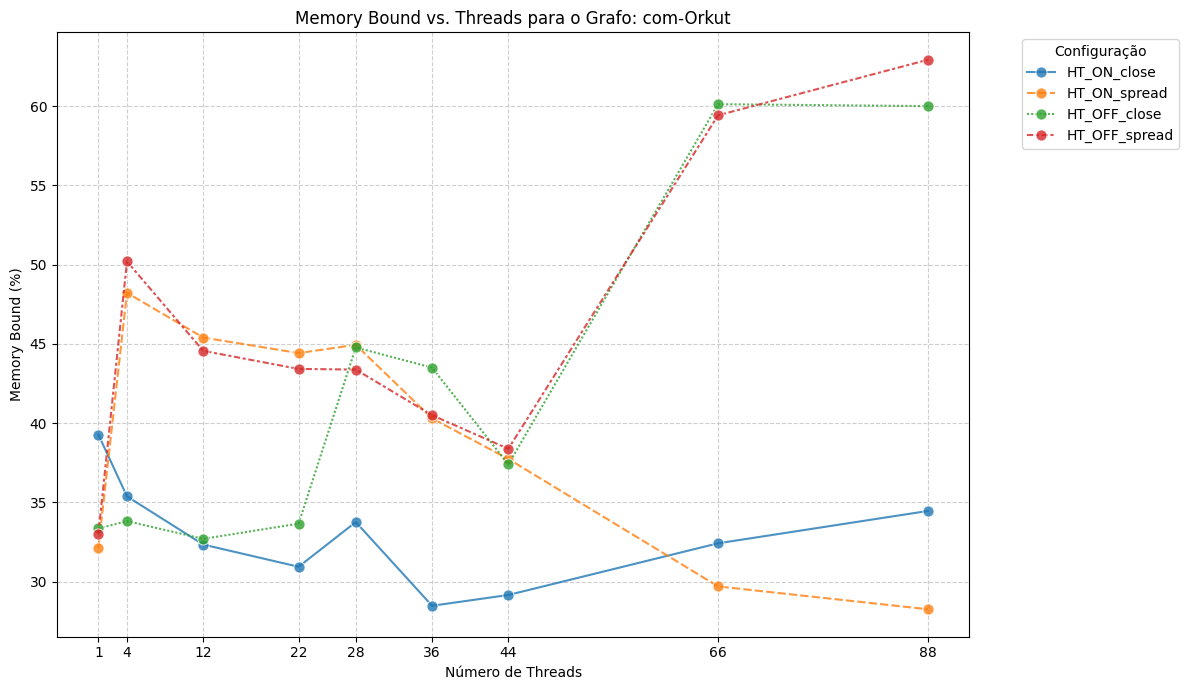

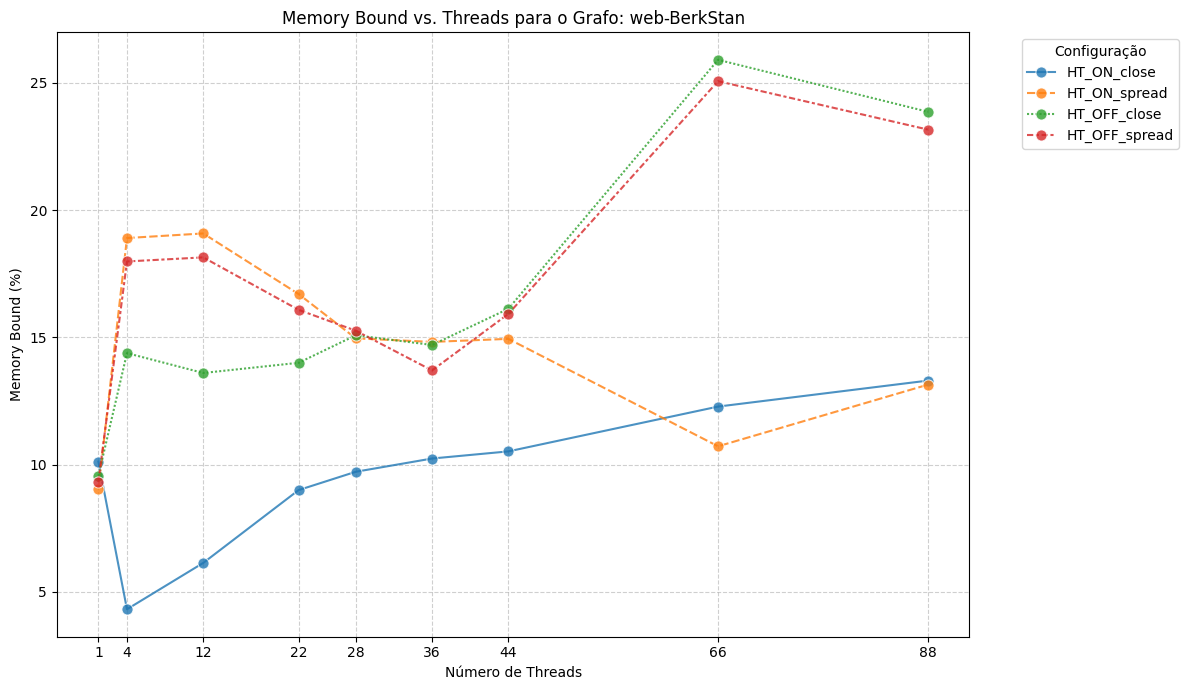

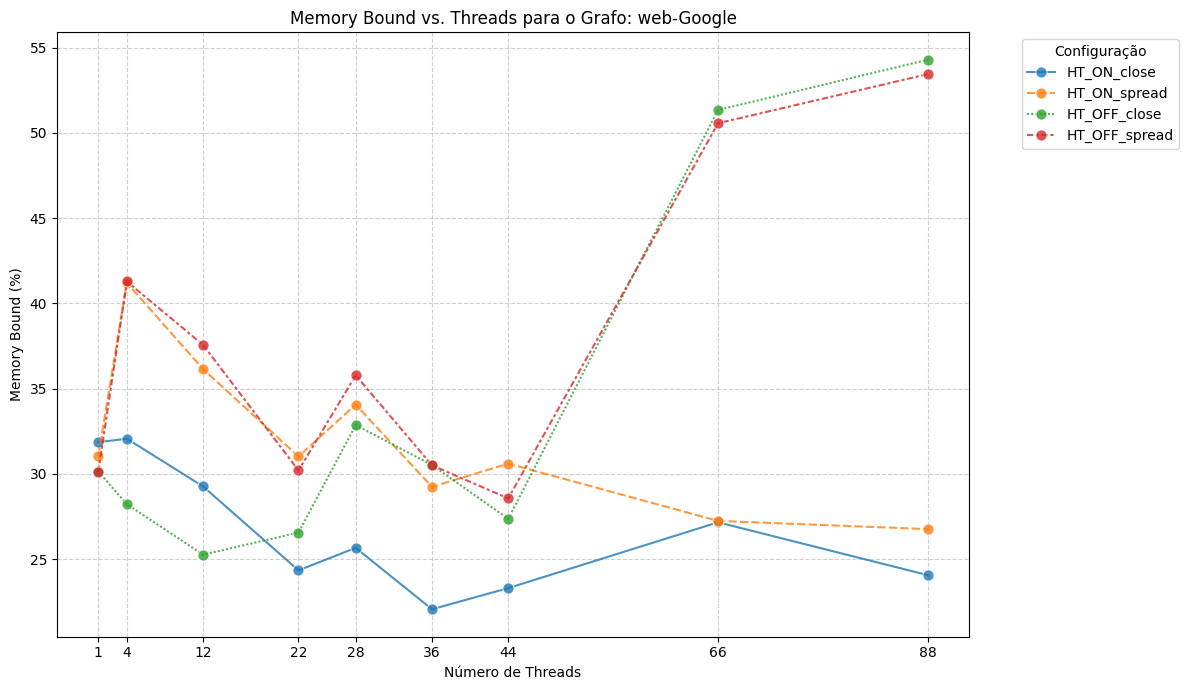

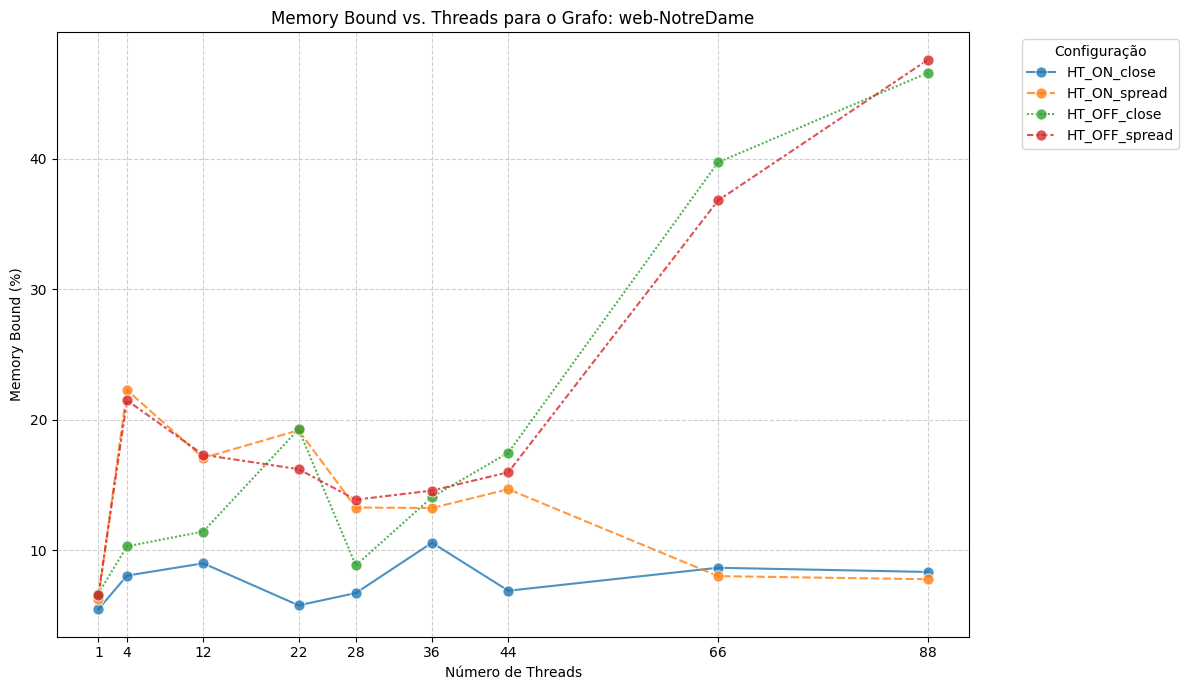

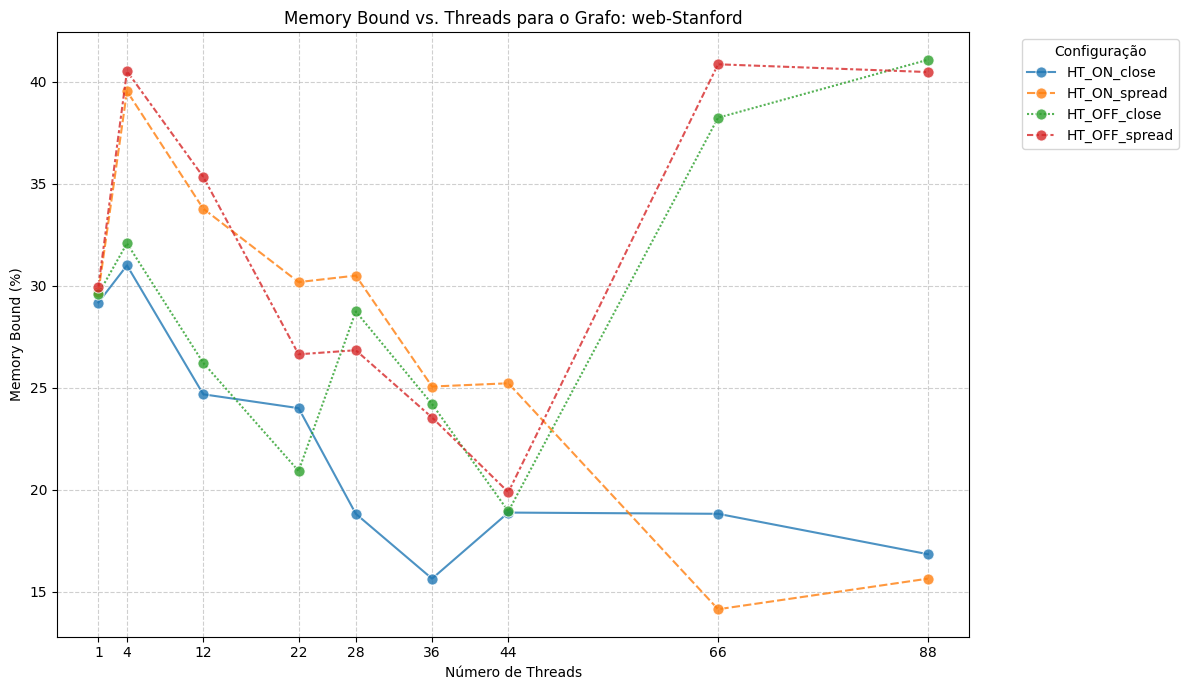

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega df_hpc_metrics (já carregado anteriormente, mas para garantir)
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')

# Cria uma coluna combinada para hyperthreading e thread binding policy para utilizar na legenda
df_hpc_metrics["CONFIG"] = df_hpc_metrics["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if x == False else "HT_OFF") + "_" + df_hpc_metrics["THREAD_BIND_POLICY"]

# Obtém listas únicas de grafos
grafos = df_hpc_metrics["GRAPH_NAME"].unique()

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada grafo para gerar os gráficos
for grafo in grafos:
    df_filtered_graph = df_hpc_metrics[df_hpc_metrics["GRAPH_NAME"] == grafo].copy()

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_filtered_graph,
        x="THREADS",
        y="MEMORY_BOUND",
        hue="CONFIG",
        style="CONFIG",
        marker="o",
        markersize=8,
        alpha=0.8,
        errorbar=None # Remove o intervalo de confiança sombreado
    )

    plt.title(f"Memory Bound vs. Threads para o Grafo: {grafo}")
    plt.xlabel("Número de Threads")
    plt.ylabel("Memory Bound (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(df_filtered_graph["THREADS"].unique())
    plt.legend(title="Configuração", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # Salva a figura como um arquivo PDF na pasta "gráficos"
    plt.savefig(os.path.join(output_dir, f"memory_bound_vs_threads_{grafo}.pdf"))
    # Mostra a figura no notebook
    plt.show()

### Análise de Frequência da CPU, Cache Bound e DRAM Bound por Número de Threads

Nesta seção, estenderemos a análise de hardware para outras métricas cruciais obtidas pelo Intel VTune (`hpc_hw_metrics.csv`):

- **Average CPU Frequency**: Mostra a frequência média de operação da CPU. Embora tenhamos fixado o governor para `performance`, é importante verificar se a frequência se mantém estável ou se há quedas devido a fatores como *throttling* térmico.
- **Cache Bound**: Indica a porcentagem de tempo que a CPU gasta esperando por dados da hierarquia de cache (L1, L2, L3). Um alto valor sugere gargalos relacionados ao cache, como *cache misses* excessivos ou concorrência pelo acesso ao cache.
- **DRAM Bound**: Representa a porcentagem de tempo que a CPU espera por dados da memória principal (DRAM). Similar ao *Memory Bound*, mas focado especificamente na memória principal, pode indicar sobrecarga na largura de banda da memória.

Os gráficos a seguir ilustrarão como cada uma dessas métricas se comporta em função do número de threads, das configurações de *Hyperthreading* e das políticas de *Thread Bind Policy* para cada grafo.

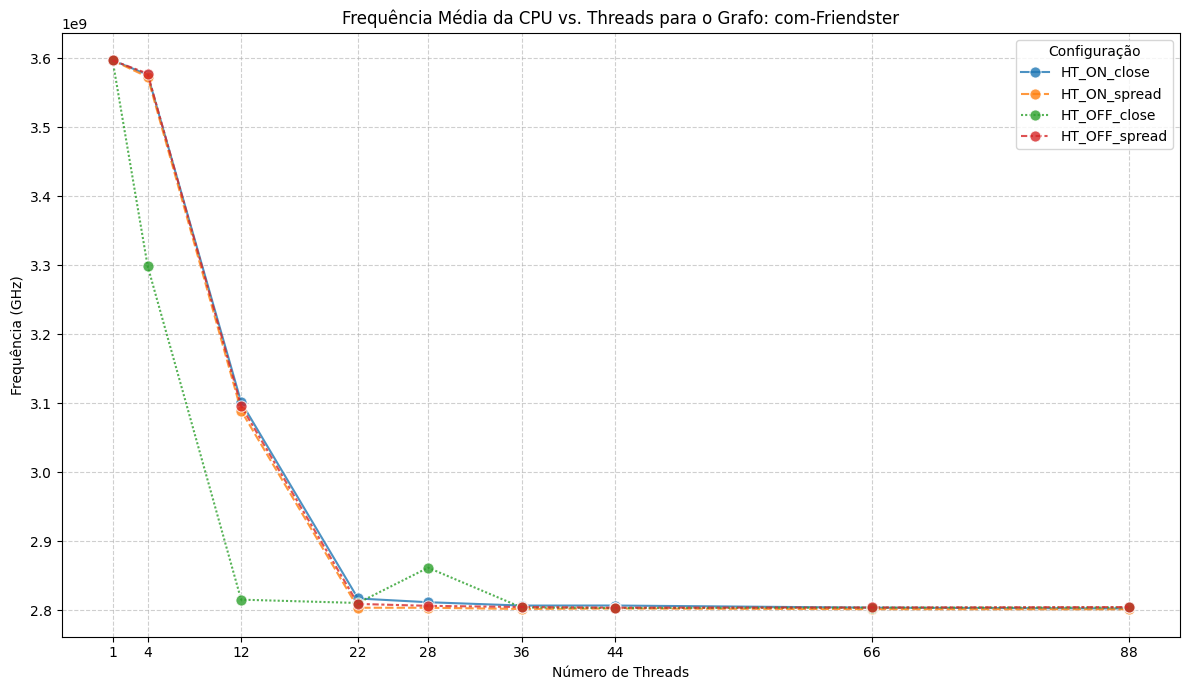

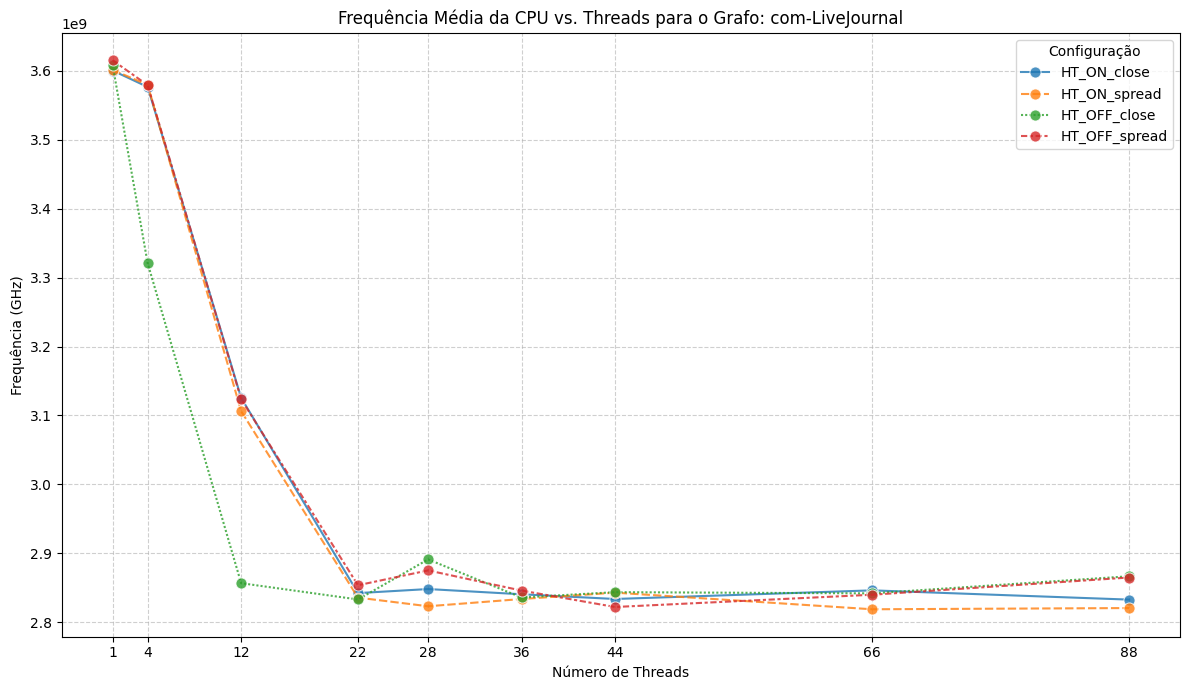

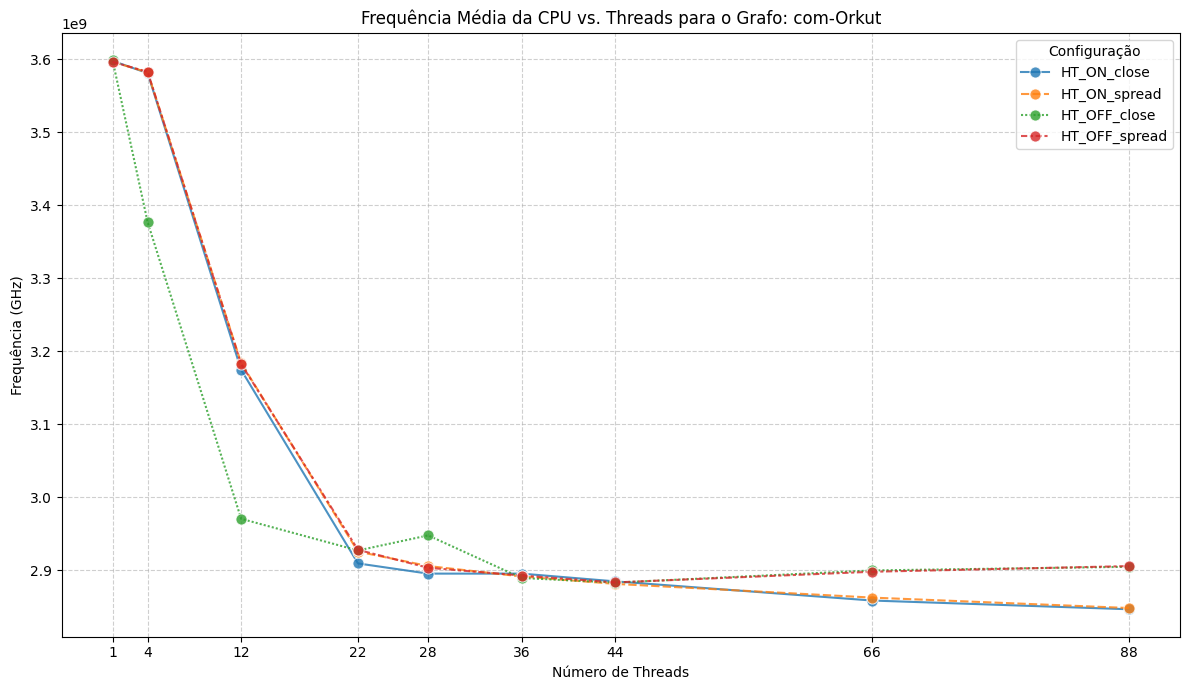

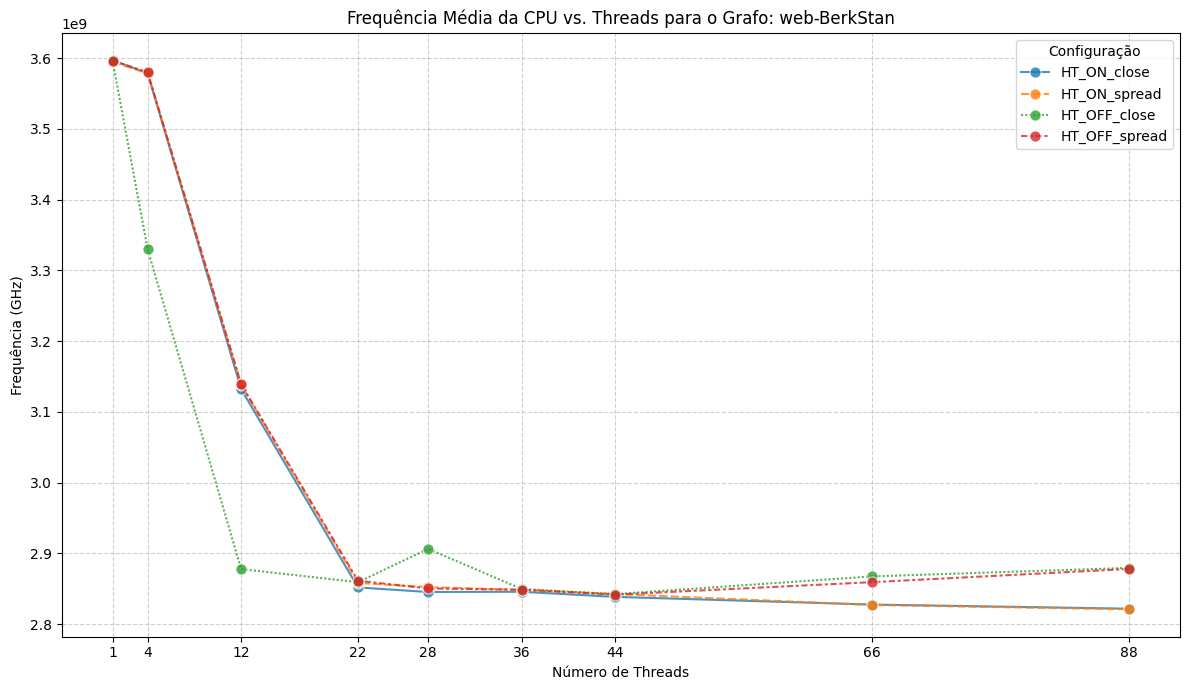

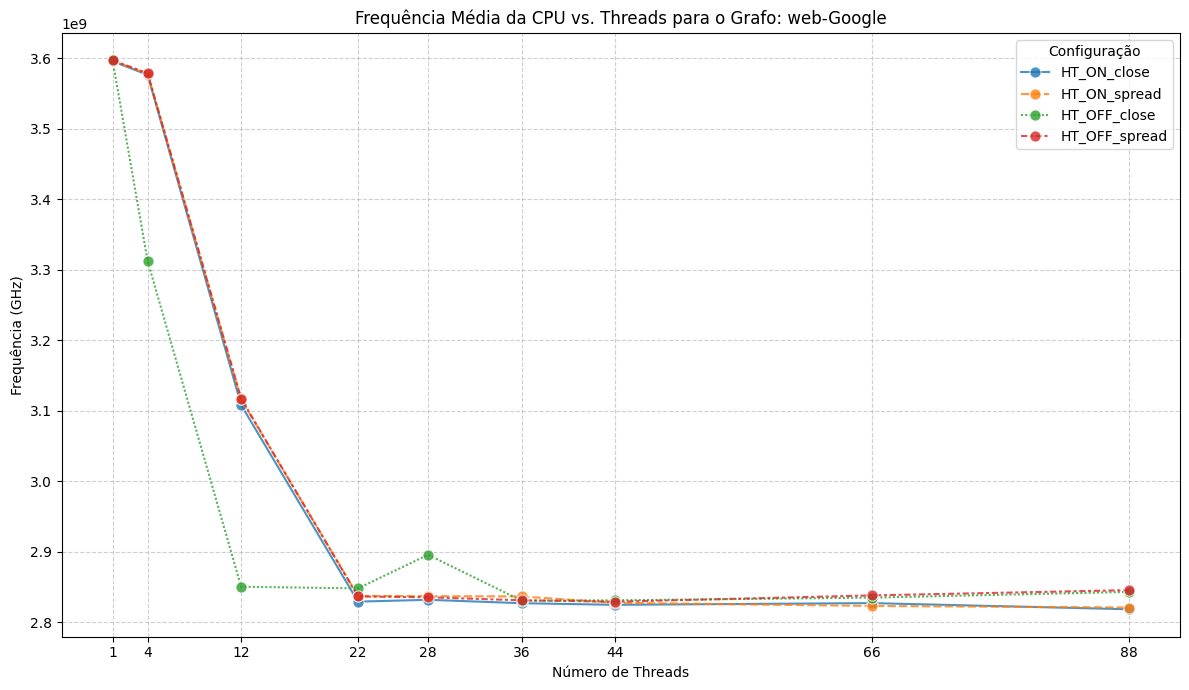

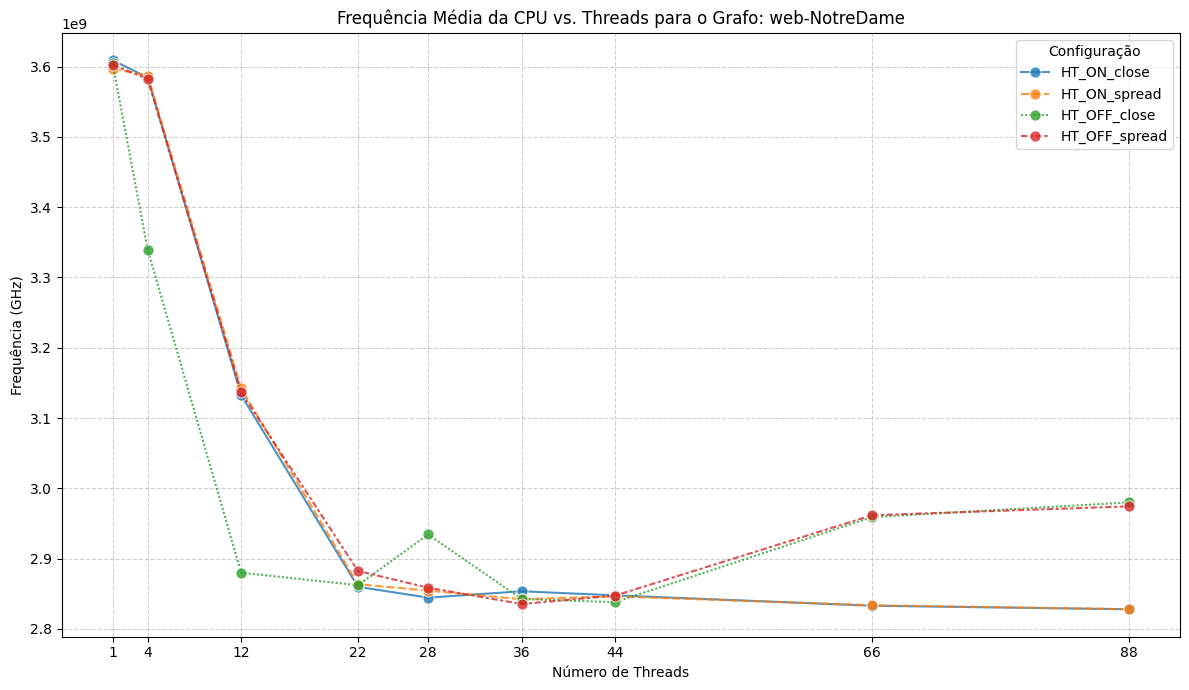

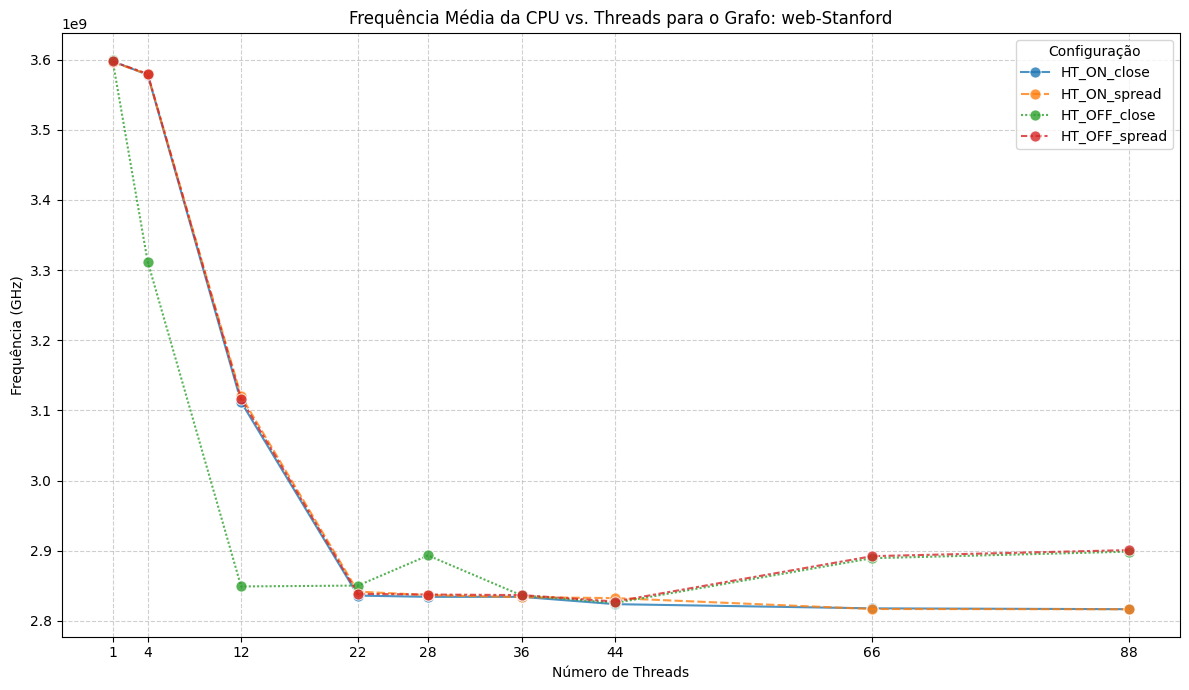

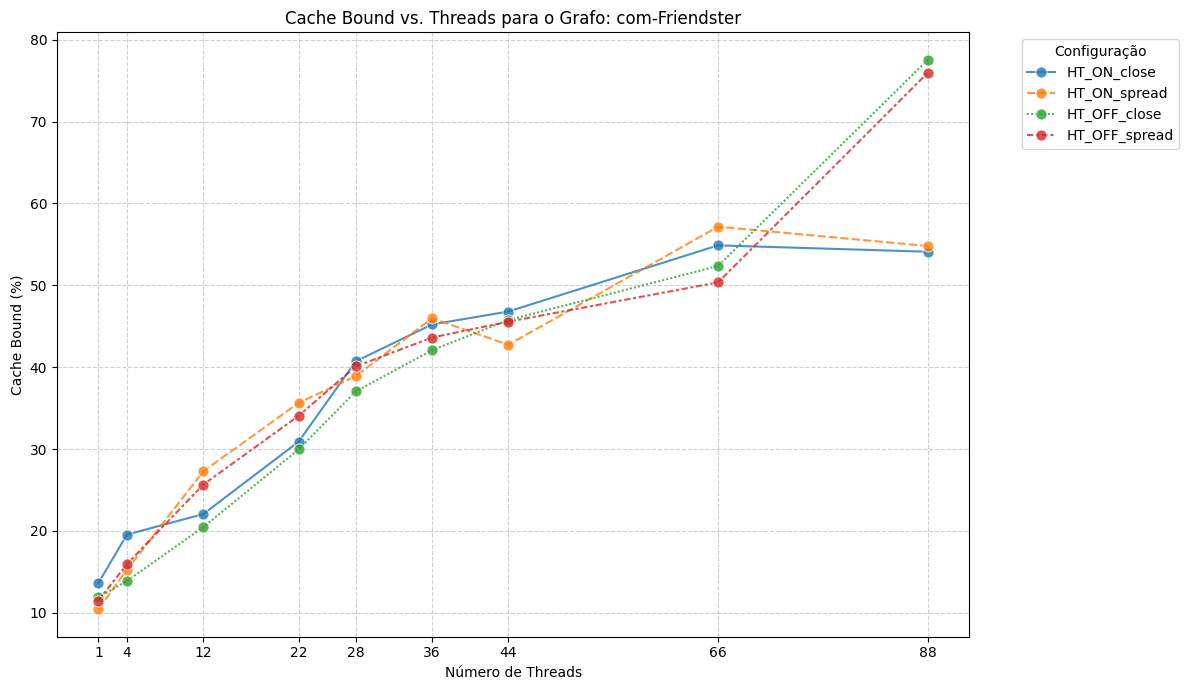

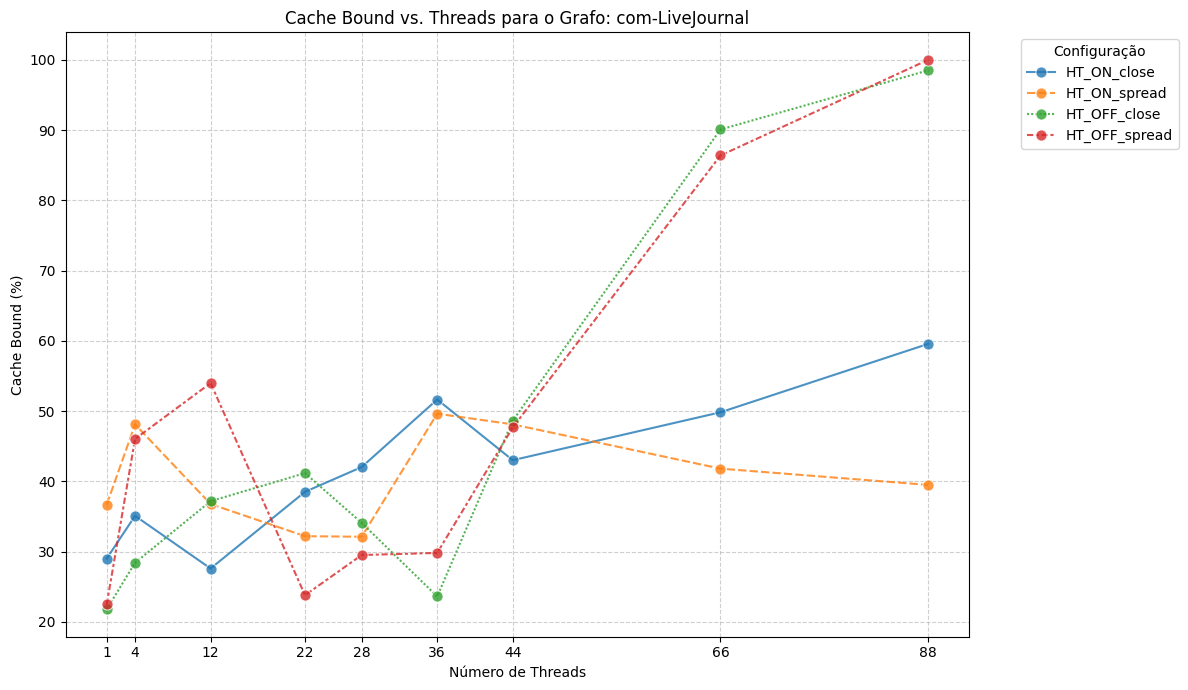

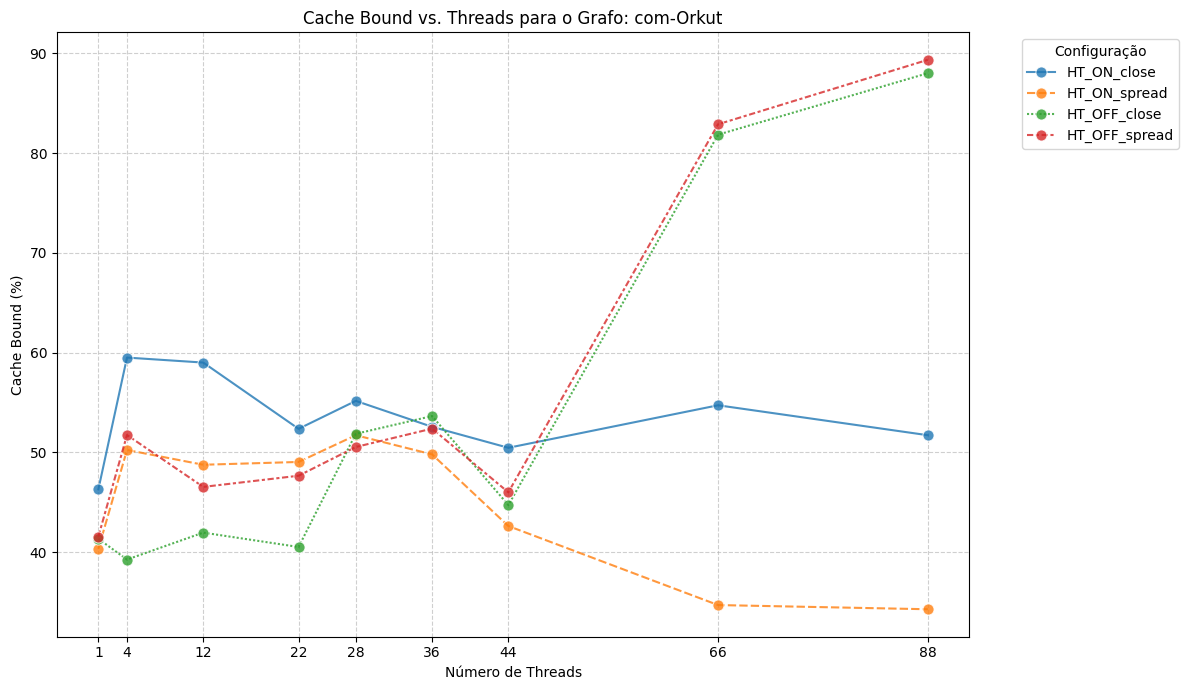

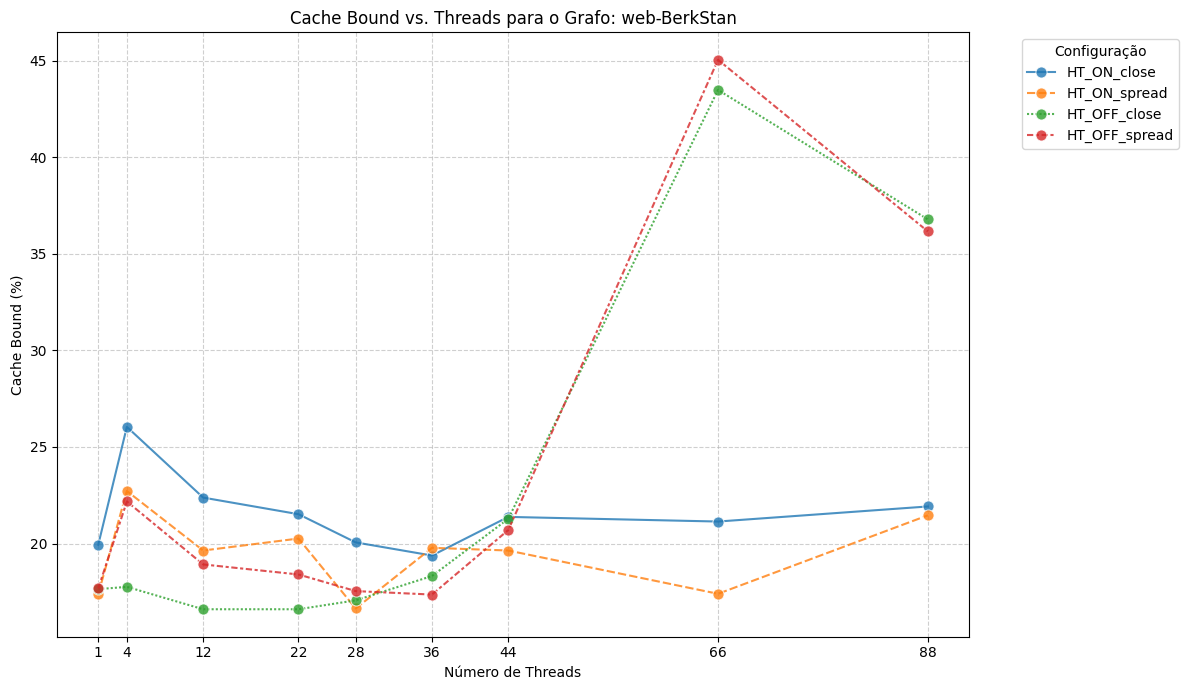

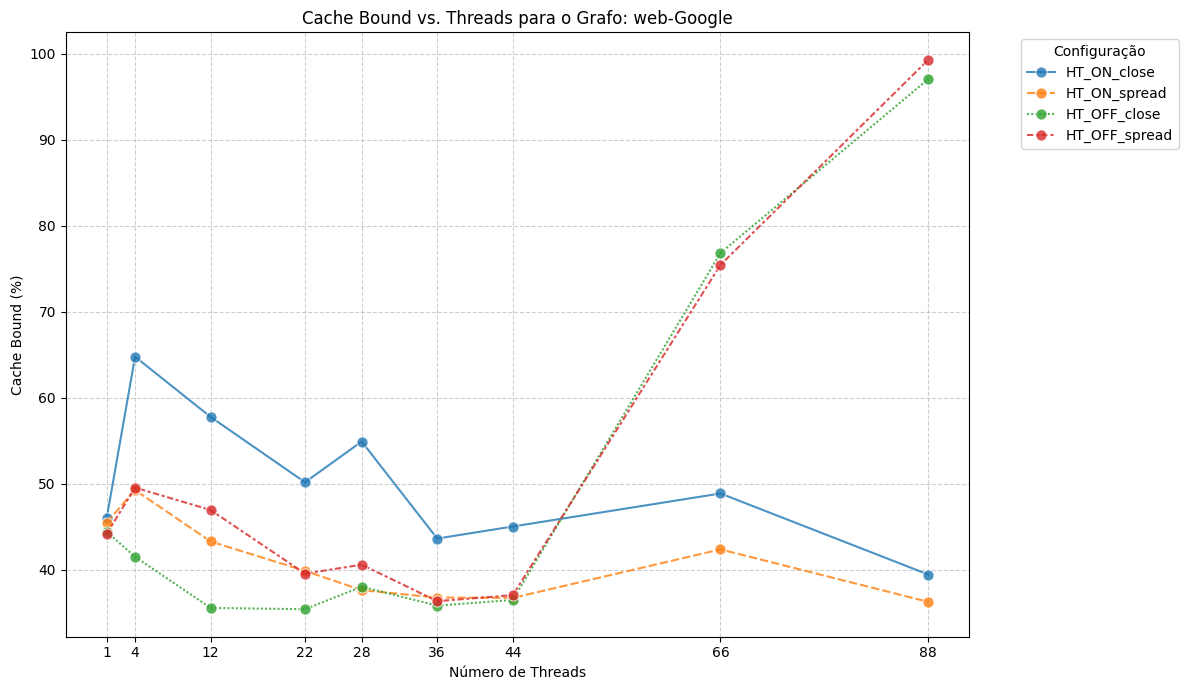

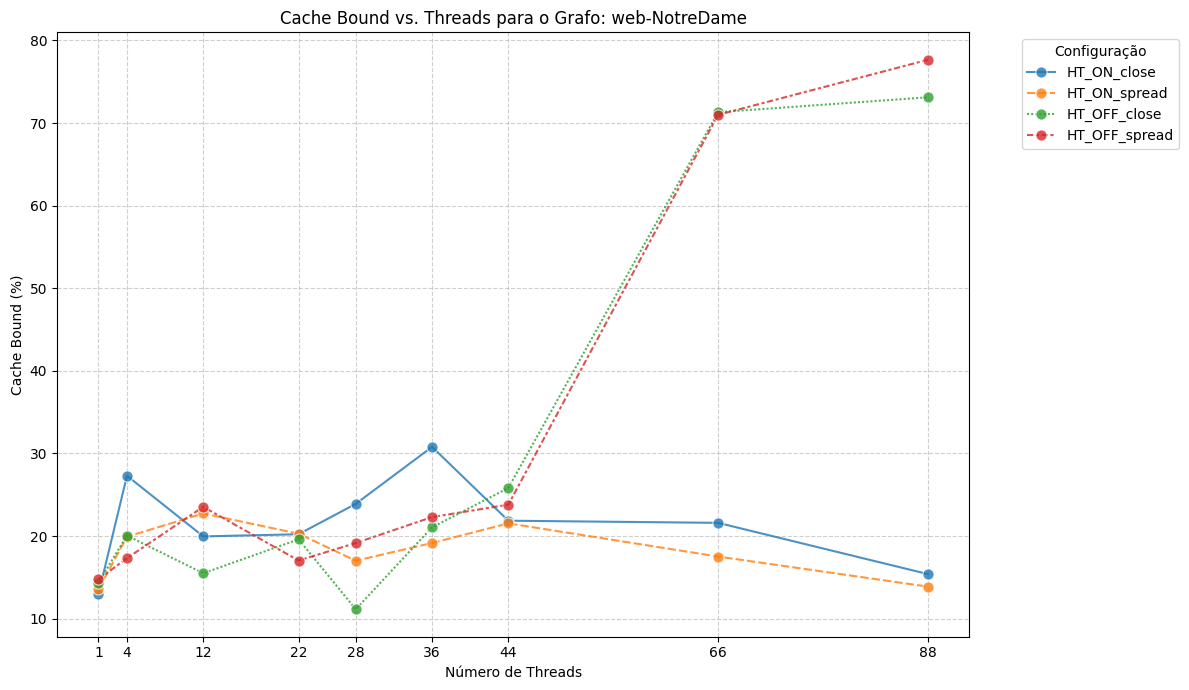

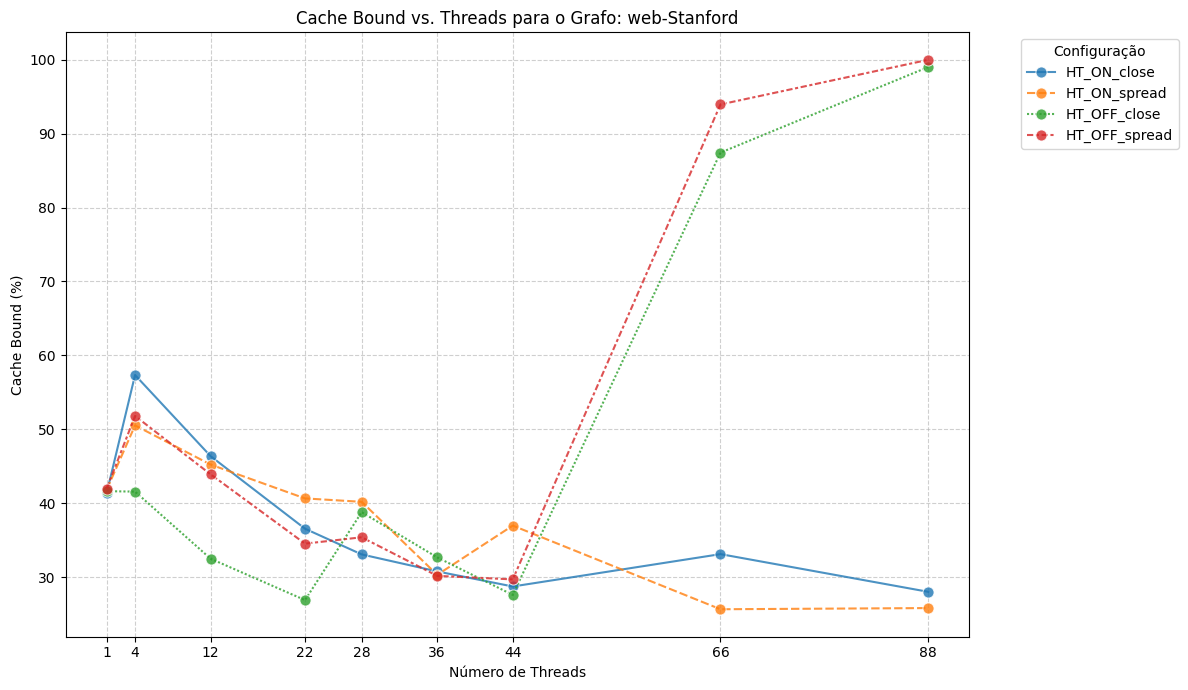

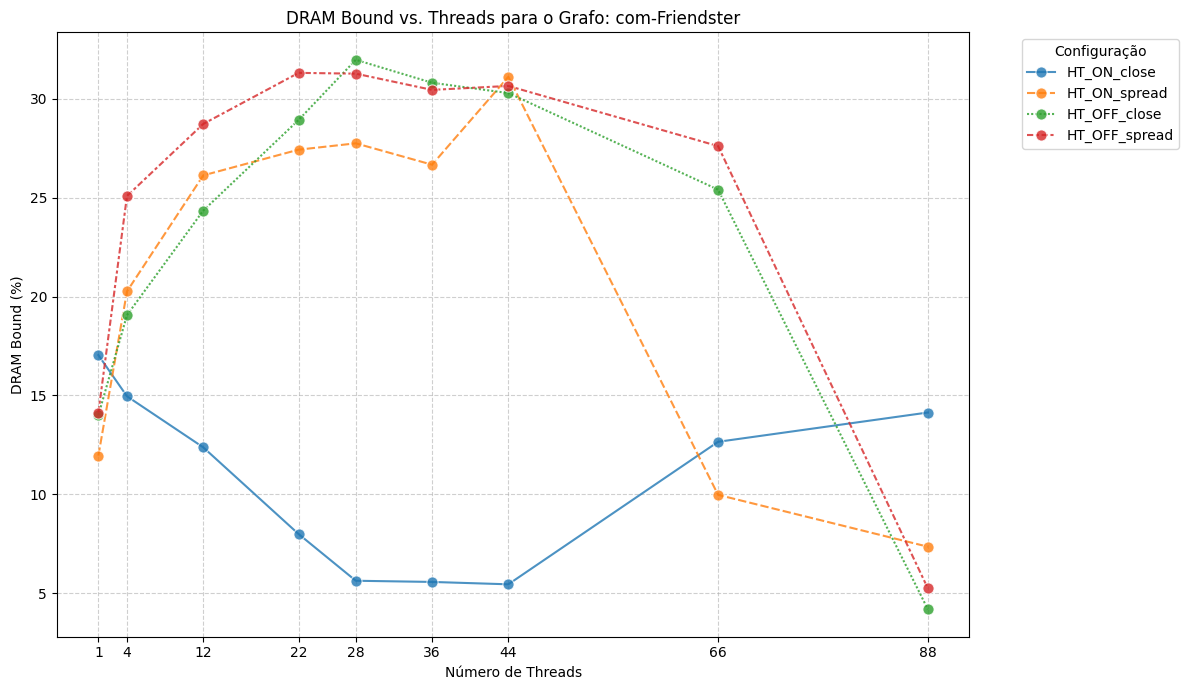

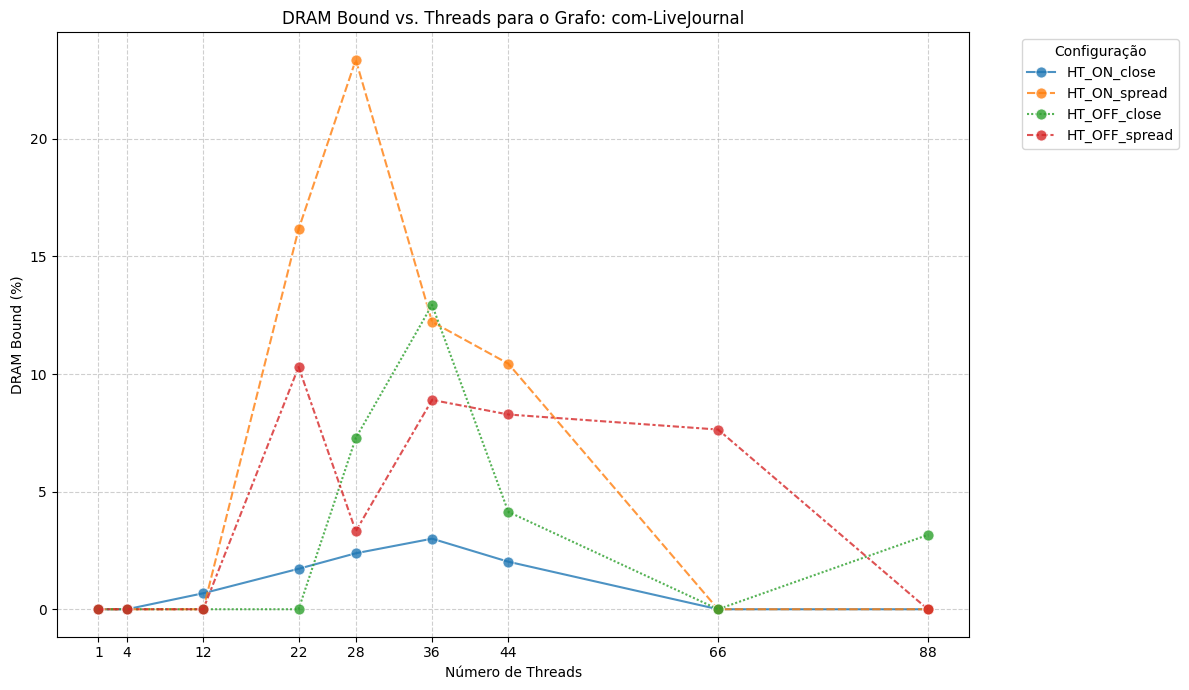

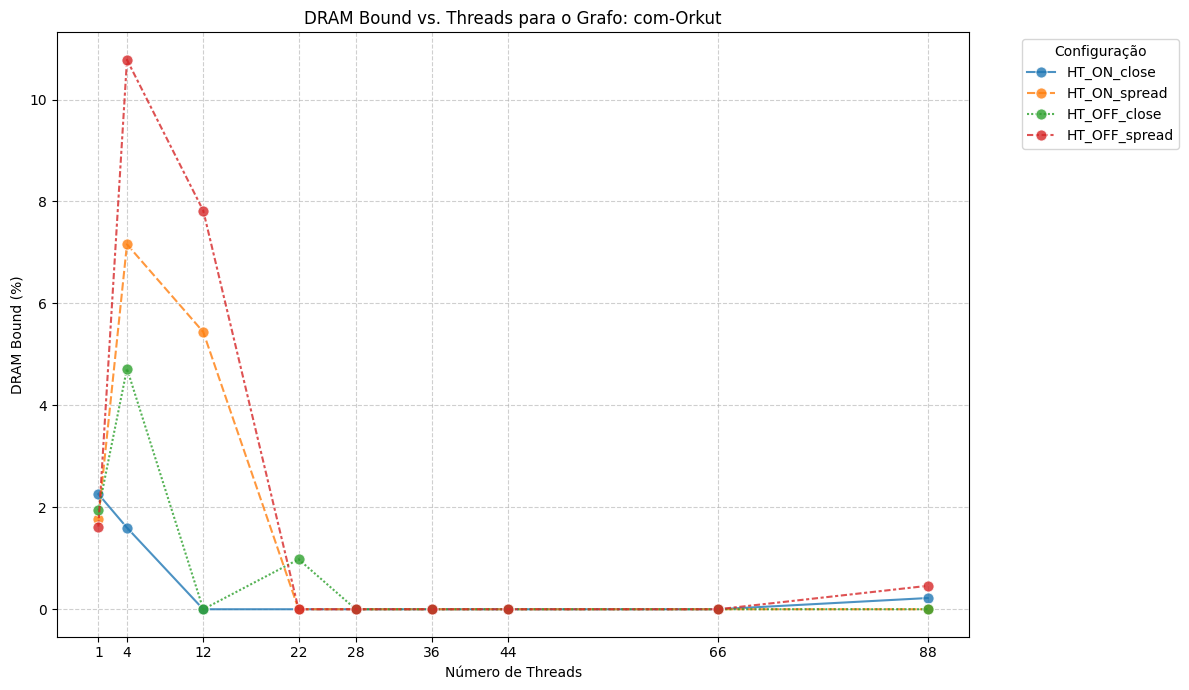

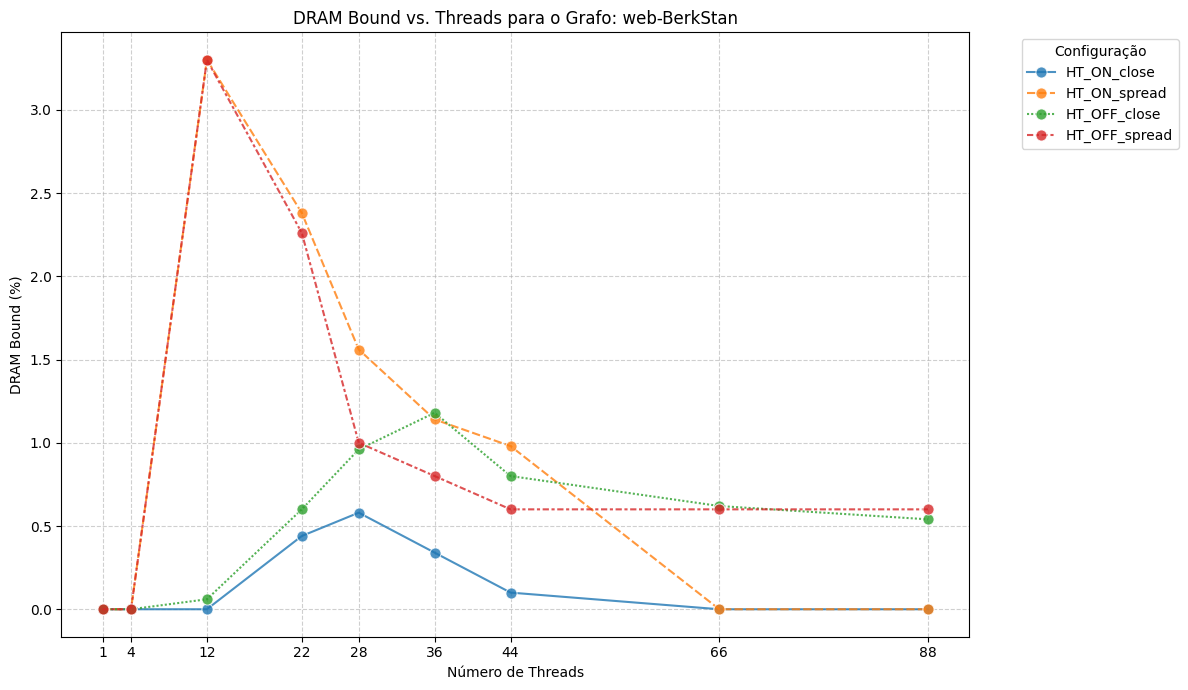

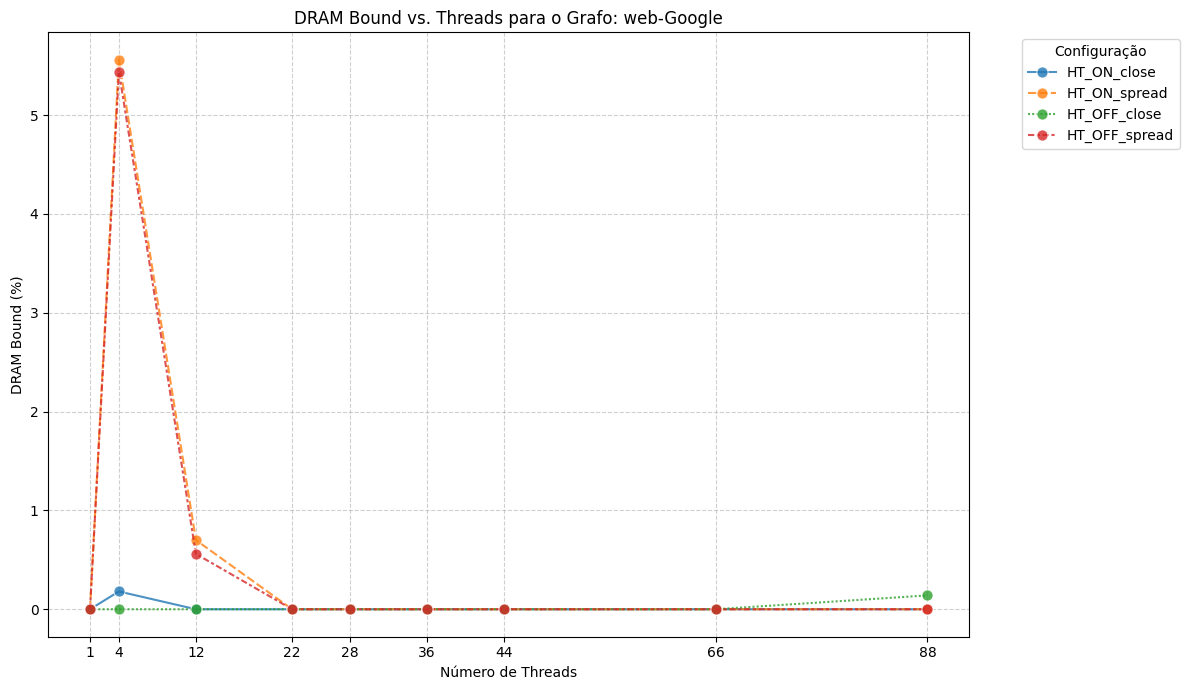

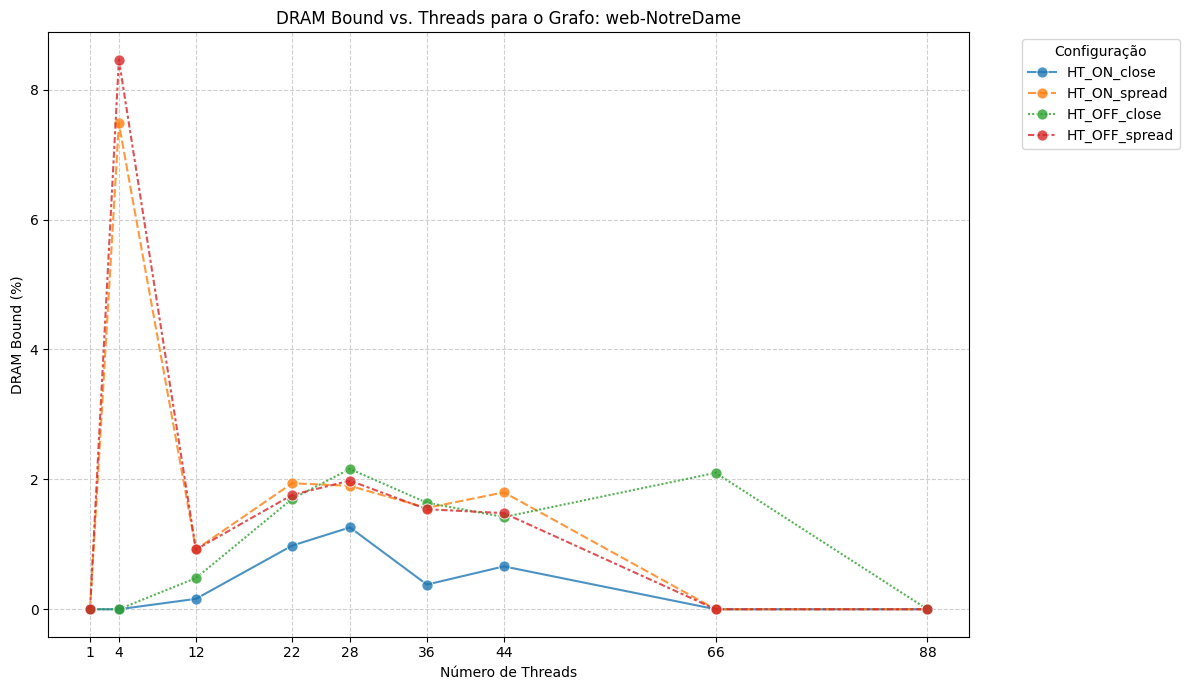

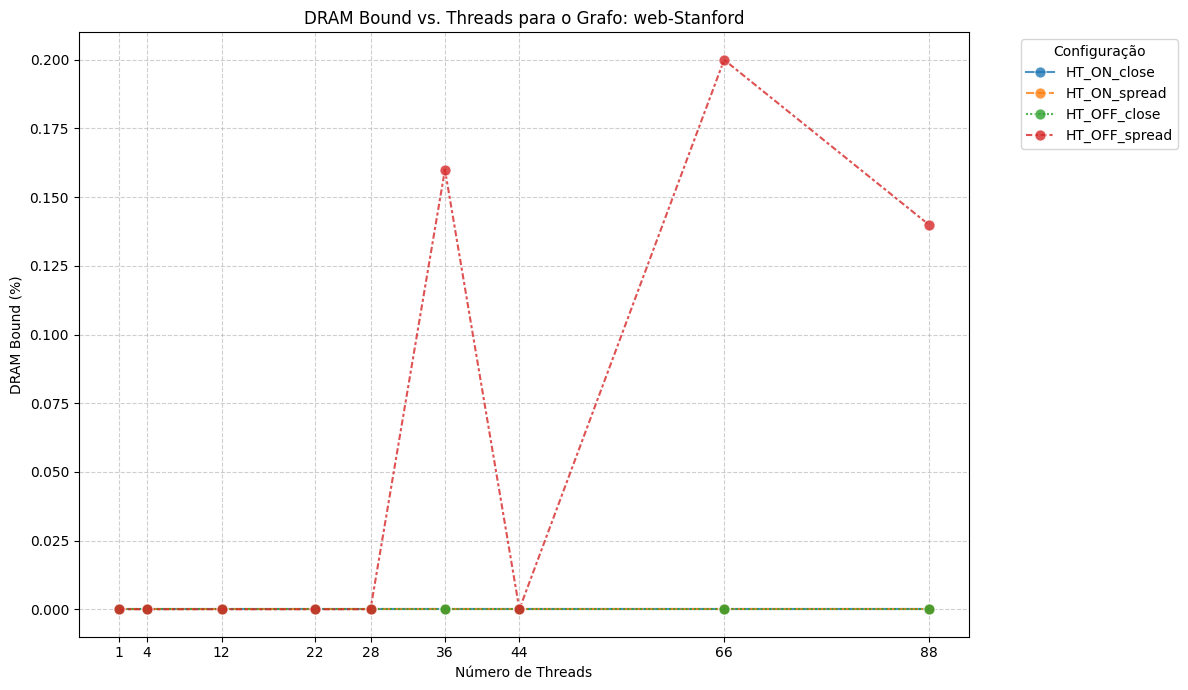

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega df_hpc_metrics
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')

# Cria uma coluna combinada para hyperthreading e thread binding policy
df_hpc_metrics["CONFIG"] = df_hpc_metrics["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if x == False else "HT_OFF") + "_" + df_hpc_metrics["THREAD_BIND_POLICY"]

# Obtém listas únicas de grafos
grafos = df_hpc_metrics["GRAPH_NAME"].unique()

# Métricas adicionais para plotar
metrics_to_plot = {
    "AVERAGE_CPU_FREQUENCY": {"title": "Frequência Média da CPU", "ylabel": "Frequência (GHz)"},
    "CACHE_BOUND": {"title": "Cache Bound", "ylabel": "Cache Bound (%)"},
    "DRAM_BOUND": {"title": "DRAM Bound", "ylabel": "DRAM Bound (%)"}
}

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada métrica e depois sobre cada grafo para gerar os gráficos
for metric_col, metric_info in metrics_to_plot.items():
    for grafo in grafos:
        df_filtered_graph = df_hpc_metrics[df_hpc_metrics["GRAPH_NAME"] == grafo].copy()

        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=df_filtered_graph,
            x="THREADS",
            y=metric_col,
            hue="CONFIG",
            style="CONFIG",
            marker="o",
            markersize=8,
            alpha=0.8,
            errorbar=None # Remove o intervalo de confiança sombreado
        )

        plt.title(f"{metric_info['title']} vs. Threads para o Grafo: {grafo}")
        plt.xlabel("Número de Threads")
        plt.ylabel(metric_info['ylabel'])
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(df_filtered_graph["THREADS"].unique())

        # Conditionally set legend location based on the metric
        if metric_col == "AVERAGE_CPU_FREQUENCY":
            plt.legend(title="Configuração", loc='best') # Legend inside for CPU frequency
        else:
            plt.legend(title="Configuração", bbox_to_anchor=(1.05, 1), loc='upper left') # External for others


        plt.tight_layout()
        # Salva a figura como um arquivo PDF na pasta "gráficos"
        plt.savefig(os.path.join(output_dir, f"{metric_col.lower()}_vs_threads_{grafo}.pdf"))
        # Mostra a figura no notebook
        plt.show()

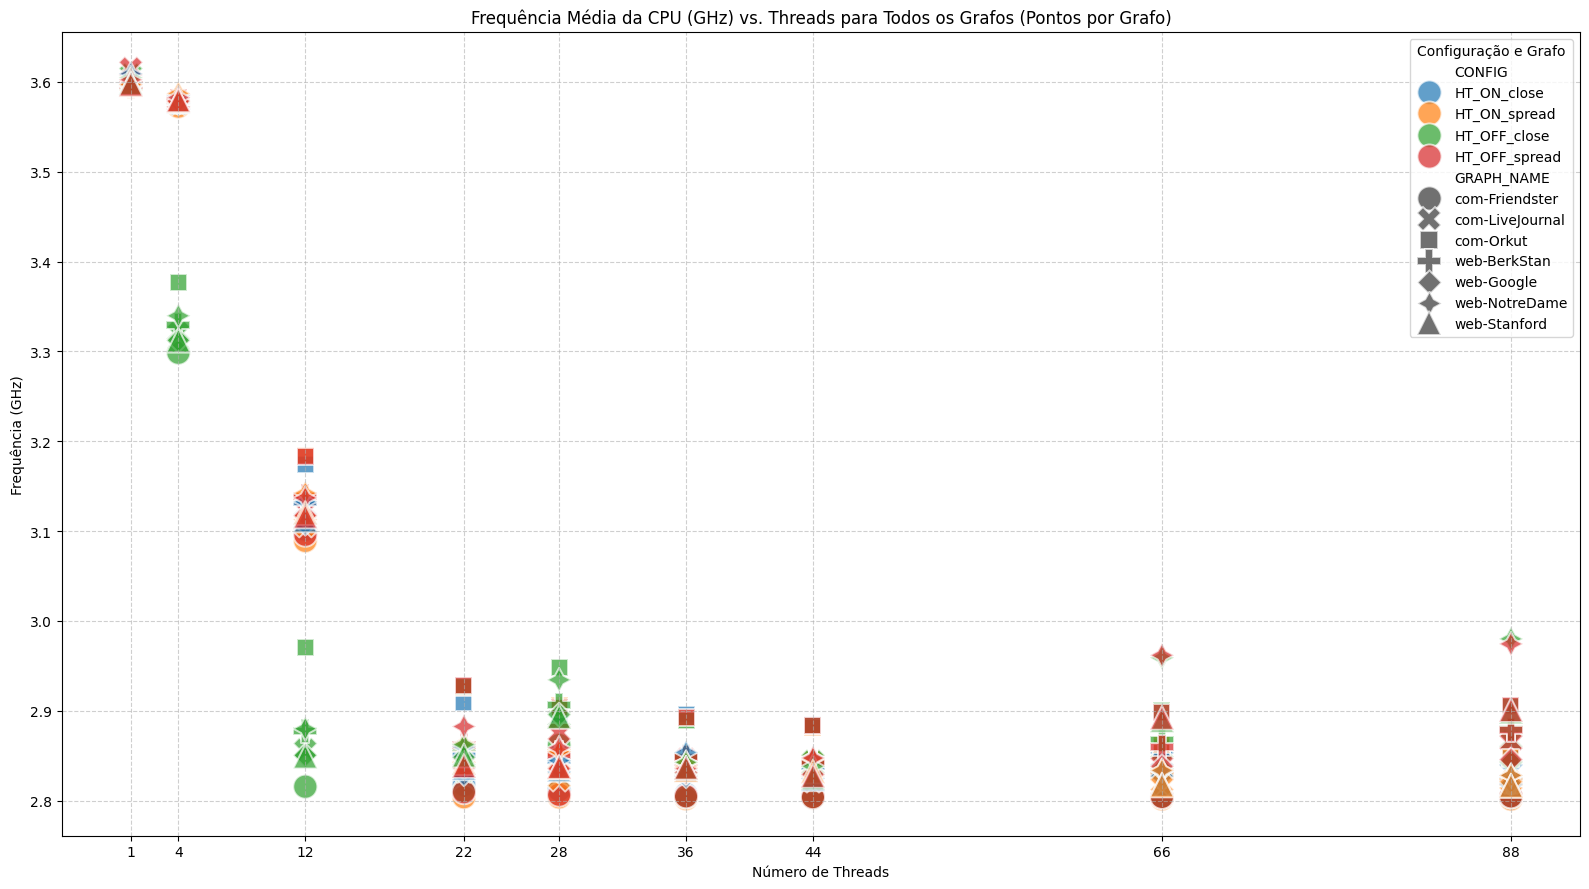

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega df_hpc_metrics (já carregado e com CPU_FREQUENCY em GHz)
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')
df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] = df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] / 1e9

# Cria uma coluna combinada para hyperthreading e thread binding policy
df_hpc_metrics["CONFIG"] = df_hpc_metrics["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if x == False else "HT_OFF") + "_" + df_hpc_metrics["THREAD_BIND_POLICY"]

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.figure(figsize=(16, 9)) # Aumenta o tamanho da figura para acomodar mais dados
sns.scatterplot(
    data=df_hpc_metrics,
    x="THREADS",
    y="AVERAGE_CPU_FREQUENCY",
    hue="CONFIG",
    style="GRAPH_NAME", # Diferencia por grafo usando o estilo do marcador
    s=300, # Tamanho do marcador aumentado em 2x (era 100)
    alpha=0.7
)

plt.title("Frequência Média da CPU (GHz) vs. Threads para Todos os Grafos (Pontos por Grafo)")
plt.xlabel("Número de Threads")
plt.ylabel("Frequência (GHz)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(sorted(df_hpc_metrics["THREADS"].unique()))
plt.legend(title="Configuração e Grafo", loc='best') # Alterado para loc='best'
plt.tight_layout()

# Salva a figura como um arquivo PDF na pasta "gráficos"
output_file = os.path.join(output_dir, "combined_average_cpu_frequency_all_graphs_scatter.pdf")
plt.savefig(output_file)

# Mostra a figura no notebook
plt.show()

In [18]:
import pandas as pd
import os
import re

# Function to escape underscores for LaTeX
def escape_latex_underscore(text):
    return text.replace('_', '\\_')

# Function to format numeric values for LaTeX
def format_value(value, precision=3):
    if pd.isna(value):
        return '-'
    return f"{value:.{precision}f}"

# Function to apply highlighting to cells
def highlight_cells_latex(row_data, metric_info, thread_columns):
    """
    Formats a row of numeric data for LaTeX, applying cell coloring for min/max values.
    Args:
        row_data (pd.Series): A Series of numeric values (THREADS as index).
        metric_info (dict): Contains 'better_is' ('higher' or 'lower').
        thread_columns (list): List of column names (threads) in order.
    Returns:n        list: List of LaTeX-formatted strings for each cell in the row.
    """
    formatted_cells = []
    # Only consider values present in the current row for min/max calculation
    values_to_compare = row_data[thread_columns].dropna()

    if values_to_compare.empty:
        # Pass the original precision from format_value, as this is for non-highlighted cases
        return [format_value(row_data.get(col, pd.NA), precision=3 if metric_info.get('metric_col') == 'AVERAGE_CPU_FREQUENCY' else 2) for col in thread_columns]

    min_val = values_to_compare.min()
    max_val = values_to_compare.max()

    for col in thread_columns:
        val = row_data.get(col, pd.NA) # Use .get() for robustness if column is missing
        # Use specific precision for CPU frequency
        current_precision = 3 if metric_info.get('metric_col') == 'AVERAGE_CPU_FREQUENCY' else 2
        formatted_val = format_value(val, precision=current_precision)
        cell_str = formatted_val

        # Only highlight if there's a difference between min and max
        # and the current value is not NaN
        if not pd.isna(val) and min_val != max_val:
            if metric_info['better_is'] == 'higher':
                if val == max_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{formatted_val}"
                elif val == min_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{formatted_val}"
            elif metric_info['better_is'] == 'lower':
                if val == min_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{formatted_val}"
                elif val == max_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{formatted_val}"
        formatted_cells.append(cell_str)
    return formatted_cells

# --- Re-load and preprocess df_hpc_metrics ---
# ALWAYS reload df_hpc_metrics to avoid cumulative division errors
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')

# Convert AVERAGE_CPU_FREQUENCY from Hz to GHz
df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] = df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] / 1e9

# Create a combined CONFIG column
df_hpc_metrics["CONFIG"] = df_hpc_metrics["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if x == False else "HT_OFF") + "_" + df_hpc_metrics["THREAD_BIND_POLICY"]

# Define metrics, their display titles, and whether higher/lower is better
metrics_to_display = {
    "AVERAGE_CPU_FREQUENCY": {"title": "Frequência Média da CPU (GHz)", "better_is": "higher", "metric_col": "AVERAGE_CPU_FREQUENCY"},
    "CACHE_BOUND": {"title": "Cache Bound (\%)", "better_is": "lower", "metric_col": "CACHE_BOUND"},
    "DRAM_BOUND": {"title": "DRAM Bound (\%)", "better_is": "lower", "metric_col": "DRAM_BOUND"}
}

# Create output directory for highlighted LaTeX tables
# User requested folder name 'tabelas'
latex_output_root = "tabelas"
if not os.path.exists(latex_output_root):
    os.makedirs(latex_output_root)

# Iterate through each metric to generate a highlighted LaTeX table
for metric_col, metric_info in metrics_to_display.items():
    print(f"### Tabela Combinada (com destaque): {metric_info['title']}\n")

    # Group, aggregate, and unstack to get the desired table structure
    df_grouped = df_hpc_metrics.groupby(['GRAPH_NAME', 'CONFIG', 'THREADS'])[metric_col].mean().unstack()

    # Get the ordered list of THREADS columns
    thread_columns = df_grouped.columns.tolist()
    num_thread_cols = len(thread_columns)

    # Build list of LaTeX lines for table body
    latex_body_lines = []
    current_graph = None

    # Pre-calculate counts for multirow
    df_grouped_processed_index = df_grouped.copy()
    df_grouped_processed_index.index = df_grouped_processed_index.index.set_levels(
        [df_grouped_processed_index.index.levels[0].map(escape_latex_underscore).tolist(),
         df_grouped_processed_index.index.levels[1].map(escape_latex_underscore).tolist()],
        level=[0, 1]
    )

    graph_config_counts = df_grouped_processed_index.groupby(level=0).size()

    # Get a list of unique graph names to determine the last graph
    unique_graph_names = df_grouped_processed_index.index.get_level_values('GRAPH_NAME').unique()
    last_graph_name = unique_graph_names[-1] if not unique_graph_names.empty else None

    # Initialize final LaTeX string for the table
    latex_str = ""

    latex_str += "\\begin{table}[ht]\n"
    latex_str += "\\centering\n" # Center the table
    latex_str += f"\\label{{tab:{metric_col.lower().replace('_', '-')}-combined-highlighted}}\n"

    col_format = 'll' + 'r' * num_thread_cols
    latex_str += f"\\begin{{tabular}}{{{col_format}}}\n"
    latex_str += "\\toprule\n"

    # Header Row 1: GRAPH_NAME, CONFIG, THREADS multi-column
    # Explicitly concatenate Python strings for multi-line f-string to avoid SyntaxError
    latex_str += (f"\\multirow{{2}}*{{{escape_latex_underscore('GRAPH_NAME')}}} & "
                  f"\\multirow{{2}}*{{{escape_latex_underscore('CONFIG')}}} & "
                  f"\\multicolumn{{{num_thread_cols}}}{{c}}{{{escape_latex_underscore('THREADS')}}} \\\\") + "\n"

    # cmidrule (no trailing \\ in LaTeX, followed by Python newline)
    latex_str += (f"\\cmidrule(lr){{3-{num_thread_cols + 2}}}") + "\n"

    # Header Row 2: Thread numbers
    # Explicitly concatenate Python strings for multi-line f-string
    latex_str += (f" & & { ' & '.join(map(str, thread_columns)) } \\\\") + "\n"

    latex_str += "\\midrule\n"

    for (graph, config), row_data in df_grouped_processed_index.iterrows():
        escaped_graph = graph
        escaped_config = config

        highlighted_cells = highlight_cells_latex(row_data, metric_info, thread_columns)

        # Each data row ends with LaTeX \\ (escaped as \\\\)
        row_content_str = f"{escaped_config} & " + " & ".join(highlighted_cells) + " \\\\"

        if graph != current_graph:
            num_configs_in_group = graph_config_counts.get(graph, 0)
            if num_configs_in_group > 0:
                latex_body_lines.append(f"\\multirow{{{num_configs_in_group}}}{{*}}{{{escaped_graph}}} & {row_content_str}")
            current_graph = graph
        else:
            latex_body_lines.append(f" & {row_content_str}")

        # \cline should be on its own line in the LaTeX output
        if graph in df_grouped_processed_index.index.get_level_values('GRAPH_NAME').unique():
            configs_for_current_graph = df_grouped_processed_index.loc[graph].index.get_level_values('CONFIG').unique().tolist()
            is_last_config_for_graph = (configs_for_current_graph.index(config) == len(configs_for_current_graph) - 1)
        else:
            is_last_config_for_graph = False

        # Append \cline only if it's the last config for a graph and not the very last graph
        if is_last_config_for_graph and graph != last_graph_name:
            latex_body_lines.append(f"\\cline{{1-{num_thread_cols + 2}}}")

    # Join body lines with Python newlines. Add a final Python newline after the last line of the body.
    latex_str += "\n".join(latex_body_lines) + "\n"

    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += f"\\caption{{Tabela Combinada de {escape_latex_underscore(metric_info['title'])} para todos os grafos (Valores Ótimos Destacados)}}\n"
    latex_str += "\\end{table}\n"

    print(latex_str)

    # Save the LaTeX code to a .tex file
    filename = f"{metric_col.lower().replace('_', '-')}_combined_highlighted.tex"
    filepath = os.path.join(latex_output_root, filename)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"Tabela LaTeX combinada (com destaque) salva em: {filepath}\n")

    print("\n" + "-" * 80 + "\n")

### Tabela Combinada (com destaque): Frequência Média da CPU (GHz)

\begin{table}[ht]
\centering
\label{tab:average-cpu-frequency-combined-highlighted}
\begin{tabular}{llrrrrrrrrr}
\toprule
\multirow{2}*{GRAPH\_NAME} & \multirow{2}*{CONFIG} & \multicolumn{9}{c}{THREADS} \\
\cmidrule(lr){3-11}
 & & 1 & 4 & 12 & 22 & 28 & 36 & 44 & 66 & 88 \\
\midrule
\multirow{4}{*}{com-Friendster} & HT\_OFF\_close & \cellcolor{ForestGreen}3.597 & 3.299 & 2.816 & 2.811 & 2.862 & 2.804 & \cellcolor{BrickRed}2.803 & 2.804 & 2.804 \\
 & HT\_OFF\_spread & \cellcolor{ForestGreen}3.597 & 3.577 & 3.096 & 2.809 & 2.807 & 2.805 & \cellcolor{BrickRed}2.804 & 2.804 & 2.805 \\
 & HT\_ON\_close & \cellcolor{ForestGreen}3.597 & 3.576 & 3.102 & 2.817 & 2.812 & 2.807 & 2.807 & 2.804 & \cellcolor{BrickRed}2.803 \\
 & HT\_ON\_spread & \cellcolor{ForestGreen}3.597 & 3.573 & 3.089 & 2.804 & 2.804 & 2.802 & 2.803 & 2.802 & \cellcolor{BrickRed}2.802 \\
\cline{1-11}
\multirow{4}{*}{com-LiveJournal} & HT\_OFF\_close & \cellcol

<>:72: SyntaxWarning: invalid escape sequence '\%'
<>:73: SyntaxWarning: invalid escape sequence '\%'
<>:72: SyntaxWarning: invalid escape sequence '\%'
<>:73: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_64254/2499496639.py:72: SyntaxWarning: invalid escape sequence '\%'
  "CACHE_BOUND": {"title": "Cache Bound (\%)", "better_is": "lower", "metric_col": "CACHE_BOUND"},
/tmp/ipykernel_64254/2499496639.py:73: SyntaxWarning: invalid escape sequence '\%'
  "DRAM_BOUND": {"title": "DRAM Bound (\%)", "better_is": "lower", "metric_col": "DRAM_BOUND"}


### Análise dos ciclos por instrução

Nesta seção, vamos analisar os ciclos por instrução de cada configuração, organizado de maneira similar a última seção.

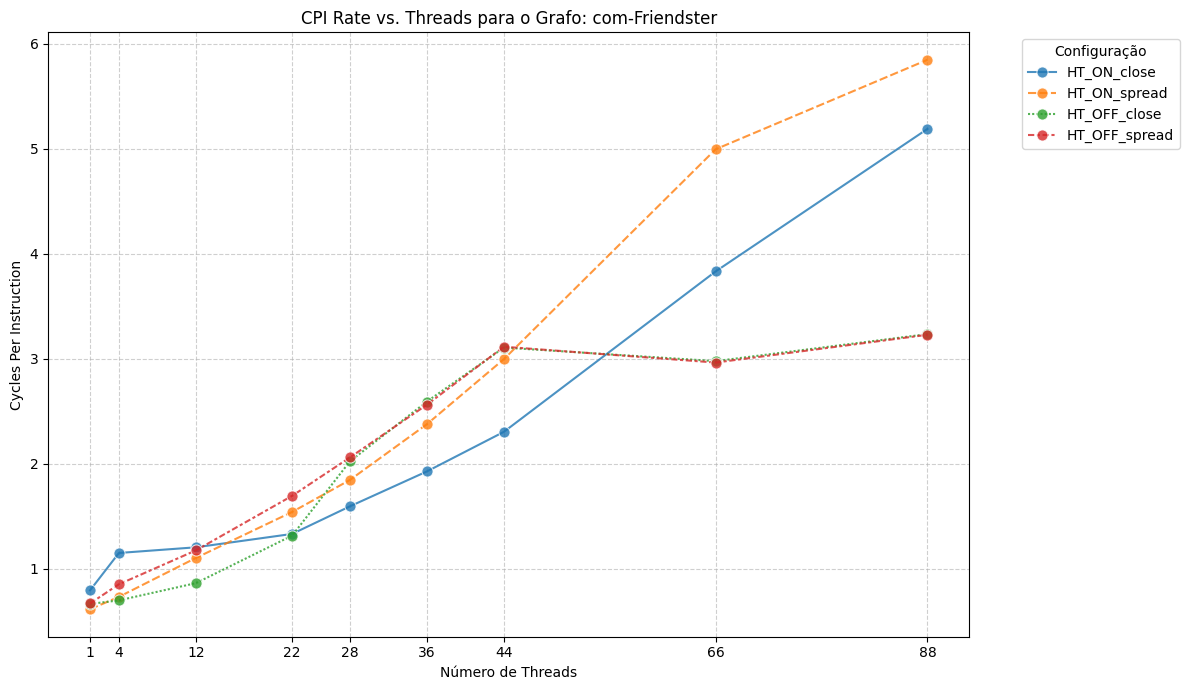

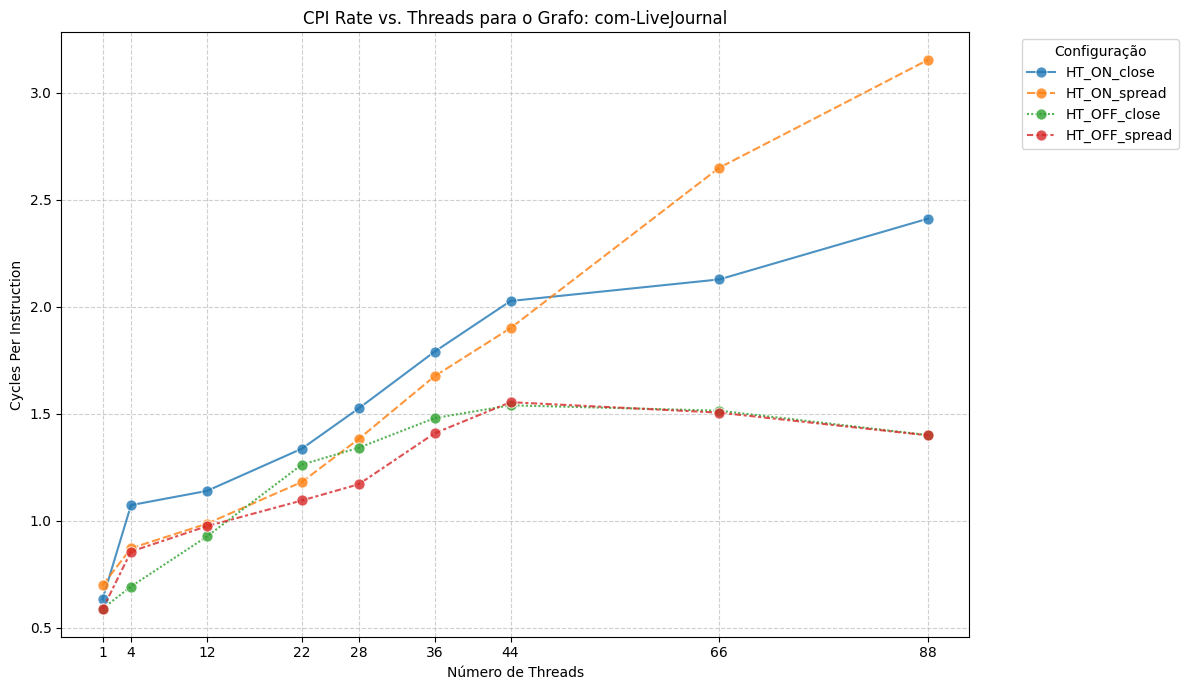

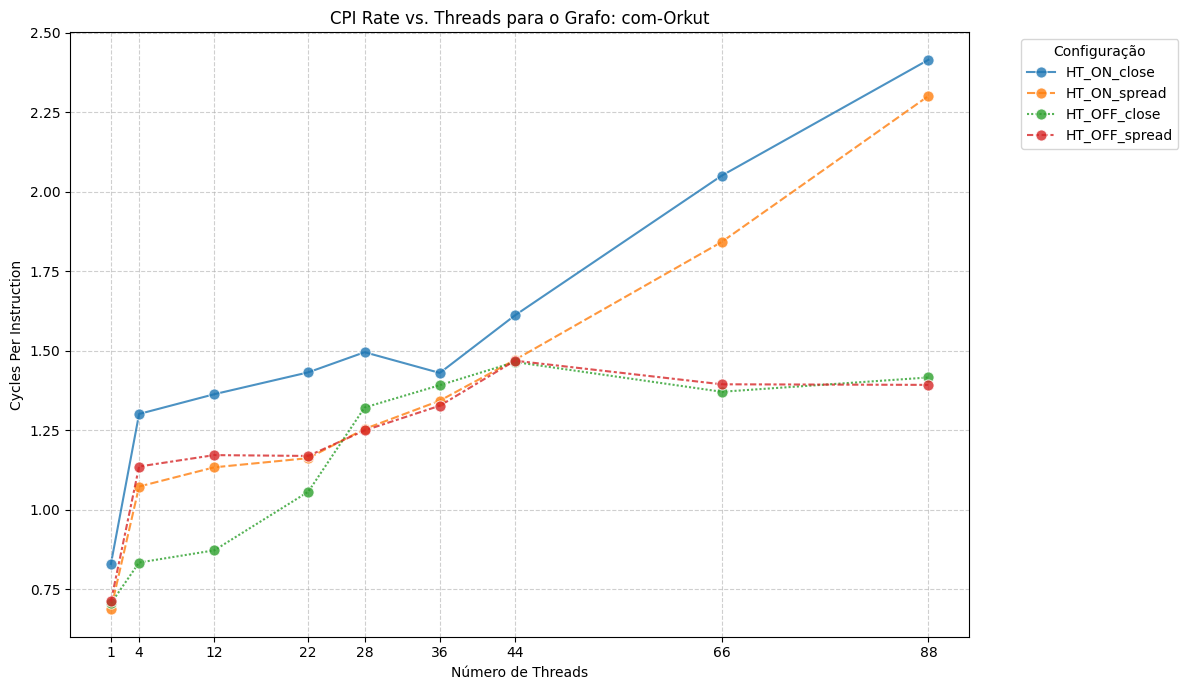

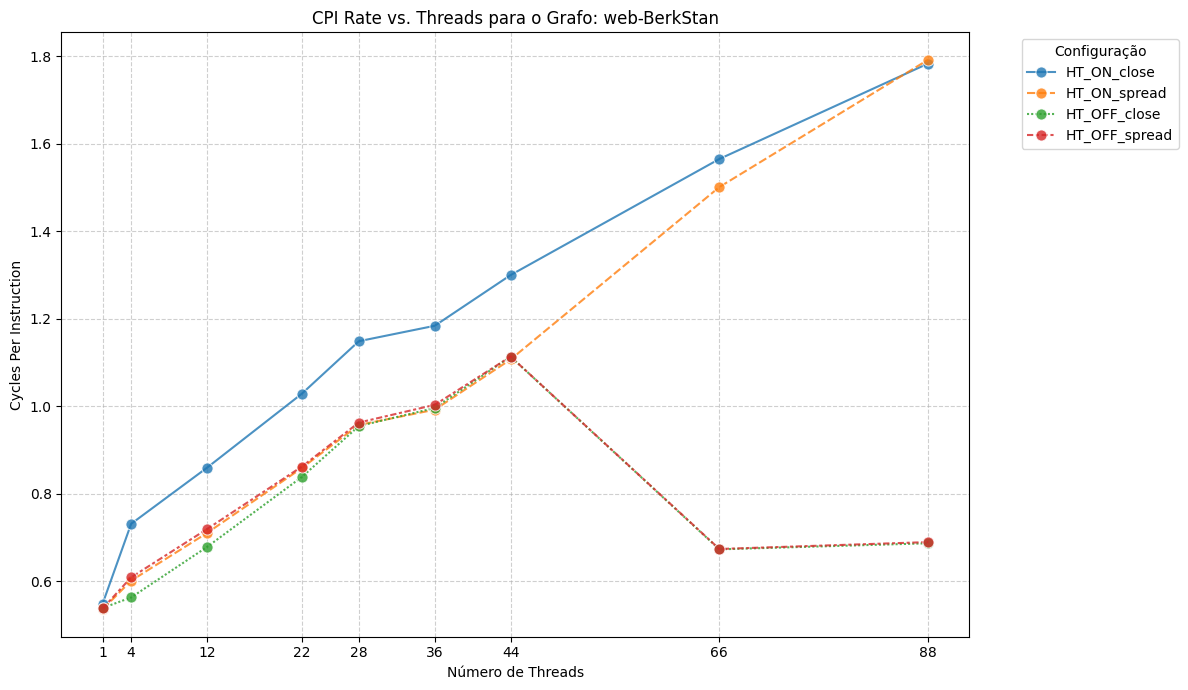

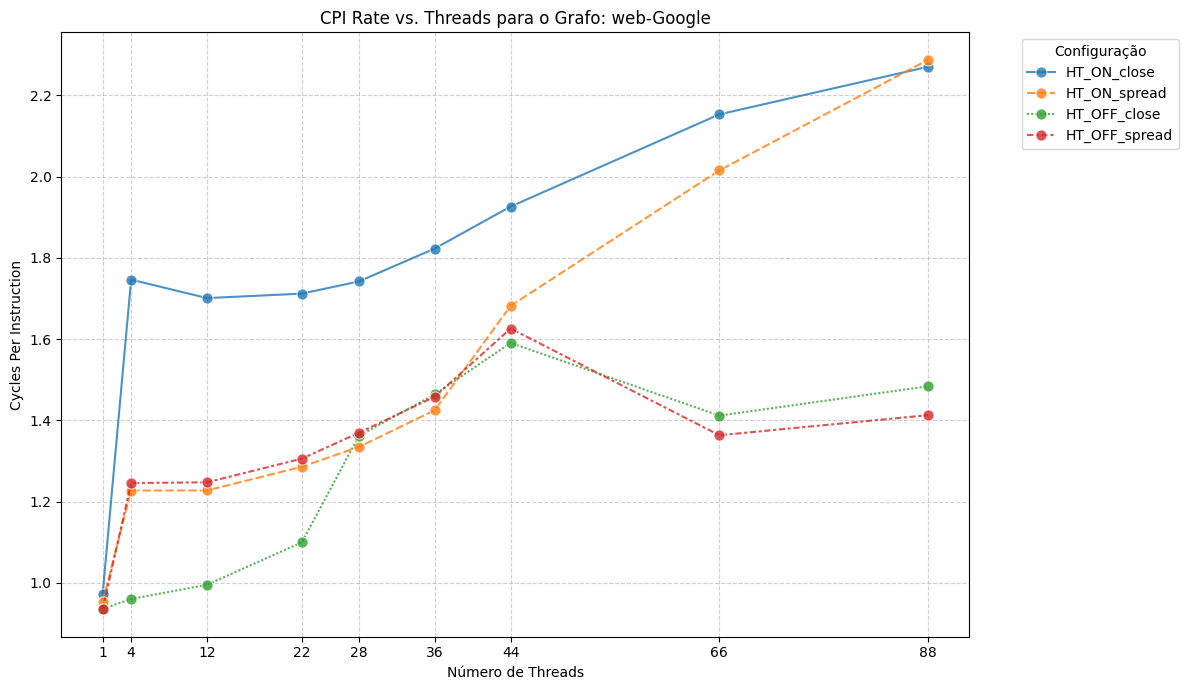

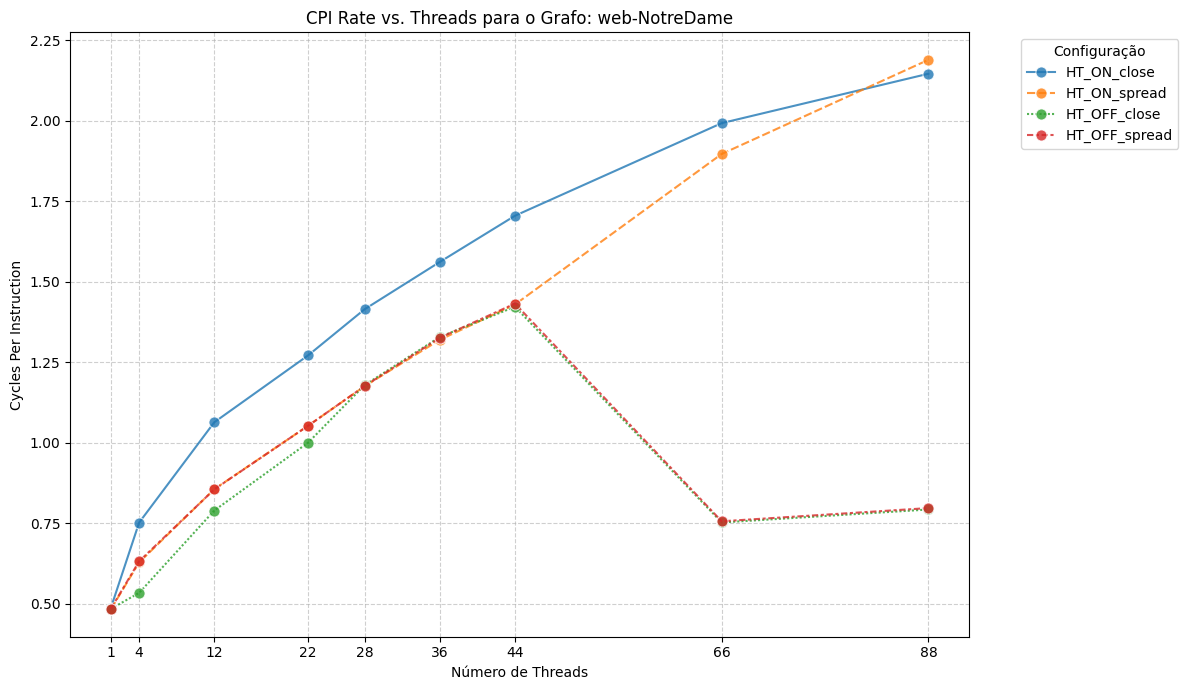

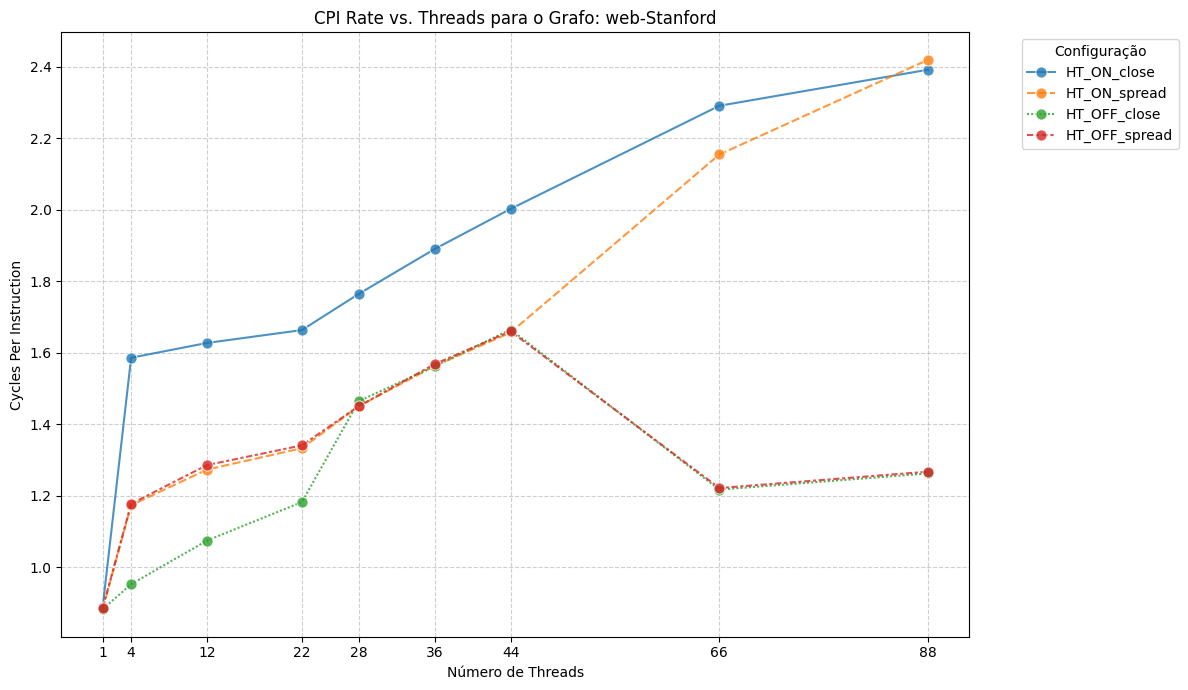

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Carrega df_hpc_metrics
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')

# Cria uma coluna combinada para hyperthreading e thread binding policy
df_hpc_metrics["CONFIG"] = df_hpc_metrics["DISABLE_HYPERTHREADING"].apply(lambda x: "HT_ON" if x == False else "HT_OFF") + "_" + df_hpc_metrics["THREAD_BIND_POLICY"]

# Obtém listas únicas de grafos
grafos = df_hpc_metrics["GRAPH_NAME"].unique()

# Métricas adicionais para plotar (AGORA APENAS CPI_RATE)
metrics_to_plot = {
    "CPI_RATE": {"title": "CPI Rate", "ylabel": "Cycles Per Instruction"}
}

# Cria a pasta "gráficos" se ela não existir
output_dir = "gráficos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Itera sobre cada métrica e depois sobre cada grafo para gerar os gráficos
for metric_col, metric_info in metrics_to_plot.items():
    for grafo in grafos:
        df_filtered_graph = df_hpc_metrics[df_hpc_metrics["GRAPH_NAME"] == grafo].copy()

        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=df_filtered_graph,
            x="THREADS",
            y=metric_col,
            hue="CONFIG",
            style="CONFIG",
            marker="o",
            markersize=8,
            alpha=0.8,
            errorbar=None # Remove o intervalo de confiança sombreado
        )

        plt.title(f"{metric_info['title']} vs. Threads para o Grafo: {grafo}")
        plt.xlabel("Número de Threads")
        plt.ylabel(metric_info['ylabel'])
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(df_filtered_graph["THREADS"].unique())
        plt.legend(title="Configuração", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        # Salva a figura como um arquivo PDF na pasta "gráficos"
        # plt.savefig(os.path.join(output_dir, f"{metric_col.lower()}_vs_threads_{grafo}.pdf"))
        # Mostra a figura no notebook
        plt.show()

In [20]:
import pandas as pd

def calcular_e_mostrar_cv(df):
    """
    Calcula o Coeficiente de Variação (CV) = (Desvio Padrão / Média) * 100.
    Mostra quantos % o desvio representa do valor médio.
    """
    # Evita divisão por zero caso a média seja 0
    df['CV_PERCENT'] = df.apply(
        lambda row: (row['MEMORY_BOUND_STD'] / row['MEMORY_BOUND'] * 100) if row['MEMORY_BOUND'] > 0 else 0.0,
        axis=1
    )

    tabela_cv = df.pivot_table(
        index=['GRAPH_NAME', 'CONFIG'],
        columns='THREADS',
        values='CV_PERCENT'
    )

    print("\n" + "="*100)
    print("TABELA DE COEFICIENTE DE VARIAÇÃO (CV%) - MEMORY BOUND")
    print("Significado: O desvio padrão representa X% do valor da média.")
    print("="*100)
    print(tabela_cv)
    print("="*100)

    # --- NOVO: Média Geral do CV% ---
    media_geral_cv = df['CV_PERCENT'].mean()
    print(f"\n>>> COEFICIENTE DE VARIAÇÃO MÉDIO GERAL: {media_geral_cv:.3f}%")
    print("="*100)

def main():
    print(">>> Lendo dados de 'hpc_hw_metrics.csv'...\n")

    try:
        df = pd.read_csv('hpc_hw_metrics.csv')
    except FileNotFoundError:
        print("ERRO: Arquivo 'hpc_hw_metrics.csv' não encontrado na pasta.")
        return

    # 1. Limpeza do Nome do Grafo (Remove web- e com-)
    df['GRAPH_NAME'] = df['GRAPH_NAME'].str.replace(r'^(web-|com-)', '', regex=True)

    # 2. Criação da coluna de Configuração Abreviada (H_OFF_C, etc.)
    df["CONFIG"] = df.apply(
        lambda row: ("H_OFF" if row["DISABLE_HYPERTHREADING"] else "H_ON") + "_" +
                    ("C" if row["THREAD_BIND_POLICY"] == "close" else "S"),
        axis=1
    )

    # 3. Criação da Tabela Pivô (Matriz) - Desvio Padrão Absoluto
    # Linhas: Grafo e Configuração
    # Colunas: Threads
    # Valores: Desvio Padrão do Memory Bound (MEMORY_BOUND_STD)
    tabela_std = df.pivot_table(
        index=['GRAPH_NAME', 'CONFIG'],
        columns='THREADS',
        values='MEMORY_BOUND_STD'
    )

    # 4. Configuração de exibição do Pandas para o terminal
    pd.set_option('display.max_rows', None)      # Mostra todas as linhas
    pd.set_option('display.max_columns', None)   # Mostra todas as colunas
    pd.set_option('display.width', 1000)         # Aumenta a largura para não quebrar linha
    pd.set_option('display.float_format', '{:.3f}'.format) # Formata para 3 casas decimais

    # 5. Imprimir Tabela de STD Absoluto
    print("="*100)
    print("TABELA DE DESVIO PADRÃO ABSOLUTO (STD) - MEMORY BOUND (%)")
    print("="*100)
    print(tabela_std)
    print("="*100)

    # 6. Calcular e Imprimir Tabela de CV%
    calcular_e_mostrar_cv(df)

if __name__ == "__main__":
    main()

>>> Lendo dados de 'hpc_hw_metrics.csv'...

TABELA DE DESVIO PADRÃO ABSOLUTO (STD) - MEMORY BOUND (%)
THREADS                1     4     12    22    28     36    44    66    88
GRAPH_NAME  CONFIG                                                        
BerkStan    H_OFF_C 0.270 1.080 1.498 1.233 0.602  2.156 2.507 2.236 3.970
            H_OFF_S 0.164 0.432 1.128 2.993 0.730  1.495 0.550 1.798 3.441
            H_ON_C  0.228 0.205 0.167 0.908 0.701  0.893 0.853 0.736 0.765
            H_ON_S  0.182 1.046 1.894 2.104 3.391  1.878 2.311 0.634 0.650
Friendster  H_OFF_C 0.158 0.327 0.773 0.770 1.722  0.680 0.550 1.308 1.408
            H_OFF_S 0.422 0.356 0.390 0.604 0.713  0.941 1.062 0.541 1.134
            H_ON_C  0.274 0.598 0.835 1.396 0.576  1.744 1.788 0.513 0.865
            H_ON_S  0.288 0.522 0.719 0.568 1.387  0.391 0.469 0.635 0.510
Google      H_OFF_C 0.568 0.614 1.210 1.568 0.684  1.757 0.371 1.214 2.696
            H_OFF_S 0.327 0.444 0.631 1.317 1.763  1.956 3.175 2.597 2.44

In [21]:
import pandas as pd
import os
import re

# Function to escape underscores for LaTeX
def escape_latex_underscore(text):
    return text.replace('_', '\\_')

# Function to format numeric values for LaTeX
def format_value(value, precision=3):
    if pd.isna(value):
        return '-'
    return f"{value:.{precision}f}"

# Function to apply highlighting to cells
def highlight_cells_latex(row_data, metric_info, thread_columns):
    """
    Formats a row of numeric data for LaTeX, applying cell coloring for min/max values.
    """
    formatted_cells = []
    # Only consider values present in the current row for min/max calculation
    values_to_compare = row_data[thread_columns].dropna()

    if values_to_compare.empty:
        # Pass the original precision for non-highlighted cases
        return [format_value(row_data.get(col, pd.NA), precision=3 if metric_info.get('metric_col') in ['AVERAGE_CPU_FREQUENCY', 'CPI_RATE'] else 2) for col in thread_columns]

    min_val = values_to_compare.min()
    max_val = values_to_compare.max()

    for col in thread_columns:
        val = row_data.get(col, pd.NA)

        # Use specific precision for CPU frequency and CPI Rate
        current_precision = 2
        if metric_info.get('metric_col') == 'AVERAGE_CPU_FREQUENCY':
            current_precision = 3
        elif metric_info.get('metric_col') == 'CPI_RATE':
            current_precision = 3

        formatted_val = format_value(val, precision=current_precision)
        cell_str = formatted_val

        # Highlight logic
        if not pd.isna(val) and min_val != max_val:
            if metric_info['better_is'] == 'higher':
                if val == max_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{formatted_val}"
                elif val == min_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{formatted_val}"
            elif metric_info['better_is'] == 'lower':
                if val == min_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{formatted_val}"
                elif val == max_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{formatted_val}"
        formatted_cells.append(cell_str)
    return formatted_cells

# --- Re-load and preprocess df_hpc_metrics ---
df_hpc_metrics = pd.read_csv('hpc_hw_metrics.csv')

# --- NOVA ALTERAÇÃO: Remover prefixos 'web-' e 'com-' do GRAPH_NAME ---
# O regex ^(web-|com-) garante que só remove se estiver no início da string
df_hpc_metrics['GRAPH_NAME'] = df_hpc_metrics['GRAPH_NAME'].str.replace(r'^(web-|com-)', '', regex=True)
# ----------------------------------------------------------------------

# Convert AVERAGE_CPU_FREQUENCY from Hz to GHz
df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] = df_hpc_metrics["AVERAGE_CPU_FREQUENCY"] / 1e9

# Create a combined CONFIG column using the abbreviated format
df_hpc_metrics["CONFIG"] = df_hpc_metrics.apply(
    lambda row: ("H_OFF" if row["DISABLE_HYPERTHREADING"] else "H_ON") + "_" +
                ("C" if row["THREAD_BIND_POLICY"] == "close" else "S"),
    axis=1
)

# Define metrics
metrics_to_display = {
    "AVERAGE_CPU_FREQUENCY": {"title": "Frequência Média da CPU (GHz)", "better_is": "higher", "metric_col": "AVERAGE_CPU_FREQUENCY"},
    "MEMORY_BOUND": {"title": "Memory Bound (\%)", "better_is": "lower", "metric_col": "MEMORY_BOUND"},
    "CPI_RATE": {"title": "CPI Rate", "better_is": "lower", "metric_col": "CPI_RATE"}
}

# Create output directory
latex_output_root = "tabelas"
if not os.path.exists(latex_output_root):
    os.makedirs(latex_output_root)

# Iterate through each metric
for metric_col, metric_info in metrics_to_display.items():
    print(f"### Tabela Combinada (com destaque): {metric_info['title']}\n")

    # Group, aggregate, and unstack
    df_grouped = df_hpc_metrics.groupby(['GRAPH_NAME', 'CONFIG', 'THREADS'])[metric_col].mean().unstack()

    # Get ordered list of threads
    thread_columns = df_grouped.columns.tolist()
    num_thread_cols = len(thread_columns)

    latex_body_lines = []
    current_graph = None

    # Pre-calculate counts for multirow and escape indices
    df_grouped_processed_index = df_grouped.copy()
    df_grouped_processed_index.index = df_grouped_processed_index.index.set_levels(
        [df_grouped_processed_index.index.levels[0].map(escape_latex_underscore).tolist(),
         df_grouped_processed_index.index.levels[1].map(escape_latex_underscore).tolist()],
        level=[0, 1]
    )

    graph_config_counts = df_grouped_processed_index.groupby(level=0).size()
    unique_graph_names = df_grouped_processed_index.index.get_level_values('GRAPH_NAME').unique()
    last_graph_name = unique_graph_names[-1] if not unique_graph_names.empty else None

    # Start LaTeX string
    latex_str = ""
    latex_str += "\\begin{table}[ht]\n"
    latex_str += "\\centering\n"
    latex_str += f"\\label{{{f'tab:{metric_col.lower().replace('_', '-')}-combined-highlighted'}}}\n"

    col_format = 'll' + 'r' * num_thread_cols
    latex_str += f"\\begin{{tabular}}{{{col_format}}}\n"
    latex_str += "\\toprule\n"

    # Header Row 1
    latex_str += (f"\\multirow{{2}}*{{{escape_latex_underscore('GRAPH_NAME')}}} & "
                  f"\\multirow{{2}}*{{{escape_latex_underscore('CONFIG')}}} & "
                  f"\\multicolumn{{{num_thread_cols}}}{{c}}{{{escape_latex_underscore('THREADS')}}} \\\\") + "\n"

    latex_str += f"\\cmidrule(lr){{3-{num_thread_cols + 2}}}\n"

    # Header Row 2
    latex_str += (f" & & { ' & '.join(map(str, thread_columns)) } \\\\") + "\n"

    latex_str += "\\midrule\n"

    for (graph, config), row_data in df_grouped_processed_index.iterrows():
        escaped_graph = graph
        escaped_config = config

        highlighted_cells = highlight_cells_latex(row_data, metric_info, thread_columns)
        row_content_str = f"{escaped_config} & " + " & ".join(highlighted_cells) + " \\\\"

        if graph != current_graph:
            num_configs_in_group = graph_config_counts.get(graph, 0)
            if num_configs_in_group > 0:
                latex_body_lines.append(f"\\multirow{{{num_configs_in_group}}}{{*}}{{{escaped_graph}}} & {row_content_str}")
            current_graph = graph
        else:
            latex_body_lines.append(f" & {row_content_str}")

        # Determine if \\cline is needed
        if graph in df_grouped_processed_index.index.get_level_values('GRAPH_NAME').unique():
            configs_for_current_graph = df_grouped_processed_index.loc[graph].index.get_level_values('CONFIG').unique().tolist()
            is_last_config_for_graph = (configs_for_current_graph.index(config) == len(configs_for_current_graph) - 1)
        else:
            is_last_config_for_graph = False

        if is_last_config_for_graph and graph != last_graph_name:
            latex_body_lines.append(f"\\cline{{1-{num_thread_cols + 2}}}")

    latex_str += "\n".join(latex_body_lines) + "\n"
    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += f"\\caption{{Tabela Combinada de {escape_latex_underscore(metric_info['title'])} para todos os grafos (Valores Ótimos Destacados)}}\n"

    latex_str += "\\end{table}\n"

    print(latex_str)

    # Save to file
    filename = f"{metric_col.lower().replace('_', '-')}_combined_highlighted.tex"
    filepath = os.path.join(latex_output_root, filename)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"Tabela LaTeX combinada (com destaque) salva em: {filepath}\n")

    print("\n" + "-" * 80 + "\n")

### Tabela Combinada (com destaque): Frequência Média da CPU (GHz)

\begin{table}[ht]
\centering
\label{tab:average-cpu-frequency-combined-highlighted}
\begin{tabular}{llrrrrrrrrr}
\toprule
\multirow{2}*{GRAPH\_NAME} & \multirow{2}*{CONFIG} & \multicolumn{9}{c}{THREADS} \\
\cmidrule(lr){3-11}
 & & 1 & 4 & 12 & 22 & 28 & 36 & 44 & 66 & 88 \\
\midrule
\multirow{4}{*}{BerkStan} & H\_OFF\_C & \cellcolor{ForestGreen}3.596 & 3.330 & 2.878 & 2.859 & 2.906 & 2.850 & \cellcolor{BrickRed}2.843 & 2.868 & 2.880 \\
 & H\_OFF\_S & \cellcolor{ForestGreen}3.597 & 3.580 & 3.139 & 2.861 & 2.851 & 2.849 & \cellcolor{BrickRed}2.842 & 2.859 & 2.878 \\
 & H\_ON\_C & \cellcolor{ForestGreen}3.597 & 3.578 & 3.132 & 2.852 & 2.846 & 2.846 & 2.839 & 2.828 & \cellcolor{BrickRed}2.822 \\
 & H\_ON\_S & \cellcolor{ForestGreen}3.594 & 3.579 & 3.138 & 2.858 & 2.852 & 2.849 & 2.843 & 2.827 & \cellcolor{BrickRed}2.821 \\
\cline{1-11}
\multirow{4}{*}{Friendster} & H\_OFF\_C & \cellcolor{ForestGreen}3.597 & 3.299 & 2.816 &

<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:80: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_64254/3078993621.py:80: SyntaxWarning: invalid escape sequence '\%'
  "MEMORY_BOUND": {"title": "Memory Bound (\%)", "better_is": "lower", "metric_col": "MEMORY_BOUND"},


# Análise do tempo de execução sem Intel Vtune Profiler
Com base nos resultados parciais apresentados sobre o tempo de execução dos experimentos utilizando o Vtune , é perceptível que há uma influência considerável do tipo de análise com o tempo de execução do algoritmo e por consequência no speedup.
Por exemplo:

In [22]:
# Abaixo iremos listar três experimentos extremamente semelhantes, com a única diferença sendo o tipo de análise utilizada no v-tune


# Pega hotspots
df_hotspots = df_unified[(df_unified['GRAPH_NAME'] == 'com-LiveJournal') &
           (df_unified['ANALYSIS_TYPE'] == 'hotspots') & (df_unified['THREADS'] == 22) & (df_unified['THREAD_BIND_POLICY'] == 'spread') & (df_unified['DISABLE_HYPERTHREADING'] == False)]

# Pega perfomance snapshot
df_performance_snapshot = df_unified[(df_unified['GRAPH_NAME'] == 'com-LiveJournal') &
           (df_unified['ANALYSIS_TYPE'] == 'performance-snapshot') & (df_unified['THREADS'] == 22) & (df_unified['THREAD_BIND_POLICY'] == 'spread') & (df_unified['DISABLE_HYPERTHREADING'] == False)]

# Pega o hpc performance
df_hpc_performance = df_unified[(df_unified['GRAPH_NAME'] == 'com-LiveJournal') &
           (df_unified['ANALYSIS_TYPE'] == 'hpc-performance' ) & (df_unified['THREADS'] == 22) & (df_unified['THREAD_BIND_POLICY'] == 'spread') & (df_unified['DISABLE_HYPERTHREADING'] == False)]


df_all = pd.concat([df_hotspots, df_performance_snapshot, df_hpc_performance])

# Printa a concatenação de todos os testes
df_all


GRAPH_NAME                                          GRAPH_URL  THREADS  MAX_ITERS  TOLERANCE         ANALYSIS_TYPE  DISABLE_HYPERTHREADING THREAD_BIND_POLICY  LOGS_GAPBS  ELAPSED_TIME  SPEEDUP  PARALLEL_EFFICIENCY  SEQUENTIAL_TIME
345  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...       22        500      0.000              hotspots                   False             spread        True         0.506    2.424                0.110            1.227
343  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...       22        500      0.000  performance-snapshot                   False             spread        True         0.396    2.670                0.121            1.057
347  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...       22        500      0.000       hpc-performance                   False             spread        True         0.522    2.309                0.105            1.206

Com base na tabela é notório que para testes onde se difere apenas o tipo de análise há uma diferença considerável principalmente no *ELAPSED_TIME*. Os valores variam de 0.3957 a 0.5224, representando uma diferença absoluta de 0.1267, equivalente a aproximadamente 32% entre o menor e o maior valor.

In [23]:
min_val  = df_all['ELAPSED_TIME'].min()
max_val  = df_all['ELAPSED_TIME'].max()
mean_val = df_all['ELAPSED_TIME'].mean()
median_val = df_all['ELAPSED_TIME'].median()
std_val = df_all['ELAPSED_TIME'].std()
variancia_val = df_all['ELAPSED_TIME'].var()

print(f"Mínimo: {min_val:.6f}")
print(f"Máximo: {max_val:.6f}")
print(f"Média: {mean_val:.6f}")
print(f"Mediana: {median_val:.6f}")
print(f"Desvio Padrão: {std_val:.6f}")
print(f"Variância: {variancia_val:.6f}")

diferenca_absoluta = max_val - min_val
print(f"Diferença Absoluta (Máximo - Mínimo): {diferenca_absoluta:.6f}")

Mínimo: 0.395732
Máximo: 0.522416
Média: 0.474789
Mediana: 0.506220
Desvio Padrão: 0.068943
Variância: 0.004753
Diferença Absoluta (Máximo - Mínimo): 0.126684


Por causa dessas variações resultantes do tipo de análise torna-se fundamental a obtenção do tempo de execução desconsiderando o *overhead* da análise do v-tune.

A fim de obter esses resultados, adaptamos o script *executa_bench.sh* - o qual executa o experimento individual - para considerar uma nova coluna opcional responsável por ativar ou desativar a análise do V-tune. Dessa maneira, independente do valor colocado em *ANALYSIS_TYPE* se a coluna *V-TUNE-ENABLE* estiver com o valor *False* o V-tune não será chamado durante a execução dos experimentos.

Ademais, cabe destacar que se o *V-TUNE-ENABLE* estiver como falso, os resultados serão armazenados na pasta *logs*, caso contrário na pasta *results*.



In [24]:
%cd ../stage3

/home/thiago/Documents/perf-analysis/stage3


### Extraindo informações da execuções sem v-tune
O código abaixo extrai todas as informações de cada execução presente na pasta logs, gera um arquivo CSV com esses dados e, em seguida, cria uma versão unificada onde são calculadas métricas agregadas, como a média de todas execuções, o speedup e a eficiência do paralelismo.

In [25]:
"""
Script para processar logs e gerar CSVs unificados.
Configurado para rodar no Google Colab no diretório /content/perf-analysis/stage3

- ht-true = HT DESATIVADO → DISABLE_HYPERTHREADING = "true"
- ht-false = HT ATIVADO → DISABLE_HYPERTHREADING = "false"
"""

import re
import csv
import pandas as pd
from pathlib import Path
from IPython.display import display

# Diretório base no Colab
BASE_DIR = Path("../stage3")
LOGS_ROOT = BASE_DIR / "logs"
EXPERIMENTS_NO_VTUNE = BASE_DIR / "experiments_noVTune.csv"
LOGS_AVG_CSV = BASE_DIR / "logs_average_times.csv"
UNIFIED_NO_VTUNE = BASE_DIR / "unified_results_noVTune.csv"

print(f"BASE_DIR = {BASE_DIR}")
print(f"LOGS_ROOT = {LOGS_ROOT}")


def extrair_infos_caminho(rel_path_parts):
    """Extrai metadados a partir do caminho relativo em relação a logs/.

    Espera algo como:
      [GRAPH_NAME, ANALYSIS_TYPE, 'threads-X',
       'ht-true|ht-false', 'bind-<policy>', 'run-N', <arquivo.log>]

    OBS: ANALYSIS_TYPE é ignorado nos CSVs gerados.

    CORREÇÃO: ht-true significa HT DESATIVADO → disable_ht = "true"
              ht-false significa HT ATIVADO → disable_ht = "false"
    """
    if len(rel_path_parts) < 7:
        return None

    graph_name = rel_path_parts[0]
    # rel_path_parts[1] (ANALYSIS_TYPE) é ignorado

    threads_dir = rel_path_parts[2]
    ht_dir = rel_path_parts[3]
    bind_dir = rel_path_parts[4]
    run_dir = rel_path_parts[5]

    # threads-X
    try:
        _, threads_str = threads_dir.split("-", 1)
        threads = int(threads_str)
    except Exception:
        return None

    # CORREÇÃO: Trata ht-true|ht-false (formato atual)
    # ht-true → HT DESATIVADO → disable_ht = "true"
    # ht-false → HT ATIVADO → disable_ht = "false"
    try:
        if ht_dir.startswith("ht-"):
            # Formato: "ht-true" ou "ht-false"
            # ht_dir.split("-") = ["ht", "true"] ou ["ht", "false"]
            ht_value = ht_dir.split("-")[1]  # Pega "true" ou "false"
            disable_ht = ht_value  # Já é o valor correto!
        elif ht_dir.startswith("disable-ht-"):
            # Formato antigo: "disable-ht-false" -> ["disable", "ht", "false"]
            disable_ht = ht_dir.split("-")[2]
        else:
            return None
    except Exception:
        return None

    # bind-<policy>
    try:
        _, thread_bind_policy = bind_dir.split("-", 1)
    except Exception:
        return None

    # run-N
    try:
        _, run_str = run_dir.split("-", 1)
        run_id = int(run_str)
    except Exception:
        return None

    return (
        graph_name,
        threads,
        disable_ht,
        thread_bind_policy,
        run_id,
    )


def extrair_average_time_de_arquivo(log_path):
    """Lê um .log e retorna o valor de "Average Time", ou None se não encontrar."""
    padrao = re.compile(r"Average Time:\s*([0-9]+\.[0-9]+)")

    try:
        with open(log_path, "r", encoding="utf-8", errors="ignore") as f:
            for linha in f:
                if "Average Time:" in linha:
                    m = padrao.search(linha)
                    if m:
                        try:
                            return float(m.group(1))
                        except ValueError:
                            return None
    except FileNotFoundError:
        return None

    return None


def gerar_logs_average_times():
    """Percorre logs/ e gera logs_average_times.csv na raiz do projeto, com SPEEDUP por run."""
    if not LOGS_ROOT.is_dir():
        raise FileNotFoundError(f"Pasta de logs não encontrada: {LOGS_ROOT}")

    # Armazena cada run individualmente para depois calcular o speedup por run
    runs = []

    for log_file in LOGS_ROOT.rglob("*.log"):
        rel_path = log_file.relative_to(LOGS_ROOT)
        parts = list(rel_path.parts)

        info = extrair_infos_caminho(parts)
        if info is None:
            continue

        (
            graph_name,
            threads,
            disable_ht,
            thread_bind_policy,
            run_id,
        ) = info

        avg_time = extrair_average_time_de_arquivo(log_file)
        if avg_time is None:
            continue

        runs.append(
            {
                "GRAPH_NAME": graph_name,
                "THREADS": threads,
                "DISABLE_HYPERTHREADING": disable_ht,
                "THREAD_BIND_POLICY": thread_bind_policy,
                "RUN": run_id,
                "ELAPSED_TIME": avg_time,
            }
        )

    # Calcula tempo sequencial médio (THREADS == 1) por (GRAPH_NAME, HT, BIND)
    seq_soma = {}
    seq_count = {}
    for r in runs:
        if r["THREADS"] == 1:
            key = (
                r["GRAPH_NAME"],
                r["DISABLE_HYPERTHREADING"],
                r["THREAD_BIND_POLICY"],
            )
            seq_soma[key] = seq_soma.get(key, 0.0) + r["ELAPSED_TIME"]
            seq_count[key] = seq_count.get(key, 0) + 1

    seq_time = {key: seq_soma[key] / seq_count[key] for key in seq_soma.keys()}

    # Monta as linhas finais já com SPEEDUP por run
    linhas = []
    for r in runs:
        key = (
            r["GRAPH_NAME"],
            r["DISABLE_HYPERTHREADING"],
            r["THREAD_BIND_POLICY"],
        )
        seq = seq_time.get(key)
        elapsed = r["ELAPSED_TIME"]

        if seq is not None and elapsed and elapsed > 0:
            speedup = seq / elapsed
        else:
            speedup = 0.0

        linhas.append(
            [
                r["GRAPH_NAME"],
                r["THREADS"],
                r["DISABLE_HYPERTHREADING"],
                r["THREAD_BIND_POLICY"],
                r["RUN"],
                r["ELAPSED_TIME"],
                speedup,
            ]
        )

    # Ordena para ficar estável
    linhas.sort(
        key=lambda x: (
            x[0],  # GRAPH_NAME
            x[1],  # THREADS
            x[2],  # DISABLE_HYPERTHREADING
            x[3],  # THREAD_BIND_POLICY
            x[4],  # RUN
        )
    )

    header = [
        "GRAPH_NAME",
        "THREADS",
        "DISABLE_HYPERTHREADING",
        "THREAD_BIND_POLICY",
        "RUN",
        "ELAPSED_TIME",
        "SPEEDUP",
    ]

    with open(LOGS_AVG_CSV, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        writer.writerows(linhas)

    print(f"Total de execuções encontradas: {len(linhas)}")
    print(f"CSV de logs gerado em: {LOGS_AVG_CSV}")


def gerar_unified_results_no_vtune():
    """Gera unified_results_noVTune.csv usando experiments_noVTune.csv e logs_average_times.csv."""
    if not EXPERIMENTS_NO_VTUNE.is_file():
        raise FileNotFoundError(f"Arquivo não encontrado: {EXPERIMENTS_NO_VTUNE}")
    if not LOGS_AVG_CSV.is_file():
        raise FileNotFoundError(f"Arquivo não encontrado: {LOGS_AVG_CSV}")

    # Lê configurações base (sem VTune)
    df_exp = pd.read_csv(EXPERIMENTS_NO_VTUNE, sep=",")

    # Garante colunas de saída (SEQUENTIAL_TIME virá do merge depois)
    for col in ["ELAPSED_TIME", "SPEEDUP", "PARALLEL_EFFICIENCY"]:
        if col not in df_exp.columns:
            df_exp[col] = 0.0

    # Lê tempos dos logs
    df_logs = pd.read_csv(LOGS_AVG_CSV, sep=",")

    chave_cfg = [
        "GRAPH_NAME",
        "THREADS",
        "DISABLE_HYPERTHREADING",
        "THREAD_BIND_POLICY",
    ]

    # Média de ELAPSED_TIME por configuração
    df_medias = df_logs.groupby(chave_cfg, as_index=False)["ELAPSED_TIME"].mean()

    # Merge das médias no dataframe de configurações
    df_merged = df_exp.merge(
        df_medias,
        on=chave_cfg,
        how="left",
        suffixes=("", "_MEAN"),
    )

    if "ELAPSED_TIME_MEAN" in df_merged.columns:
        df_merged["ELAPSED_TIME"] = df_merged["ELAPSED_TIME_MEAN"]

    # Calcula SEQUENTIAL_TIME a partir das configs com 1 thread
    chave_seq = [
        "GRAPH_NAME",
        "DISABLE_HYPERTHREADING",
        "THREAD_BIND_POLICY",
    ]

    df_seq = (
        df_merged[df_merged["THREADS"] == 1][chave_seq + ["ELAPSED_TIME"]]
        .rename(columns={"ELAPSED_TIME": "SEQUENTIAL_TIME"})
        .drop_duplicates(subset=chave_seq)
    )

    df_merged = df_merged.merge(df_seq, on=chave_seq, how="left")

    # Calcula SPEEDUP e PARALLEL_EFFICIENCY
    df_merged["SPEEDUP"] = df_merged["SEQUENTIAL_TIME"] / df_merged["ELAPSED_TIME"]
    df_merged["PARALLEL_EFFICIENCY"] = df_merged["SEQUENTIAL_TIME"] / (
        df_merged["THREADS"] * df_merged["ELAPSED_TIME"]
    )

    # Trata NaN (configs sem logs, divisões por zero, etc.)
    df_merged[["SPEEDUP", "PARALLEL_EFFICIENCY"]] = df_merged[
        [
            "SPEEDUP",
            "PARALLEL_EFFICIENCY",
        ]
    ].fillna(0.0)
    df_merged["SEQUENTIAL_TIME"] = df_merged["SEQUENTIAL_TIME"].fillna(0.0)

    # Remove ANALYSIS_TYPE do CSV final, conforme solicitado
    df_merged = df_merged.drop(columns=["ANALYSIS_TYPE"], errors="ignore")

    df_merged.to_csv(UNIFIED_NO_VTUNE, sep=",", index=False)
    print(f"unified_results_noVTune.csv gerado em: {UNIFIED_NO_VTUNE}")


# Execução completa: extrai tempos dos logs e gera unified_results_noVTune
if __name__ == "__main__":
    print("\n" + "=" * 60)
    print("Processamento de Logs")
    print("=" * 60)

    print("\n--- Gerando logs_average_times.csv ---")
    gerar_logs_average_times()

    print("\nAmostra de logs_average_times.csv:")
    df_logs_preview = pd.read_csv(LOGS_AVG_CSV)
    if len(df_logs_preview) >= 5:
        display(df_logs_preview.sample(n=5, random_state=42))
    else:
        display(df_logs_preview)

    print("\n--- Gerando unified_results_noVTune.csv ---")
    gerar_unified_results_no_vtune()

    print("\nAmostra de unified_results_noVTune.csv:")
    df_unified_preview = pd.read_csv(UNIFIED_NO_VTUNE)
    if len(df_unified_preview) >= 5:
        display(df_unified_preview.sample(n=5, random_state=42))
    else:
        display(df_unified_preview)

    print("\n" + "=" * 60)
    print("Processamento concluído!")
    print("=" * 60)



BASE_DIR = ../stage3
LOGS_ROOT = ../stage3/logs

Processamento de Logs

--- Gerando logs_average_times.csv ---
Total de execuções encontradas: 2520
CSV de logs gerado em: ../stage3/logs_average_times.csv

Amostra de logs_average_times.csv:


GRAPH_NAME  THREADS  DISABLE_HYPERTHREADING THREAD_BIND_POLICY  RUN  ELAPSED_TIME  SPEEDUP
196    com-Friendster       28                    True             spread    7         0.397    2.792
986         com-Orkut       44                    True              close    7         0.024    3.350
1090     web-BerkStan        1                   False             spread    1         0.307    1.002
387   com-LiveJournal        1                    True              close    8         0.062    0.840
2221     web-Stanford        4                    True              close    2         0.055    3.221


--- Gerando unified_results_noVTune.csv ---
unified_results_noVTune.csv gerado em: ../stage3/unified_results_noVTune.csv

Amostra de unified_results_noVTune.csv:


GRAPH_NAME                                          GRAPH_URL  THREADS  MAX_ITERS  TOLERANCE  DISABLE_HYPERTHREADING THREAD_BIND_POLICY  LOGS_GAPBS  VTUNE_ENABLE  ELAPSED_TIME  SPEEDUP  PARALLEL_EFFICIENCY  ELAPSED_TIME_MEAN  SEQUENTIAL_TIME
165    web-NotreDame  https://snap.stanford.edu/data/web-NotreDame.t...        4        500      0.000                   False              close        True         False         0.025    2.498                0.624              0.025            0.063
6         web-Google   https://snap.stanford.edu/data/web-Google.txt.gz       22        500      0.000                    True             spread        True         False         0.043   10.221                0.465              0.043            0.444
111  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...        4        500      0.000                   False             spread        True         False         0.033    1.246                0.311              0.033            0.041
172    web-NotreDame  https://snap.stanford.edu/data/web-NotreDame.t...       36        500      0.000                    True              close        True         False         0.011    5.595                0.155              0.011            0.064
115  com-LiveJournal  https://snap.stanford.edu/data/bigdata/communi...       22        500      0.000                   False             spread        True         False         0.011    3.678                0.167              0.011            0.041


Processamento concluído!


### Visualização do Speedup por Execução Individual (Run)




Para complementar a análise do *speedup* médio, o gráfico abaixo apresenta o *speedup* de cada execução individual (run) realizada. Isso permite observar a dispersão dos resultados e a consistência das medições para cada configuração. O eixo X representa a quantidade de threads, o eixo Y o *speedup*, e os pontos são diferenciados pelo estado do *Hyperthreading* (ligado/desligado) e pela política de *binding* das threads. Cabe destacar que cada experimento inidivual foi rodado 10 vezes.

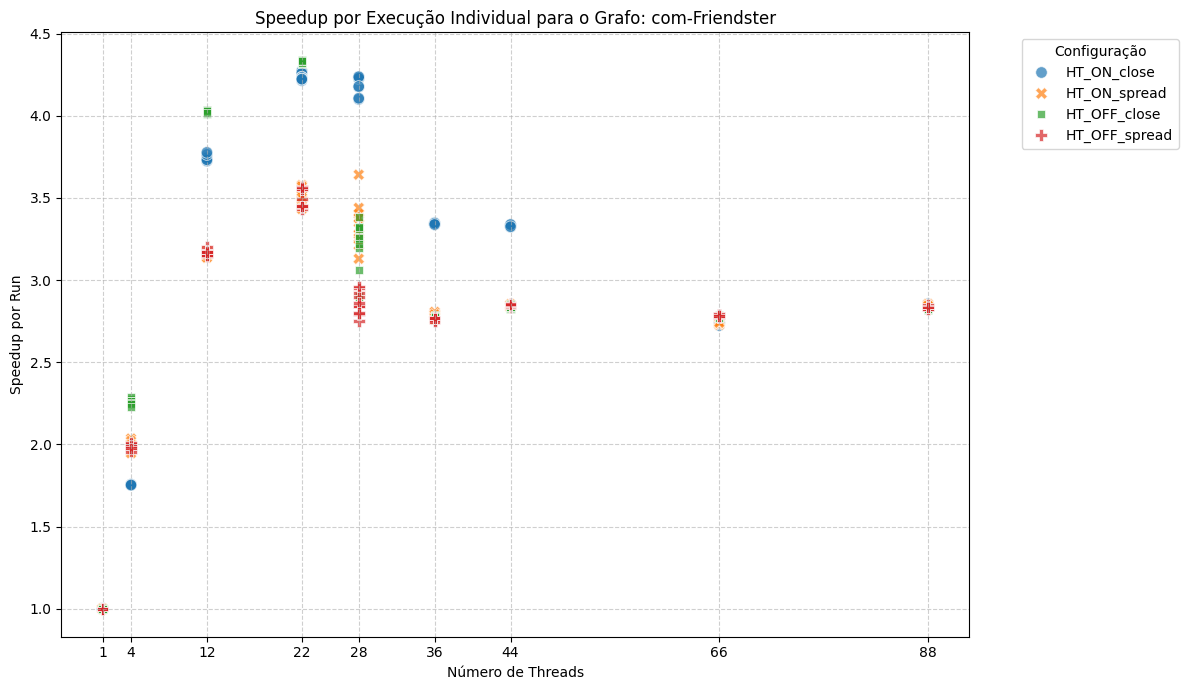

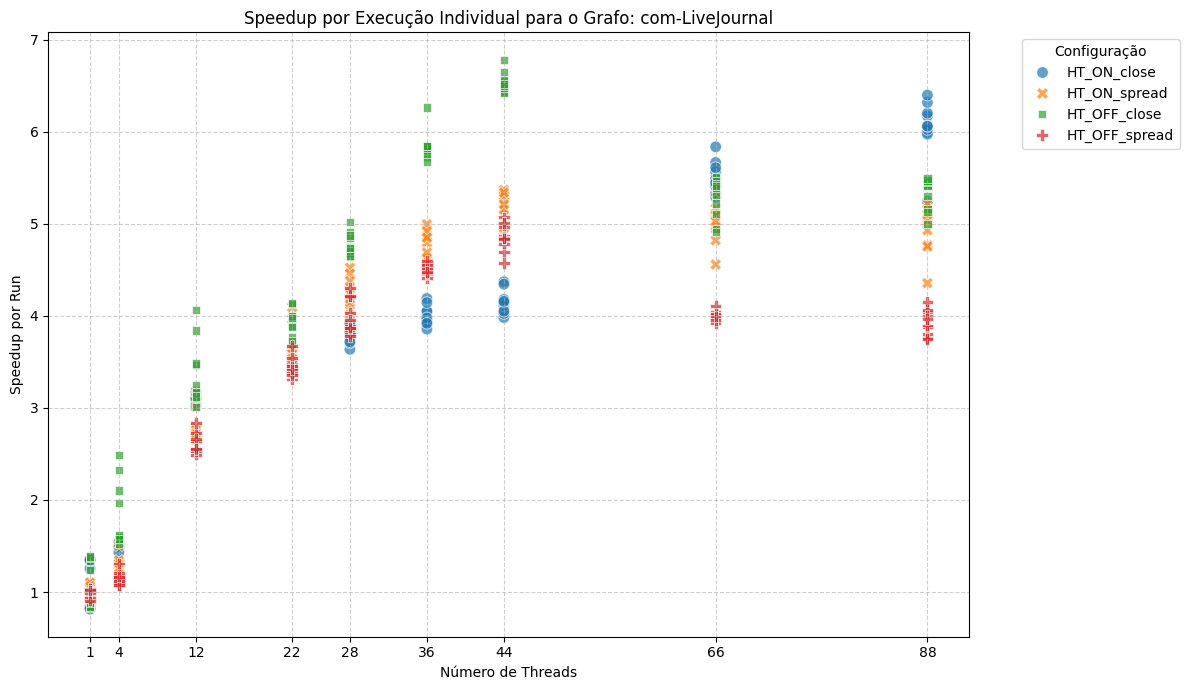

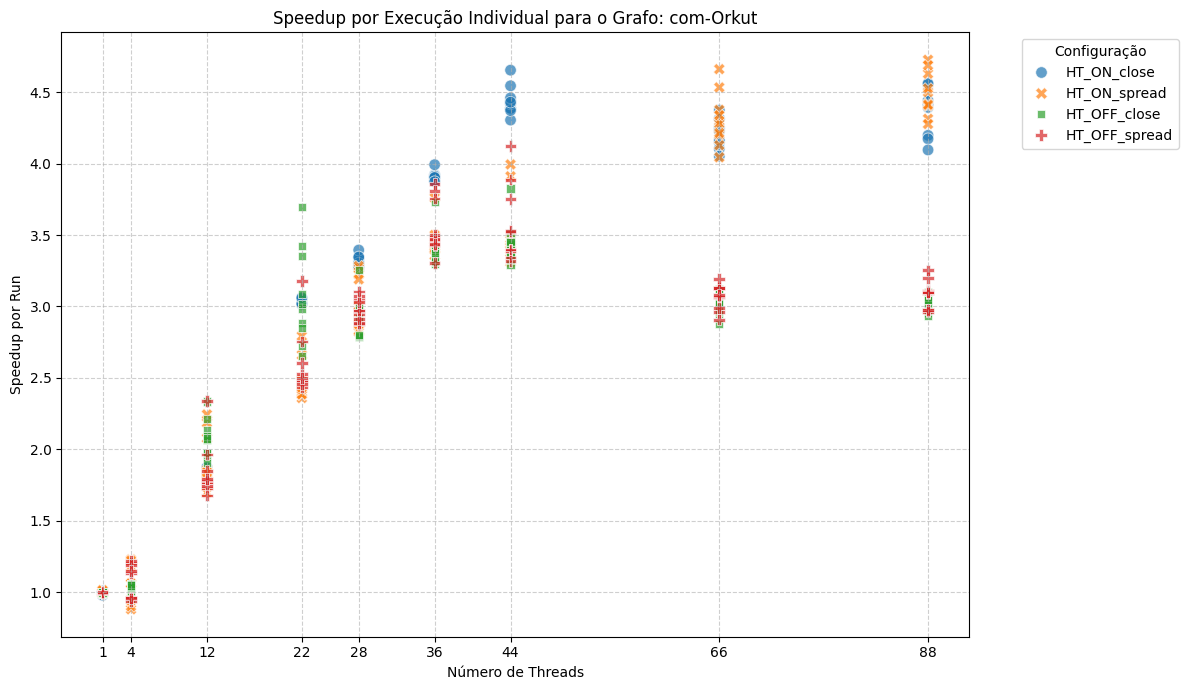

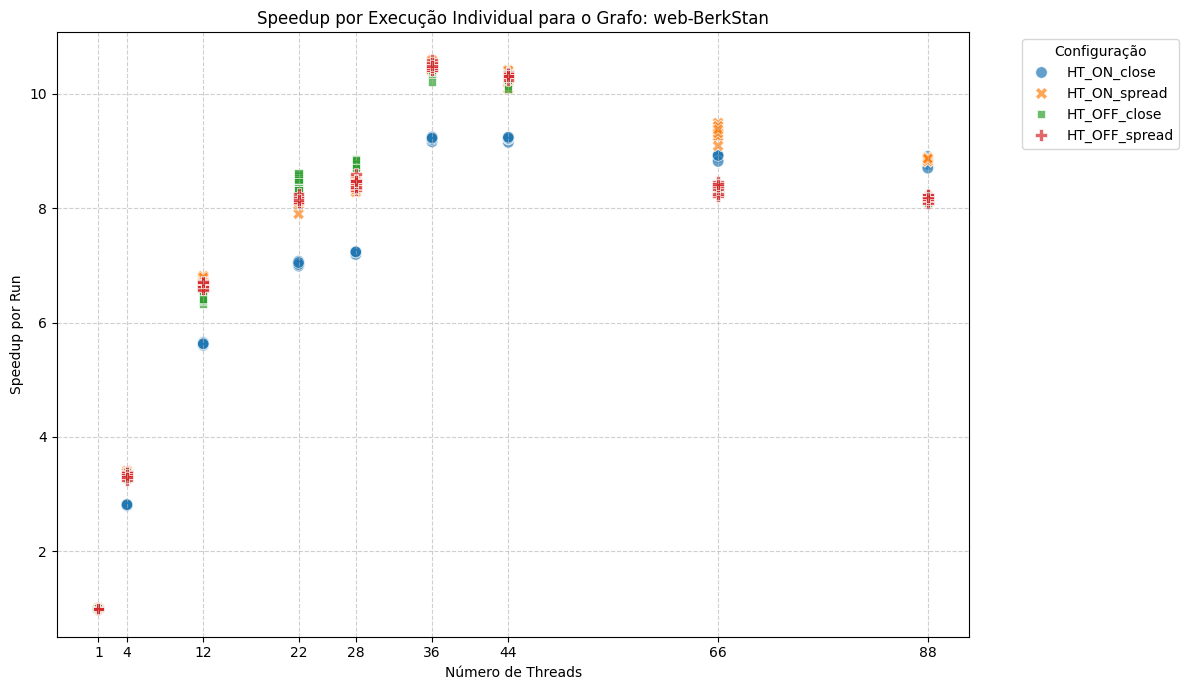

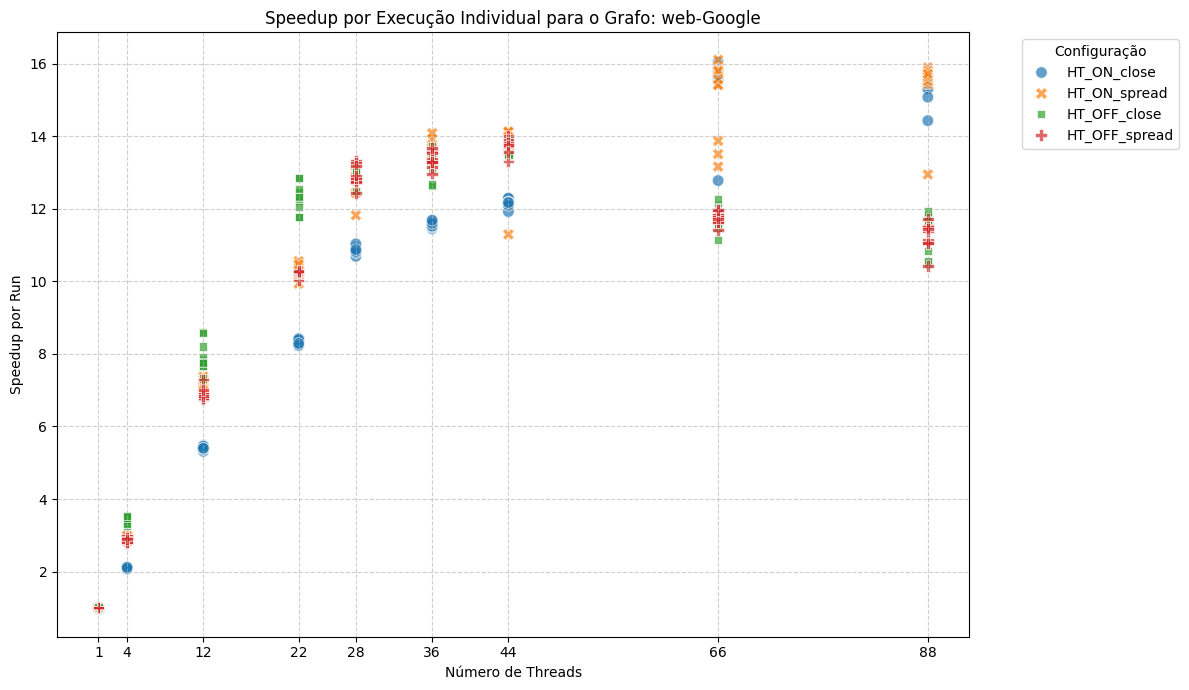

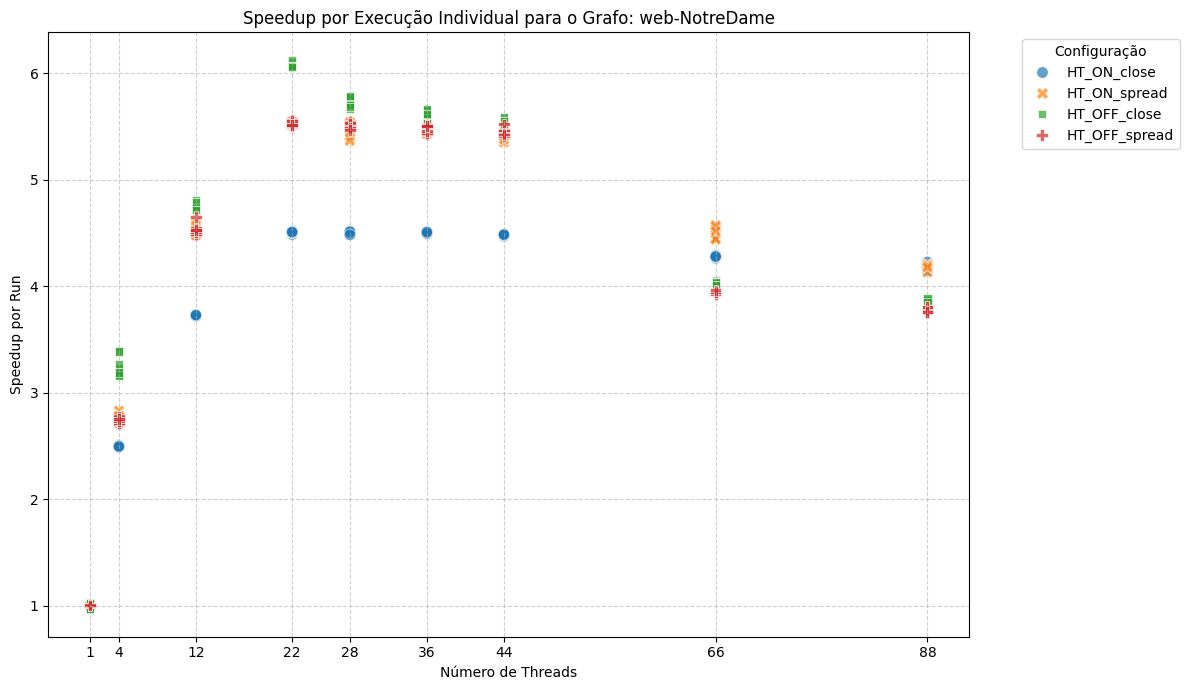

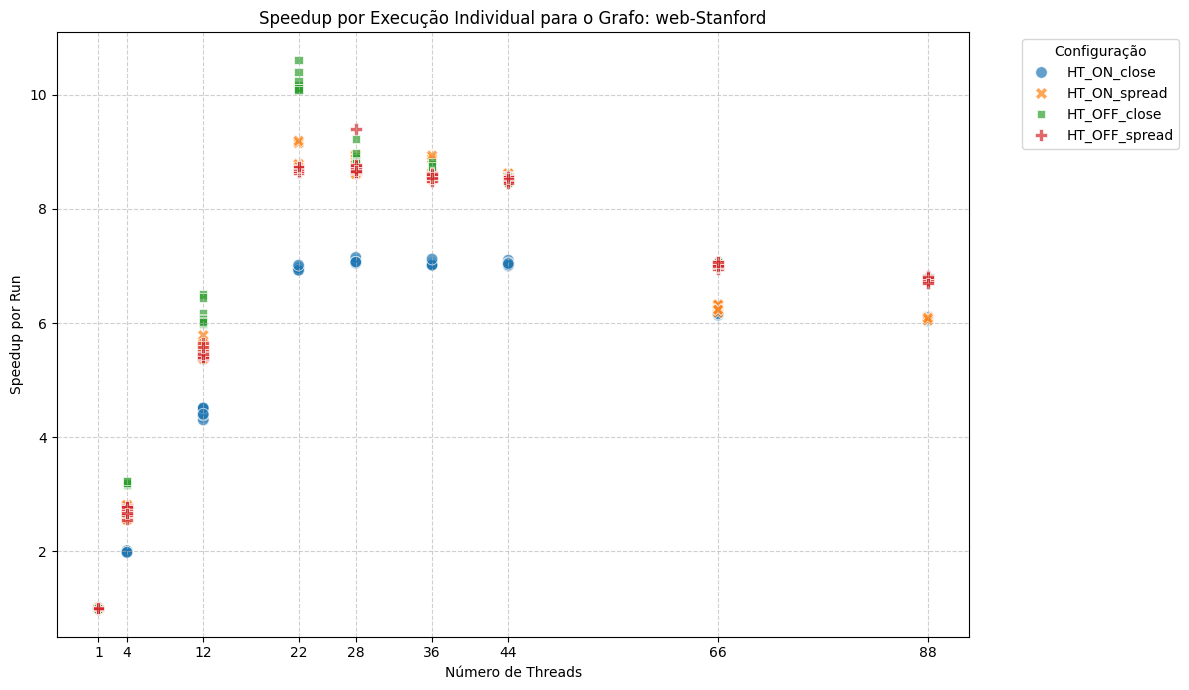

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Diretório base no Colab
BASE_DIR = Path("../stage3")
LOGS_AVG_CSV = BASE_DIR / "logs_average_times.csv"
UNIFIED_NO_VTUNE = BASE_DIR / "unified_results_noVTune.csv"
OUTPUT_DIR = BASE_DIR / "gráficos"

# Carrega os resultados brutos dos logs (sem o overhead do VTune)
df_runs = pd.read_csv(LOGS_AVG_CSV)

# Carrega os resultados unificados sem VTune para obter os tempos sequenciais
df_unified_no_vtune = pd.read_csv(UNIFIED_NO_VTUNE)

# Seleciona as colunas necessárias para o merge e o tempo sequencial
df_seq_times = df_unified_no_vtune[df_unified_no_vtune['THREADS'] == 1][
    ['GRAPH_NAME', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY', 'SEQUENTIAL_TIME']
].drop_duplicates()

# Faz o merge para adicionar o SEQUENTIAL_TIME a cada run individual
df_runs_with_seq_time = df_runs.merge(
    df_seq_times,
    on=['GRAPH_NAME', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY'],
    how='left'
)

# Calcula o Speedup para cada run individual
df_runs_with_seq_time['SPEEDUP_PER_RUN'] = (
    df_runs_with_seq_time['SEQUENTIAL_TIME'] / df_runs_with_seq_time['ELAPSED_TIME']
)

# CORREÇÃO: Cria coluna CONFIG tratando DISABLE_HYPERTHREADING como string
# DISABLE_HYPERTHREADING = "true" → HT DESATIVADO → "HT_OFF"
# DISABLE_HYPERTHREADING = "false" → HT ATIVADO → "HT_ON"
def criar_config(row):
    # Trata como string (formato do CSV)
    if isinstance(row['DISABLE_HYPERTHREADING'], str):
        ht_status = "HT_OFF" if row['DISABLE_HYPERTHREADING'].lower() == 'true' else "HT_ON"
    elif isinstance(row['DISABLE_HYPERTHREADING'], bool):
        ht_status = "HT_OFF" if row['DISABLE_HYPERTHREADING'] else "HT_ON"
    else:
        # Se for 0/1 (int)
        ht_status = "HT_OFF" if row['DISABLE_HYPERTHREADING'] else "HT_ON"

    return f"{ht_status}_{row['THREAD_BIND_POLICY']}"

df_runs_with_seq_time["CONFIG"] = df_runs_with_seq_time.apply(criar_config, axis=1)

# Obtém listas únicas de grafos
grafos = df_runs_with_seq_time["GRAPH_NAME"].unique()

# Cria a pasta "gráficos" se ela não existir
OUTPUT_DIR.mkdir(exist_ok=True)

# Itera sobre cada grafo para gerar os gráficos
for grafo in grafos:
    df_filtered_graph = df_runs_with_seq_time[df_runs_with_seq_time["GRAPH_NAME"] == grafo].copy()

    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        data=df_filtered_graph,
        x="THREADS",
        y="SPEEDUP_PER_RUN",
        hue="CONFIG",
        style="CONFIG",  # Adiciona estilo para melhor diferenciação
        marker="o",
        s=70,  # Tamanho dos pontos
        alpha=0.7  # Transparência para ver a sobreposição de pontos
    )

    plt.title(f"Speedup por Execução Individual para o Grafo: {grafo}")
    plt.xlabel("Número de Threads")
    plt.ylabel("Speedup por Run")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(sorted(df_filtered_graph["THREADS"].unique()))  # Ordenado
    plt.legend(title="Configuração", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Salva a figura como um arquivo PDF na pasta "gráficos"
    output_file = OUTPUT_DIR / f"speedup_per_run_{grafo}.pdf"
    plt.savefig(output_file, bbox_inches='tight')

    # Mostra a figura no notebook
    plt.show()



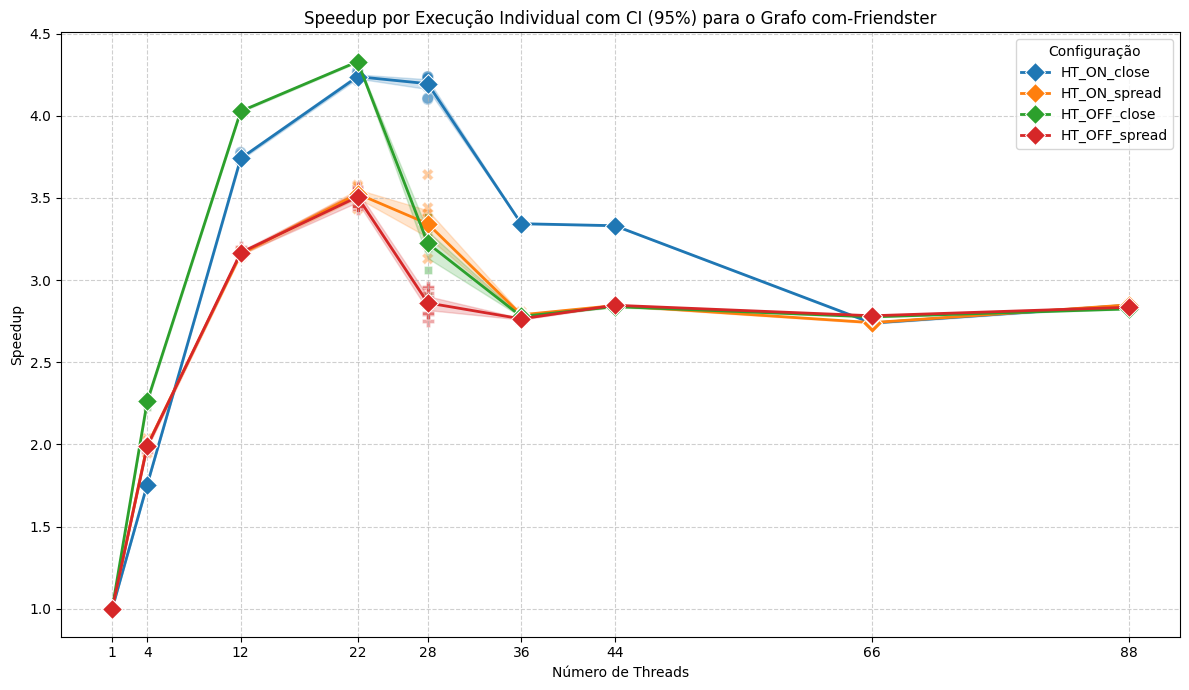

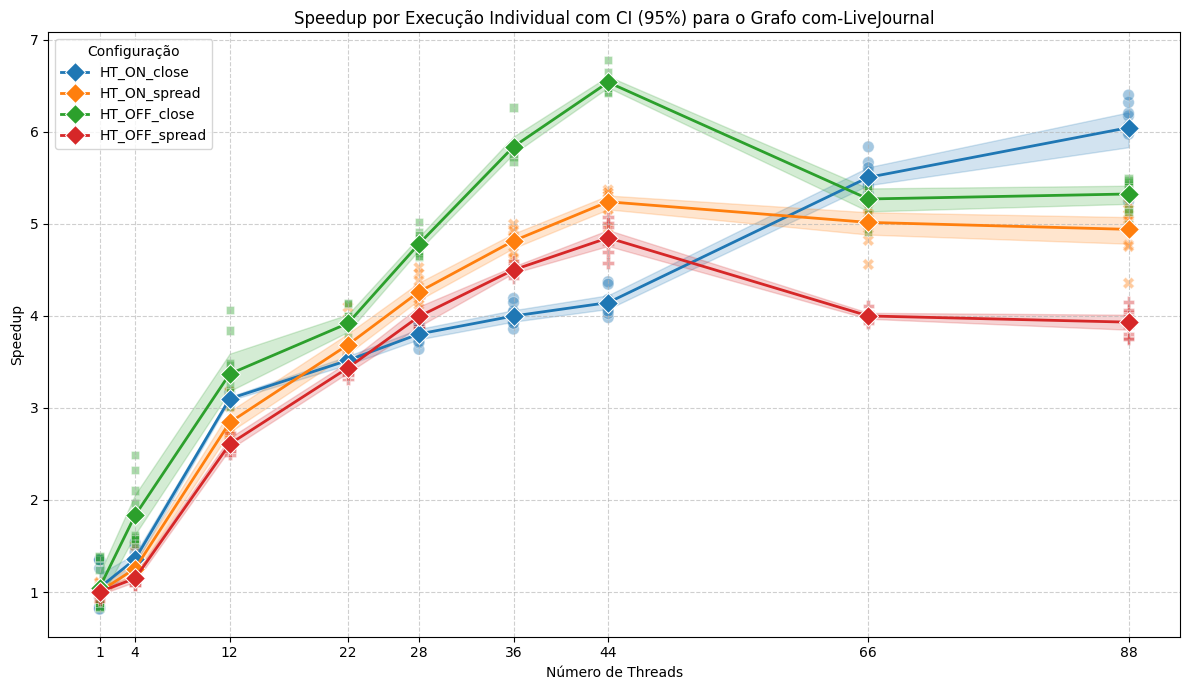

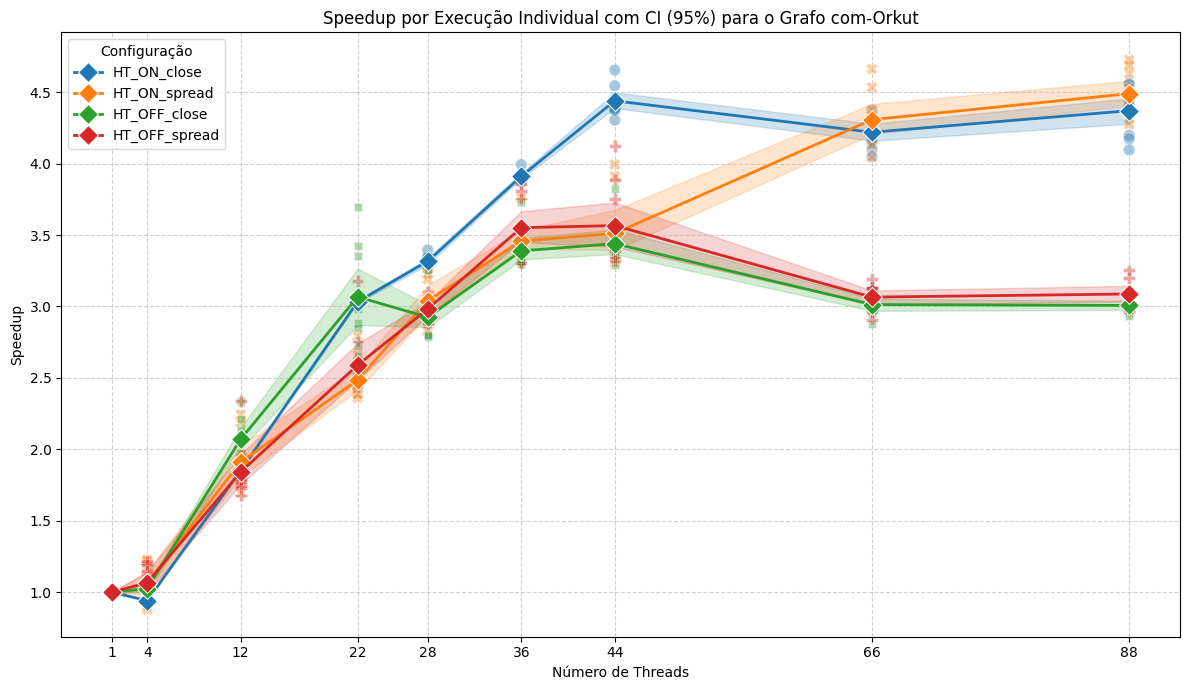

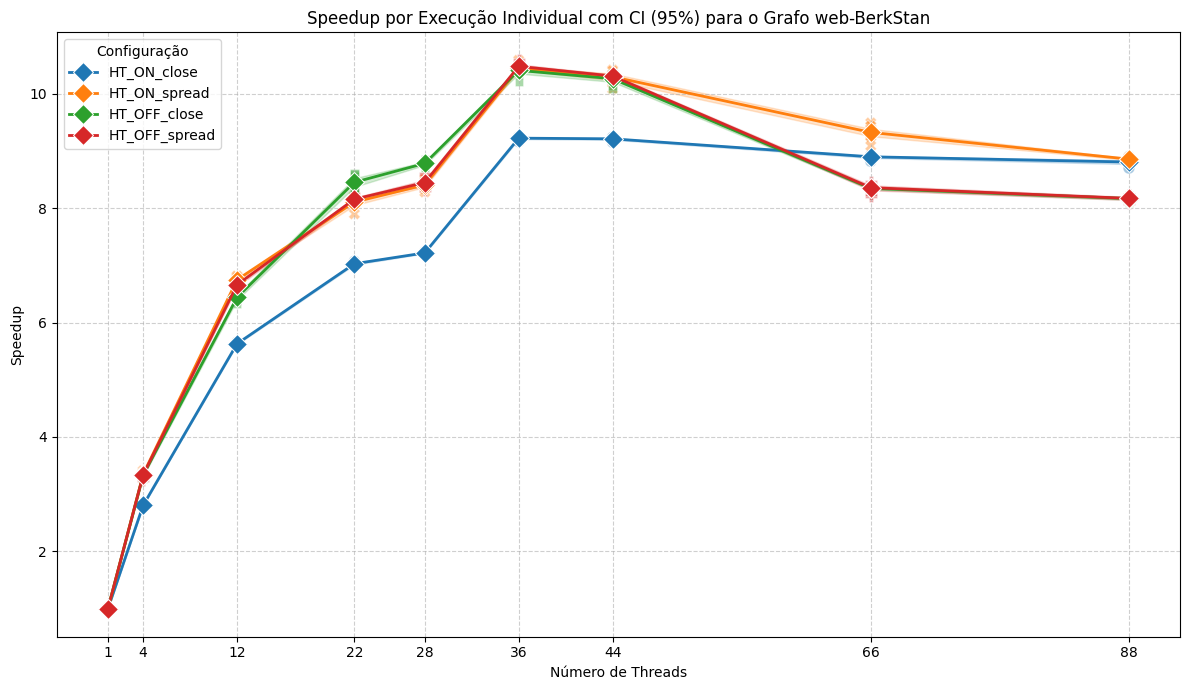

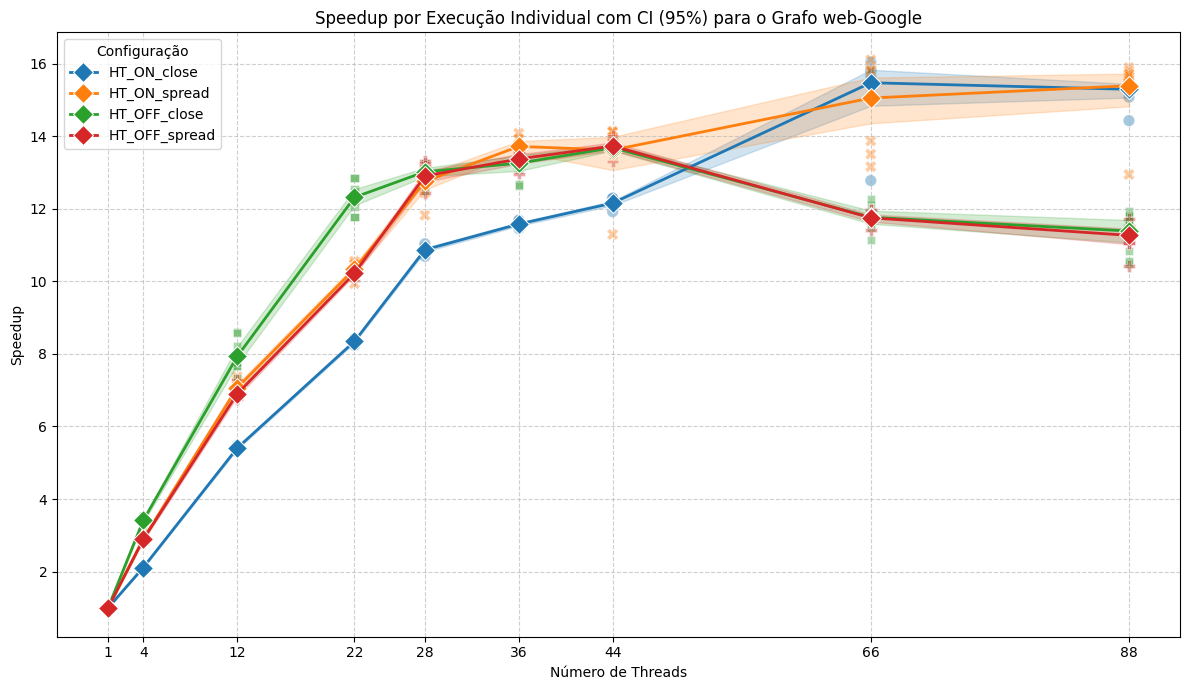

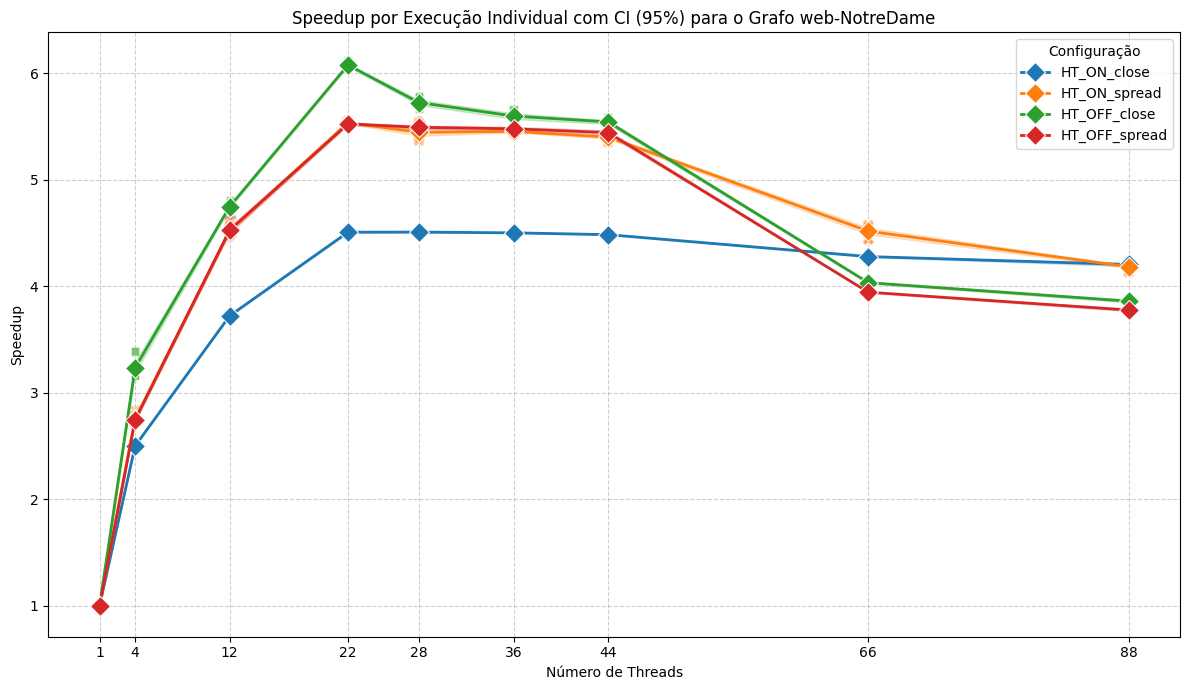

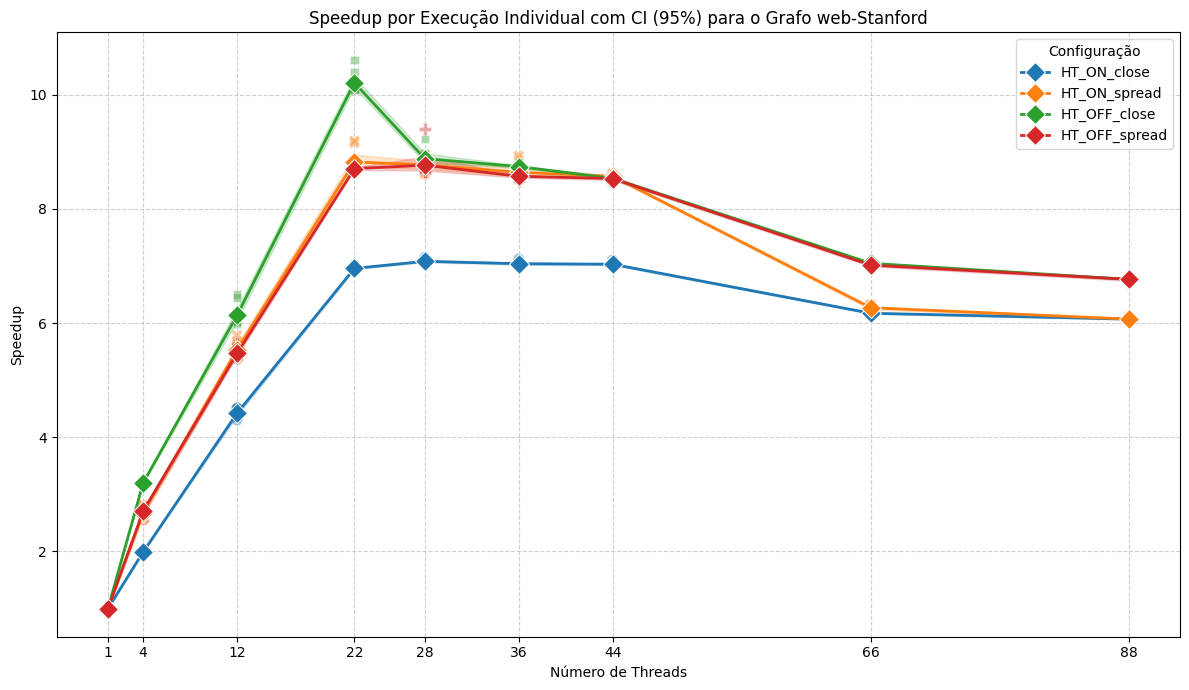

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Diretório base no Colab
BASE_DIR = Path("../stage3")
LOGS_AVG_CSV = BASE_DIR / "logs_average_times.csv"
UNIFIED_NO_VTUNE = BASE_DIR / "unified_results_noVTune.csv"
OUTPUT_DIR = BASE_DIR / "gráficos"

# Carrega os resultados brutos dos logs (sem o overhead do VTune)
df_runs = pd.read_csv(LOGS_AVG_CSV)

# Carrega os resultados unificados sem VTune para obter os tempos sequenciais
df_unified_no_vtune = pd.read_csv(UNIFIED_NO_VTUNE)

# Seleciona as colunas necessárias para o merge e o tempo sequencial
df_seq_times = df_unified_no_vtune[df_unified_no_vtune['THREADS'] == 1][
    ['GRAPH_NAME', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY', 'SEQUENTIAL_TIME']
].drop_duplicates()

# Faz o merge para adicionar o SEQUENTIAL_TIME a cada run individual
df_runs_with_seq_time = df_runs.merge(
    df_seq_times,
    on=['GRAPH_NAME', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY'],
    how='left'
)

# Calcula o Speedup para cada run individual
df_runs_with_seq_time['SPEEDUP_PER_RUN'] = (
    df_runs_with_seq_time['SEQUENTIAL_TIME'] / df_runs_with_seq_time['ELAPSED_TIME']
)

# DISABLE_HYPERTHREADING = "true" → HT DESATIVADO → "HT_OFF"
# DISABLE_HYPERTHREADING = "false" → HT ATIVADO → "HT_ON"
def criar_config(row):
    if isinstance(row['DISABLE_HYPERTHREADING'], str):
        ht_status = "HT_OFF" if row['DISABLE_HYPERTHREADING'].lower() == 'true' else "HT_ON"
    else:
        ht_status = "HT_OFF" if row['DISABLE_HYPERTHREADING'] else "HT_ON"
    return f"{ht_status}_{row['THREAD_BIND_POLICY']}"

df_runs_with_seq_time["CONFIG"] = df_runs_with_seq_time.apply(criar_config, axis=1)

# Obtém listas únicas de grafos
grafos = df_runs_with_seq_time["GRAPH_NAME"].unique()

# Cria a pasta "gráficos" se ela não existir
OUTPUT_DIR.mkdir(exist_ok=True)

# Itera sobre cada grafo para gerar os gráficos
for grafo in grafos:
    df_filtered_graph = df_runs_with_seq_time[df_runs_with_seq_time["GRAPH_NAME"] == grafo].copy()

    plt.figure(figsize=(12, 7))

    # Plotar os pontos individuais (scatterplot)
    sns.scatterplot(
        data=df_filtered_graph,
        x="THREADS",
        y="SPEEDUP_PER_RUN",
        hue="CONFIG",
        style="CONFIG",
        marker="o",
        s=70,
        alpha=0.4,
        zorder=1,
        legend=False
    )

    sns.lineplot(
        data=df_filtered_graph,
        x="THREADS",
        y="SPEEDUP_PER_RUN",
        hue="CONFIG",
        marker="D",
        markersize=10,
        errorbar=('ci', 95),
        linewidth=2,
        zorder=2,
        ax=plt.gca()
    )

    plt.title(f"Speedup por Execução Individual com CI (95%) para o Grafo {grafo}")
    plt.xlabel("Número de Threads")
    plt.ylabel("Speedup")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(sorted(df_filtered_graph["THREADS"].unique()))  # Ordenado
    plt.legend(title="Configuração")
    plt.tight_layout()

    # Salva a figura como um arquivo PDF na pasta "gráficos"
    output_file = OUTPUT_DIR / f"speedup_per_run_with_ci_{grafo}.pdf"
    plt.savefig(output_file, bbox_inches='tight')

    # Mostra a figura no notebook
    plt.show()

# Análise Estatística dos resultados


In [40]:
%cd ../stage3

/home/thiago/Documents/perf-analysis/stage3


In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
import os

# --- CONFIGURAÇÃO INICIAL ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (11, 7)
pd.options.display.float_format = '{:.6f}'.format

# 1. CRIAÇÃO DE DIRETÓRIOS (Com acento conforme solicitado)
os.makedirs('gráficos', exist_ok=True)
os.makedirs('tabelas', exist_ok=True)

print(">>> Diretórios 'gráficos/' e 'tabelas/' criados.")

# ==============================================================================
# 2. FUNÇÃO AUXILIAR DE FORMATAÇÃO LATEX (CRÍTICA)
# ==============================================================================
def formatar_para_latex(df_input):
    """
    Prepara um DataFrame para exportação LaTeX:
    1. Escapa underscores (_) em nomes de colunas (ex: sum_sq -> sum\_sq).
    2. Escapa underscores (_) nos índices.
    3. Escapa underscores (_) em células de texto.
    """
    df = df_input.copy()

    # 1. Escapar Colunas
    df.columns = [c.replace('_', r'\_') for c in df.columns]

    # 2. Escapar Índice (se for string)
    if df.index.dtype == 'object':
        df.index = [i.replace('_', r'\_') for i in df.index]

    # 3. Escapar Células de Texto
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(lambda x: x.replace('_', r'\_') if isinstance(x, str) else x)

    return df

# ==============================================================================
# 3. CARREGAMENTO E TRATAMENTO
# ==============================================================================
print("\n>>> Carregando dados...")
try:
    df_hw = pd.read_csv('hpc_hw_metrics.csv')
    df_res = pd.read_csv('unified_results.csv')
except FileNotFoundError:
    print("ERRO: Faça upload de 'hpc_hw_metrics.csv' e 'unified_results.csv'.")
    raise

join_keys = ['GRAPH_NAME', 'THREADS', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY']
df_res_grouped = df_res.groupby(join_keys)[['SPEEDUP', 'PARALLEL_EFFICIENCY']].mean().reset_index()
df = pd.merge(df_hw, df_res_grouped, on=join_keys)

# Conversão para GHz
df['AVERAGE_CPU_FREQUENCY'] = df['AVERAGE_CPU_FREQUENCY'] / 1e9
print("✅ AVERAGE_CPU_FREQUENCY convertida para GHz.")

# Lista de métricas para análise
metrics_cols = ['SPEEDUP', 'PARALLEL_EFFICIENCY', 'MEMORY_BOUND', 'CPI_RATE', 'AVERAGE_CPU_FREQUENCY']


# ==============================================================================
# 4. CORRELAÇÃO DE SPEARMAN
# ==============================================================================
print("\n>>> Gerando Correlação...")
corr_matrix = df[metrics_cols].corr(method='spearman')

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlação de Spearman')
plt.savefig('gráficos/correlacao_spearman.pdf', bbox_inches='tight') # Pasta com acento
plt.close()

# Tabela LaTeX
corr_latex = formatar_para_latex(corr_matrix)
with open('tabelas/correlacao_spearman.tex', 'w') as f:
    f.write(corr_latex.to_latex(float_format="%.4f", caption="Matriz de Correlação", label="tab:spearman", escape=False))


# ==============================================================================
# 5. GRÁFICOS (Eficiência)
# ==============================================================================
print(">>> Gerando Gráficos...")
plt.figure(figsize=(12, 7))
df_plot = df.copy()
df_plot['THREADS_CAT'] = df_plot['THREADS'].astype(str)
EXPECTED_THREADS = sorted(df['THREADS'].unique())
order_str = [str(x) for x in EXPECTED_THREADS]

sns.scatterplot(
    data=df_plot, x='MEMORY_BOUND', y='PARALLEL_EFFICIENCY',
    hue='THREADS_CAT', hue_order=order_str, style='THREADS_CAT',
    palette='turbo', s=100, alpha=0.8, edgecolor="black"
)
plt.title('Eficiência vs Memory Bound')
plt.savefig('gráficos/eficiencia_memory_bound.pdf', bbox_inches='tight')
plt.close()


# ==============================================================================
# 6. FEATURE IMPORTANCE (Random Forest)
# ==============================================================================
print(">>> Calculando Feature Importance...")
features = ['MEMORY_BOUND', 'CPI_RATE', 'AVERAGE_CPU_FREQUENCY']
X = df[features]
y = df['SPEEDUP']

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({
    'Metrica': features,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Importancia', y='Metrica', data=importances, palette='magma')
plt.title('Importância das Métricas')
plt.savefig('gráficos/feature_importance.pdf', bbox_inches='tight')
plt.close()

# Tabela LaTeX (Aqui aplicamos o escape na coluna 'Metrica')
imp_latex = formatar_para_latex(importances)
with open('tabelas/feature_importance.tex', 'w') as f:
    f.write(imp_latex.to_latex(index=False, float_format="%.4f", caption="Feature Importance", label="tab:feature_imp", escape=False))


# ==============================================================================
# 7. ANOVA (Speedup e Métricas)
# ==============================================================================
print(">>> Gerando Tabelas ANOVA...")

# Renomeia colunas para a fórmula (remove espaços/hifens para o statsmodels)
# MAS mantemos os nomes originais nos arquivos de saída se quisermos,
# aqui vamos usar nomes simplificados na fórmula.
df_anova = df.rename(columns={'DISABLE_HYPERTHREADING': 'HT_OFF', 'THREAD_BIND_POLICY': 'BINDING'})

# Lista de variáveis dependentes para rodar ANOVA
targets = ['SPEEDUP', 'MEMORY_BOUND', 'CPI_RATE', 'AVERAGE_CPU_FREQUENCY']

for target in targets:
    print(f"   -> Processando ANOVA para: {target}")

    formula = f'{target} ~ C(THREADS) + C(HT_OFF) * C(BINDING)'
    model = ols(formula, data=df_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # 1. Selecionar e Renomear Colunas
    # Renomeia PR(>F) para p-value e sum_sq (que vem do statsmodels) para algo seguro temporariamente
    out = anova_table[['sum_sq', 'F', 'PR(>F)']].rename(columns={'PR(>F)': 'p-value'})

    # 2. Aplicar Formatação LaTeX (Escapa sum_sq -> sum\_sq e índices como HT_OFF -> HT\_OFF)
    out_latex = formatar_para_latex(out)

    # 3. Salvar
    filename = f"tabelas/anova_{target.lower()}.tex"
    caption = f"ANOVA para {target.replace('_', r'\_')}" # Escape no caption também
    if target == 'AVERAGE_CPU_FREQUENCY':
        caption += " (GHz)"

    with open(filename, 'w') as f:
        f.write(out_latex.to_latex(float_format="%.6f", caption=caption, label=f"tab:anova_{target.lower()}", escape=False))

print("\n✅ Concluído! Gráficos salvos em 'gráficos/' e tabelas em 'tabelas/'.")

<>:28: SyntaxWarning: invalid escape sequence '\_'
<>:28: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_64254/760048778.py:28: SyntaxWarning: invalid escape sequence '\_'
  1. Escapa underscores (_) em nomes de colunas (ex: sum_sq -> sum\_sq).


>>> Diretórios 'gráficos/' e 'tabelas/' criados.

>>> Carregando dados...
✅ AVERAGE_CPU_FREQUENCY convertida para GHz.

>>> Gerando Correlação...
>>> Gerando Gráficos...
>>> Calculando Feature Importance...
>>> Gerando Tabelas ANOVA...
   -> Processando ANOVA para: SPEEDUP
   -> Processando ANOVA para: MEMORY_BOUND
   -> Processando ANOVA para: CPI_RATE
   -> Processando ANOVA para: AVERAGE_CPU_FREQUENCY

✅ Concluído! Gráficos salvos em 'gráficos/' e tabelas em 'tabelas/'.


/tmp/ipykernel_64254/760048778.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Metrica', data=importances, palette='magma')


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.ensemble import RandomForestRegressor
import os
import re

# --- CONFIGURAÇÃO INICIAL ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (11, 7)
pd.options.display.float_format = '{:.6f}'.format  # Formatação global para floats no console

# Cria diretórios para salvar os resultados
os.makedirs('gráficos', exist_ok=True)
os.makedirs('tabelas', exist_ok=True)

print(">>> Diretórios 'gráficos/' e 'tabelas/' criados/verificados.")

# ==============================================================================
# FUNÇÕES AUXILIARES
# ==============================================================================
def escape_latex_underscore(text):
    if not isinstance(text, str):
        return str(text)
    return text.replace('_', '\\_')

def format_value(value, precision=3):
    if pd.isna(value):
        return '-'
    return f"{value:.{precision}f}"

def highlight_cells_latex(row_mean, metric_info, thread_columns):
    formatted_cells = []
    values_to_compare = row_mean[thread_columns].dropna()

    if values_to_compare.empty:
        return ["-" for _ in thread_columns]

    min_val = values_to_compare.min()
    max_val = values_to_compare.max()

    for col in thread_columns:
        mean_val = row_mean.get(col, pd.NA)

        current_precision = 2
        if metric_info.get('metric_col') in ['AVERAGE_CPU_FREQUENCY', 'CPI_RATE']:
            current_precision = 3

        formatted_mean = format_value(mean_val, precision=current_precision)

        if pd.isna(mean_val):
            cell_str = "-"
        else:
            # Sem STD, apenas a média formatada
            cell_str = formatted_mean

        # Highlight logic (Based on Mean Value)
        if not pd.isna(mean_val) and min_val != max_val:
            if metric_info['better_is'] == 'higher':
                if mean_val == max_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{{{cell_str}}}"
                elif mean_val == min_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{{{cell_str}}}"
            elif metric_info['better_is'] == 'lower':
                if mean_val == min_val:
                    cell_str = f"\\cellcolor{{ForestGreen}}{{{cell_str}}}"
                elif mean_val == max_val:
                    cell_str = f"\\cellcolor{{BrickRed}}{{{cell_str}}}"

        formatted_cells.append(cell_str)
    return formatted_cells

# ==============================================================================
# 1. CARREGAMENTO E TRATAMENTO
# ==============================================================================
print("\n>>> 1. Carregando dados...")

try:
    df_hw = pd.read_csv('hpc_hw_metrics.csv')
except FileNotFoundError:
    print("ERRO: 'hpc_hw_metrics.csv' não encontrado.")
    raise

# Limpeza e Conversão
df_hw['GRAPH_NAME'] = df_hw['GRAPH_NAME'].str.replace(r'^(web-|com-)', '', regex=True)
df_hw["AVERAGE_CPU_FREQUENCY"] = df_hw["AVERAGE_CPU_FREQUENCY"] / 1e9
# STD columns não são mais necessárias para conversão/uso aqui

# Configuração Abreviada
df_hw["CONFIG"] = df_hw.apply(
    lambda row: ("H_OFF" if row["DISABLE_HYPERTHREADING"] else "H_ON") + "_" +
                ("C" if row["THREAD_BIND_POLICY"] == "close" else "S"),
    axis=1
)

# ==============================================================================
# 2. TABELAS COMBINADAS (Highlight APENAS, SEM STD)
# ==============================================================================
metrics_to_display = {
    "AVERAGE_CPU_FREQUENCY": {
        "title": "Frequência Média da CPU (GHz)",
        "better_is": "higher",
        "metric_col": "AVERAGE_CPU_FREQUENCY"
    },
    "MEMORY_BOUND": {
        "title": "Memory Bound (\%)",
        "better_is": "lower",
        "metric_col": "MEMORY_BOUND"
    },
    "CPI_RATE": {
        "title": "CPI Rate",
        "better_is": "lower",
        "metric_col": "CPI_RATE"
    }
}

for metric_key, metric_info in metrics_to_display.items():
    print(f"### Gerando Tabela: {metric_info['title']}")

    # Agrupar Média (STD removido)
    df_mean = df_hw.groupby(['GRAPH_NAME', 'CONFIG', 'THREADS'])[metric_info['metric_col']].mean().unstack()

    thread_columns = df_mean.columns.tolist()
    num_thread_cols = len(thread_columns)

    # Processar índices para escape LaTeX
    df_processed_index = df_mean.copy()
    df_processed_index.index = df_processed_index.index.set_levels(
        [df_processed_index.index.levels[0].map(escape_latex_underscore).tolist(),
         df_processed_index.index.levels[1].map(escape_latex_underscore).tolist()],
        level=[0, 1]
    )

    latex_body_lines = []
    current_graph = None

    # Início da Tabela
    latex_str = ""
    latex_str += "\\begin{table}[ht]\n"
    latex_str += "\\centering\n"
    latex_str += "\\small\n"

    col_format = 'll' + 'r' * num_thread_cols
    latex_str += f"\\begin{{tabular}}{{{col_format}}}\n"
    latex_str += "\\toprule\n"

    # Cabeçalho
    latex_str += (f"\\multirow{{2}}*{{{escape_latex_underscore('GRAPH_NAME')}}} & "
                  f"\\multirow{{2}}*{{{escape_latex_underscore('CONFIG')}}} & "
                  f"\\multicolumn{{{num_thread_cols}}}{{c}}{{{escape_latex_underscore('THREADS')}}} \\\\") + "\n"
    latex_str += f"\\cmidrule(lr){{3-{num_thread_cols + 2}}}\n"
    latex_str += (f" & & { ' & '.join(map(str, thread_columns)) } \\\\") + "\n"
    latex_str += "\\midrule\n"

    # Dados
    for (graph, config), row_mean in df_mean.iterrows():
        # Escapar nomes para exibição
        graph_disp = escape_latex_underscore(graph)
        config_disp = escape_latex_underscore(config)

        # Formatar células (Função alterada para não pedir STD)
        highlighted_cells = highlight_cells_latex(row_mean, metric_info, thread_columns)
        row_content_str = f"{config_disp} & " + " & ".join(highlighted_cells) + " \\\\"

        # Lógica Multirow
        if graph != current_graph:
            num_configs = len(df_mean.loc[graph])
            latex_body_lines.append(f"\\multirow{{{num_configs}}}{{*}}{{{graph_disp}}} & {row_content_str}")
            current_graph = graph
        else:
            latex_body_lines.append(f" & {row_content_str}")

        # Lógica Cline
        configs_of_graph = df_mean.loc[graph].index.get_level_values('CONFIG').tolist()
        if config == configs_of_graph[-1]:
            all_graphs = df_mean.index.get_level_values('GRAPH_NAME').unique()
            if graph != all_graphs[-1]:
                latex_body_lines.append(f"\\cline{{1-{num_thread_cols + 2}}}")

    latex_str += "\n".join(latex_body_lines) + "\n"
    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"

    # --- CAPTION (Abaixo da tabela) ---
    escaped_title = escape_latex_underscore(metric_info['title'])
    latex_str += f"\\caption{{Tabela Combinada de {escaped_title} (Valores Ótimos Destacados)}}\n"
    latex_str += f"\\label{{{f'tab:{metric_key.lower().replace('_', '-')}-combined-highlighted'}}}\n"
    # --------------------------------------------------

    latex_str += "\\end{table}\n"

    # Salvar
    filename = f"{metric_key.lower().replace('_', '-')}_combined_highlighted.tex"
    filepath = os.path.join("tabelas", filename)
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(latex_str)
    print(f"   -> Salvo em: {filepath}")

# ==============================================================================
# 3. ANOVA (Com P-Value Highlight e Caption Abaixo)
# ==============================================================================
print("\n>>> Gerando Tabelas ANOVA...")

# Carregar dados para ANOVA
try:
    df_res = pd.read_csv('unified_results.csv')

    # --- CORREÇÃO DE SEGURANÇA: Limpar nomes dos grafos ---
    df_res['GRAPH_NAME'] = df_res['GRAPH_NAME'].str.replace(r'^(web-|com-)', '', regex=True)
    # ------------------------------------------------------

    join_keys = ['GRAPH_NAME', 'THREADS', 'DISABLE_HYPERTHREADING', 'THREAD_BIND_POLICY']
    df_res_grouped = df_res.groupby(join_keys)[['SPEEDUP']].mean().reset_index()

    df_full = pd.merge(df_hw, df_res_grouped, on=join_keys)

    if df_full.empty:
        print("AVISO CRÍTICO: Dataframe vazio após merge. Verifique correspondência de nomes.")
        df_full = None

except FileNotFoundError:
     print("ERRO: 'unified_results.csv' não encontrado. Pulando ANOVA.")
     df_full = None

if df_full is not None:
    df_anova = df_full.rename(columns={'DISABLE_HYPERTHREADING': 'HT_OFF', 'THREAD_BIND_POLICY': 'BINDING'})

    def salvar_tabela_anova(anova_df, nome_arquivo, caption, label):
        out_df = anova_df[['sum_sq', 'F', 'PR(>F)']].copy()
        out_df = out_df.rename(columns={'PR(>F)': 'p-value', 'sum_sq': r'sum\_sq'})

        def highlight_p_val(val):
            if pd.isna(val): return "-"
            str_val = f"{val:.6f}"
            if val < 0.05:
                return f"\\cellcolor{{ForestGreen}}{{{str_val}}}"
            return str_val

        out_df['p-value'] = out_df['p-value'].apply(highlight_p_val)
        out_df.index = [idx.replace('_', r'\_') for idx in out_df.index]

        # Gerar o código tabular puro
        latex_tabular = out_df.to_latex(float_format="%.6f", escape=False)

        # Montar ambiente table com caption embaixo
        latex_code = "\\begin{table}[ht]\n"
        latex_code += "\\centering\n"
        latex_code += latex_tabular
        latex_code += f"\\caption{{{caption}}}\n"
        latex_code += f"\\label{{{label}}}\n"
        latex_code += "\\end{table}\n"

        with open(nome_arquivo, 'w') as f:
            f.write(latex_code)
        print(f"   -> Salvo em: {nome_arquivo}")

    # ANOVA Speedup
    try:
        model = ols('SPEEDUP ~ C(THREADS) + C(HT_OFF) * C(BINDING)', data=df_anova).fit()
        salvar_tabela_anova(sm.stats.anova_lm(model, typ=2), 'tabelas/anova_speedup.tex', "ANOVA Speedup", "tab:anova_speedup")

        # ANOVA Métricas
        for metric in ['MEMORY_BOUND', 'CPI_RATE', 'AVERAGE_CPU_FREQUENCY']:
            model = ols(f'{metric} ~ C(THREADS) + C(HT_OFF) * C(BINDING)', data=df_anova).fit()
            metric_esc = metric.replace('_', r'\_')
            caption = f"ANOVA para {metric_esc}" + (" (GHz)" if "FREQUENCY" in metric else "")
            salvar_tabela_anova(sm.stats.anova_lm(model, typ=2), f"tabelas/anova_{metric.lower()}.tex", caption, f"tab:anova_{metric.lower()}")
    except Exception as e:
        print(f"ERRO ao calcular ANOVA: {e}")

print("\nConcluído!")

>>> Diretórios 'gráficos/' e 'tabelas/' criados/verificados.

>>> 1. Carregando dados...
### Gerando Tabela: Frequência Média da CPU (GHz)
   -> Salvo em: tabelas/average-cpu-frequency_combined_highlighted.tex
### Gerando Tabela: Memory Bound (\%)
   -> Salvo em: tabelas/memory-bound_combined_highlighted.tex
### Gerando Tabela: CPI Rate
   -> Salvo em: tabelas/cpi-rate_combined_highlighted.tex

>>> Gerando Tabelas ANOVA...
   -> Salvo em: tabelas/anova_speedup.tex
   -> Salvo em: tabelas/anova_memory_bound.tex
   -> Salvo em: tabelas/anova_cpi_rate.tex
   -> Salvo em: tabelas/anova_average_cpu_frequency.tex

Concluído!


<>:110: SyntaxWarning: invalid escape sequence '\%'
<>:110: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_64254/1040468038.py:110: SyntaxWarning: invalid escape sequence '\%'
  "title": "Memory Bound (\%)",


In [43]:
import zipfile
import os

# Define os nomes das pastas a serem zipadas
folders_to_zip = ['tabelas', 'gráficos']
zip_filename = 'resultados_analise.zip'

# Cria o arquivo zip
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder_name in folders_to_zip:
        if os.path.exists(folder_name) and os.path.isdir(folder_name):
            for root, _, files in os.walk(folder_name):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Adiciona o arquivo ao zip, mantendo a estrutura de diretórios
                    zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(folder_name)))
            print(f"Pasta '{folder_name}' adicionada ao zip.")
        else:
            print(f"Aviso: Pasta '{folder_name}' não encontrada e não será adicionada ao zip.")

print(f"Arquivo zip '{zip_filename}' criado com sucesso!")

Pasta 'tabelas' adicionada ao zip.
Pasta 'gráficos' adicionada ao zip.
Arquivo zip 'resultados_analise.zip' criado com sucesso!


# Dificuldades enfrentadas no trabalho
- O VTune gera **muitos** dados, e a grande maioria não eram de interesse do grupo.
- Falta de disponibilidade ocasional da máquina. ( Obrigado bmmoreira! )
- Conseguir deixar executando sem o Hyperthreading. Demoramos pra descobrir que não é possível utilizar políticas e variáveis no OpenMP pra desabilitar o Hyperthreading.
- Vtune gerando arquivos de saída mal formatados e grandes.
- Não estávamos acostumados a fazer pesquisa dessa forma, sendo bem novo utilizar notebooks pra gerar gráficos e fazer anotações em arquivos MarkDown e Notebooks.


# Compilando Código LaTeX

In [68]:
%%bash
cd apresentacao
latexmk -pdf -interaction=nonstopmode main.tex
cd ..

Rc files read:
  NONE
Latexmk: This is Latexmk, John Collins, 27 Dec. 2024. Version 4.86a.
Latexmk: applying rule 'pdflatex'...
Rule 'pdflatex':  Reasons for rerun
Changed files or newly in use/created:
  main.aux
  main.tex
Category 'changed_user':
  main.tex

------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  -interaction=nonstopmode -recorder  "main.tex"'
------------
This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2026/dev/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>

! LaTeX Error: File `beamer.cls' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: cls)

Enter file name: 
! Emergency stop.
<read *> 
         
l.13 \usepackage
                [T1]{fontenc}^^M
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on main.log.
Latexmk: Getting log

Latexmk: Missing input file 'beamer.cls' (or dependence on it) from following:
  ! LaTeX Error: File `beamer.cls' not found.


Latexmk: Errors, so I did not complete making targets
Collected error summary (may duplicate other messages):
  pdflatex: Command for 'pdflatex' gave return code 1
      Refer to 'main.log' and/or above output for details



Latexmk: Sometimes, the -f option can be used to get latexmk
  to try to force complete processing.
  But normally, you will need to correct the file(s) that caused the
  error, and then rerun latexmk.
  In some cases, it is best to clean out generated files before rerunning
  latexmk after you've corrected the files.


In [ ]:
%%bash
cd relatorio/samples
latexmk -pdf -interaction=nonstopmode main.tex
cd ../..

Rc files read:
  NONE
Latexmk: This is Latexmk, John Collins, 27 Dec. 2024. Version 4.86a.
Latexmk: applying rule 'pdflatex'...
Rule 'pdflatex':  Reasons for rerun
Changed files or newly in use/created:
  acmart.cls
Category 'changed_user':
  acmart.cls

------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  -interaction=nonstopmode -recorder  "main.tex"'
------------
This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2026/dev/Arch Linux) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(./acmart.cls
Document Class: acmart 2025/08/27 v2.16 Typesetting articles for the Associatio
n for Computing Machinery

! LaTeX Error: File `xkeyval.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.49 \RequirePackage
                    {xstr

Latexmk: Missing input file 'xkeyval.sty' (or dependence on it) from following:
  ! LaTeX Error: File `xkeyval.sty' not found.


Latexmk: Errors, so I did not complete making targets
Collected error summary (may duplicate other messages):
  pdflatex: Command for 'pdflatex' gave return code 1
      Refer to 'main.log' and/or above output for details



Latexmk: Sometimes, the -f option can be used to get latexmk
  to try to force complete processing.
  But normally, you will need to correct the file(s) that caused the
  error, and then rerun latexmk.
  In some cases, it is best to clean out generated files before rerunning
  latexmk after you've corrected the files.
